In [2]:
import os
from typing import Any, Callable, Dict, Tuple, Union
from torcheeg.datasets import BaseDataset
from torcheeg.utils import get_random_dir_path
from scipy.io import loadmat
import re
import pandas as pd
import mne
from scipy.signal import stft
import numpy as np

class StrokePatientsMIDataset(BaseDataset):
    def __init__(self,
                 root_path='./StrokePatientsMIDataset',
                 chunk_size: int = 500,
                 overlap: int = 0,
                 online_transform: Union[None, Callable] = None,
                 offline_transform: Union[None, Callable] = None,
                 label_transform: Union[None, Callable] = None,
                 before_trial: Union[None, Callable] = None,
                 after_trial: Union[Callable, None] = None,
                 after_session: Union[Callable, None] = None,
                 after_subject: Union[Callable, None] = None,
                 io_path: Union[None, str] = None,
                 io_size: int = 1048576,
                 io_mode: str = 'lmdb',
                 num_worker: int = 0,
                 verbose: bool = True,
                ):
        if io_path is None:
            io_path = get_random_dir_path(dir_prefix='datasets')

        self.subjects_info = pd.read_csv(os.path.join(root_path,
                                                      'participants.tsv'),
                                         sep='\t')
        self.electodes_info = pd.read_csv(os.path.join(
            root_path, "task-motor-imagery_electrodes.tsv"),
                                          sep='\t')
        electodes_info2 = pd.read_csv(os.path.join(
            root_path, "task-motor-imagery_channels.tsv"),
                                      sep='\t')
        self.electodes_info = pd.merge(self.electodes_info,
                                       electodes_info2,
                                       on='name',
                                       how='outer')
        refence = {
            'name': 'CPz',
            'type': 'EEG',
            'status': 'good',
            'status_description': 'refence'
        }

        insert_index = self.electodes_info.index[
            self.electodes_info.index.get_loc(17)]
        self.electodes_info = pd.concat([
            self.electodes_info.iloc[:insert_index],
            pd.DataFrame([refence], index=[insert_index]),
            self.electodes_info.iloc[insert_index:]
        ])
        self.electodes_info.index = range(len(self.electodes_info))

        self.events_info = pd.read_csv(os.path.join(
            root_path, 'task-motor-imagery_events.tsv'),
                                       sep='\t')
        # pass all arguments to super class
        params = {
            'root_path': root_path,
            'chunk_size': chunk_size,
            'overlap': overlap,
            'online_transform': online_transform,
            'offline_transform': offline_transform,
            'label_transform': label_transform,
            'before_trial': before_trial,
            'after_trial': after_trial,
            'after_session': after_session,
            'after_subject': after_subject,
            'io_path': io_path,
            'io_size': io_size,
            'io_mode': io_mode,
            'num_worker': num_worker,
            'verbose': verbose,
        }
        super().__init__(**params)
        # save all arguments to __dict__
        self.__dict__.update(params)

    

    @staticmethod
    def process_record_edf(file,
                           chunk_size: int,
                           overlap: int,
                           offline_transform: Union[None, Callable] = None,
                           **kwargs):
        subject_id = int(
            re.findall("sub-(\d\d)_task-motor-imagery_eeg.edf", file)[0])
        edf_reader = mne.io.read_raw_edf(file, preload=True)
        epochs = mne.make_fixed_length_epochs(edf_reader,
                                              duration=8,
                                              preload=True)
        data = epochs.get_data(
        )  # shape(40,33,4000) -num_trial, channels, T—duration（8s）

                  
        eeg = data[:, :30, :]
        #eog = data[:, 30:32, :]


        for trial_id, eeg_trial in enumerate(eeg):
            eeg_baseline = eeg_trial[:, :1000]
            #eog_baseline = eog_trial[:, :1000]
            label = 1 if trial_id % 2 else 0

            assert chunk_size > overlap, f"Arg 'chunk_size' must be larger than arg 'overlap'.Current chunksize is {chunk_size},overlap is {overlap}"
            start = 1000
            step = chunk_size - overlap
            end = start + step
            end_time_point = 3000
            
            write_pointer = 0
            #PUT baseline into io
            baseline_id = f"{trial_id}_{write_pointer}"
            yield_dict = {'key': baseline_id,'eeg':eeg_baseline}
            yield yield_dict
            write_pointer += 1

            while end <= end_time_point:
                eeg_clip = eeg_trial[:, start:end]
                if (not offline_transform is None):
                    eeg_clip = offline_transform(eeg=eeg_clip,
                                                 baseline=eeg_baseline)['eeg']
                clip_id = f"{trial_id}_{write_pointer}"
                record_info = {
                    "clip_id": clip_id,
                    'label': label,
                    'trial_id': trial_id,
                    'baseline_id': baseline_id,
                    'subject_id': subject_id
                }
                yield {'eeg':eeg_clip,'key': clip_id, "info": record_info}
                start, end = start + step, end + step
                write_pointer += 1

    @staticmethod
    def process_record(file,
                           chunk_size: int,
                           overlap: int,
                           offline_transform: Union[None, Callable] = None,
                           **kwargs):
        subject_id = int(
            re.findall("sub-(\d\d)_task-motor-imagery_eeg.mat", file)[0])
        fdata = loadmat(os.path.join(file))
        X, Y = fdata['eeg'][0][
            0]  # X.shape = [40trials, 33channels,4000timepoints]
        Y = Y[:, 0]
        eeg = X[:, :30, :]


        for trial_id, eeg_trial in enumerate(eeg):
            eeg_baseline = eeg_trial[:, :1000]
            #eog_baseline = eog_trial[:, :1000]
            label = 1 if trial_id % 2 else 0

            assert chunk_size > overlap, f"Arg 'chunk_size' must be larger than arg 'overlap'.Current chunksize is {chunk_size},overlap is {overlap}"
            start = 1000
            step = chunk_size - overlap
            end = start + chunk_size
            end_time_point = 3000

            write_pointer = 0
            #PUT baseline into io
            baseline_id = f"{trial_id}_{write_pointer}"
            baseline_yield_dict = {'key': baseline_id,'eeg':eeg_baseline}
            yield baseline_yield_dict
            write_pointer += 1

            while end <= end_time_point:
                eeg_clip = eeg_trial[:, start:end]
                # print(eeg_clip.shape)
                if (not offline_transform is None):
                    eeg_clip = offline_transform(eeg=eeg_clip,
                                                 baseline=eeg_baseline)['eeg']
                eeg_clip = eeg_clip.reshape(1, 30,128)

                clip_id = f"{trial_id}_{write_pointer}"
                record_info = {
                    "clip_id": clip_id,
                    'label': label,
                    'trial_id': trial_id,
                    'baseline_id': baseline_id,
                    'subject_id': subject_id
                }
        
                yield {'eeg':eeg_clip,'key': clip_id, "info": record_info}
                start, end = start + step, end + step
                write_pointer += 1


   

    def set_records(self, root_path, **kwargs):
        subject_dir = os.path.join(root_path, 'sourcedata')
        return [
            os.path.join(os.path.join(subject_dir, sub),
                         os.listdir(os.path.join(subject_dir, sub))[0])
            for sub in os.listdir(subject_dir)
        ]

    def __getitem__(self, index: int) -> Tuple:
        info = self.read_info(index)
        eeg_index = str(info['clip_id'])
        eeg_record = str(info['_record_id'])
        baseline_index = str(info['baseline_id'])
        subject_index = str(info['subject_id'])
        signal = self.read_eeg(eeg_record, eeg_index)
        baseline = self.read_eeg(eeg_record, baseline_index)
        if self.online_transform:
            signal = self.online_transform(eeg=signal,
                                            baseline=baseline)['eeg']
        # signal = signal.reshape(5,100,7,5)
        if self.label_transform:
            info = self.label_transform(y=info)['y']
        
        return signal, info, subject_index

    @property
    def repr_body(self) -> Dict:
        return dict(
            super().repr_body, **{
                'root_path': self.root_path,
                'chunk_size': self.chunk_size,
                'overlap': self.overlap,
                'online_transform': self.online_transform,
                'offline_transform': self.offline_transform,
                'label_transform': self.label_transform,
                'before_trial': self.before_trial,
                'after_trial': self.after_trial,
                'after_session': self.after_session,
                'after_subject': self.after_subject,
                'io_path': self.io_path,
                'io_size': self.io_size,
                'io_mode': self.io_mode,
                'num_worker': self.num_worker,
                'verbose': self.verbose
            })

In [4]:
import torch
import logging
import torch.nn as nn
from tqdm import tqdm
from pathlib import Path
from torch import autograd
from sklearn import model_selection
from torch.utils.data import Dataset, Subset, DataLoader
from strokesdict import STROKEPATIENTSMI_LOCATION_DICT
import scipy
from torcheeg.transforms import Select,BandSignal,Compose
from to import ToGrid,ToTensor,To2d
from typing import Callable, Dict, Union, List
import numpy as np
import soxr
from downsample import SetSamplingRate
from baseline import BaselineCorrection
from torcheeg.transforms import EEGTransform, Select,BandSignal,Compose,ToTensor
from strokes import StrokePatientsMIDataset, StrokePatientsMIProcessedDataset
dataset_45mat = StrokePatientsMIDataset(root_path='../../mi_swin/subdataset',
                                  io_path='.torcheeg/datasets_1741056327449_PLSVj',
                        chunk_size=500,  # 1 second
                        overlap = 0,
                        offline_transform=Compose(
                                [
                                SetSamplingRate(origin_sampling_rate=500,target_sampling_rate=128),
                                BandSignal(sampling_rate=128)
                                ]),
                        online_transform=Compose(
                                # [ToTensor()]),
                                [ToGrid(STROKEPATIENTSMI_LOCATION_DICT),ToTensor()]),
                
                        label_transform=Select('label'),
                        num_worker=8
)

dataset_45edf = StrokePatientsMIProcessedDataset(root_path='../../mi_swin/subdataset',
                                  io_path='.torcheeg/datasets_1741056336882_F0UyZ',
                        chunk_size=500,  # 1 second
                        overlap = 0,
                        offline_transform=Compose(
                                [BaselineCorrection(),
                                SetSamplingRate(origin_sampling_rate=500,target_sampling_rate=128),
                                BandSignal(sampling_rate=128)
                                ]),
                        online_transform=Compose(
                                # [ToTensor()]),
                                [ToGrid(STROKEPATIENTSMI_LOCATION_DICT),ToTensor()]),
                
                        label_transform=Select('label'),
                        num_worker=8
)


[2025-03-04 10:50:28] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from .torcheeg/datasets_1741056327449_PLSVj.
[2025-03-04 10:50:28] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from .torcheeg/datasets_1741056336882_F0UyZ.


In [5]:
dataset_40mat = StrokePatientsMIDataset(root_path='../../mi_swin/subdataset',
                                  io_path='.torcheeg/datasets_1741056489811_SfoUD',
                        chunk_size=500,  # 1 second
                        overlap = 0,
                        offline_transform=Compose(
                                [
                                SetSamplingRate(origin_sampling_rate=500,target_sampling_rate=128),
                                BandSignal(sampling_rate=128)
                                ]),
                        online_transform=Compose(
                                # [ToTensor()]),
                                [ToGrid(STROKEPATIENTSMI_LOCATION_DICT),ToTensor()]),
                
                        label_transform=Select('label'),
                        num_worker=8
)
dataset_40edf = StrokePatientsMIProcessedDataset(root_path='../../mi_swin/subdataset',
                                  io_path='.torcheeg/datasets_1741056498760_SiLdG',
                        chunk_size=500,  # 1 second
                        overlap = 0,
                        offline_transform=Compose(
                                [BaselineCorrection(),
                                SetSamplingRate(origin_sampling_rate=500,target_sampling_rate=128),
                                BandSignal(sampling_rate=128)
                                ]),
                        online_transform=Compose(
                                # [ToTensor()]),
                                [ToGrid(STROKEPATIENTSMI_LOCATION_DICT),ToTensor()]),
                
                        label_transform=Select('label'),
                        num_worker=8
)

[2025-03-04 10:50:32] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from .torcheeg/datasets_1741056489811_SfoUD.
[2025-03-04 10:50:32] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from .torcheeg/datasets_1741056498760_SiLdG.


In [6]:
dataset_50mat = StrokePatientsMIDataset(root_path='../../mi_swin/subdataset',
                                  io_path='.torcheeg/datasets_1741056572380_MOqa4',
                        chunk_size=500,  # 1 second
                        overlap = 0,
                        offline_transform=Compose(
                                [
                                SetSamplingRate(origin_sampling_rate=500,target_sampling_rate=128),
                                BandSignal(sampling_rate=128)
                                ]),
                        online_transform=Compose(
                                # [ToTensor()]),
                                [ToGrid(STROKEPATIENTSMI_LOCATION_DICT),ToTensor()]),
                
                        label_transform=Select('label'),
                        num_worker=8
)
dataset_50edf = StrokePatientsMIProcessedDataset(root_path='../../mi_swin/subdataset',
                                  io_path='.torcheeg/datasets_1741056581346_HBkSx',
                        chunk_size=500,  # 1 second
                        overlap = 0,
                        offline_transform=Compose(
                                [BaselineCorrection(),
                                SetSamplingRate(origin_sampling_rate=500,target_sampling_rate=128),
                                BandSignal(sampling_rate=128)
                                ]),
                        online_transform=Compose(
                                # [ToTensor()]),
                                [ToGrid(STROKEPATIENTSMI_LOCATION_DICT),ToTensor()]),
                
                        label_transform=Select('label'),
                        num_worker=8
)

[2025-03-04 10:50:35] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from .torcheeg/datasets_1741056572380_MOqa4.
[2025-03-04 10:50:35] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from .torcheeg/datasets_1741056581346_HBkSx.


In [2]:
print(len(dataset1),len(dataset2))        # Should print the dataset length

160 160


In [4]:
print(dataset1[0][0].shape)

torch.Size([4, 128, 9, 9])


Dataset shapes: (160, 41472) (160, 41472)


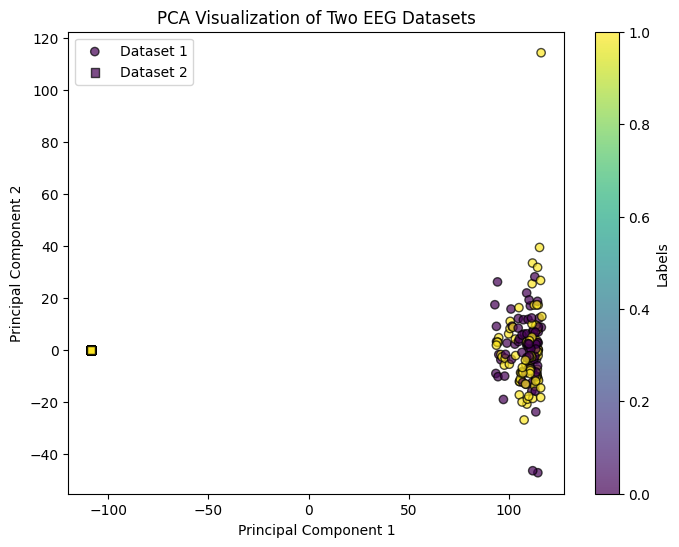

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 确保 `dataset1` 和 `dataset2` 已经正确初始化
# dataset1 = StrokePatientsMIDataset(root_path='path_to_dataset1', ...)  # 数据集1
# dataset2 = StrokePatientsMIDataset(root_path='path_to_dataset2', ...)  # 数据集2

# 预处理函数：展平 EEG 数据
def preprocess_dataset(dataset):
    eeg_data = []
    labels = []
    for i in range(len(dataset)):
        eeg_sample, label = dataset[i]
        eeg_data.append(eeg_sample.numpy().flatten())  # 展平为 1D
        labels.append(label)
    return np.array(eeg_data), np.array(labels)

# 预处理两个数据集
eeg_data1, labels1 = preprocess_dataset(dataset1)
eeg_data2, labels2 = preprocess_dataset(dataset2)

print("Dataset shapes:", eeg_data1.shape, eeg_data2.shape)

# 生成数据集标签 (0 表示 dataset1, 1 表示 dataset2)
dataset_labels1 = np.zeros(len(eeg_data1))  # 标记数据集1
dataset_labels2 = np.ones(len(eeg_data2))   # 标记数据集2

# 合并数据
eeg_data = np.vstack([eeg_data1, eeg_data2])
labels = np.concatenate([labels1, labels2])  # 真实的 labels
dataset_labels = np.concatenate([dataset_labels1, dataset_labels2])  # 数据集来源

# 标准化数据
scaler = StandardScaler()
eeg_data_scaled = scaler.fit_transform(eeg_data)

# PCA 降维
pca = PCA(n_components=2)
eeg_pca = pca.fit_transform(eeg_data_scaled)

# 可视化
plt.figure(figsize=(8, 6))

# 定义不同数据集的 marker 形状
markers = {0: 'o', 1: 's'}  # dataset1 用圆圈，dataset2 用方块
colors = labels.astype(float)  # 确保 labels 是浮点数以用于 colormap

# 遍历数据点
for dataset_type in [0, 1]:  # 0: dataset1, 1: dataset2
    mask = (dataset_labels == dataset_type)
    plt.scatter(eeg_pca[mask, 0], eeg_pca[mask, 1], 
                c=colors[mask], cmap='viridis', alpha=0.7,
                marker=markers[dataset_type], edgecolors='k', label=f'Dataset {dataset_type + 1}')

# 添加图例和颜色条
plt.colorbar(label="Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Two EEG Datasets")
plt.legend()
plt.show()



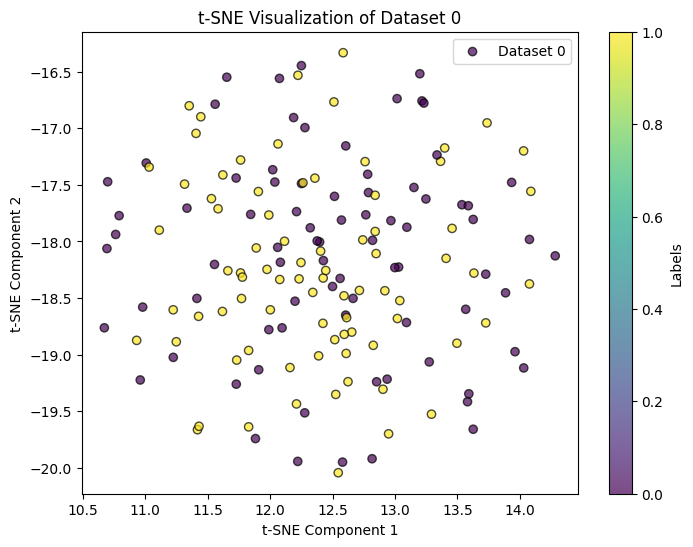

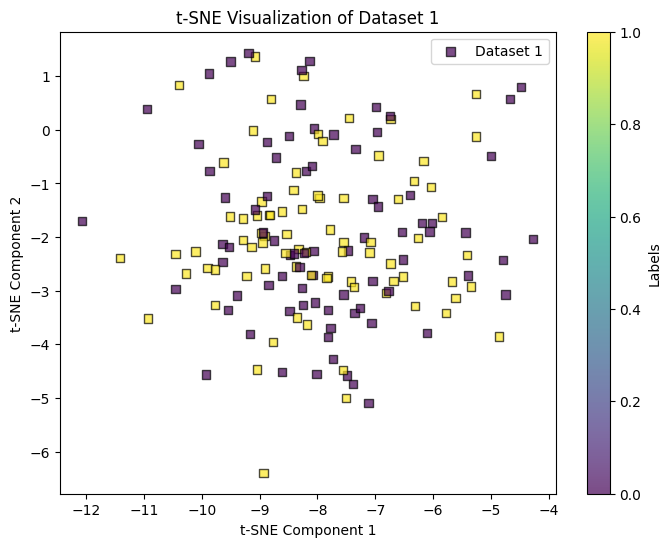

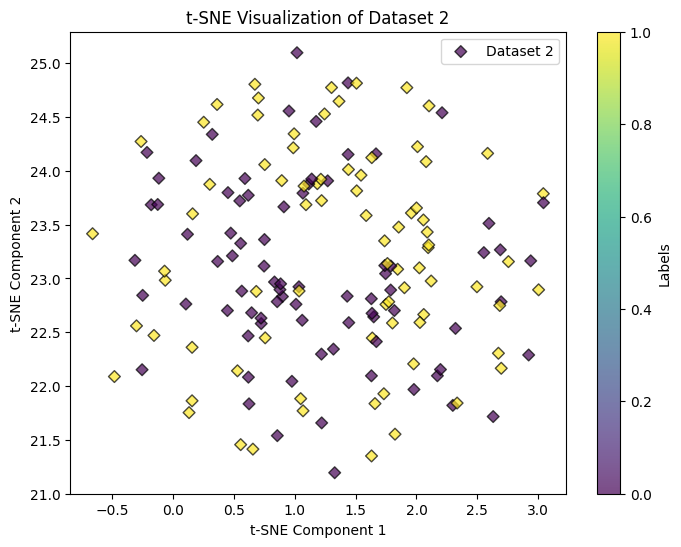

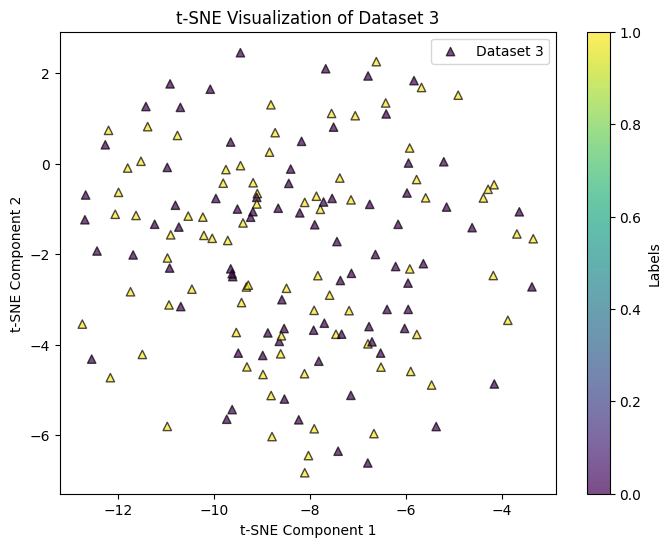

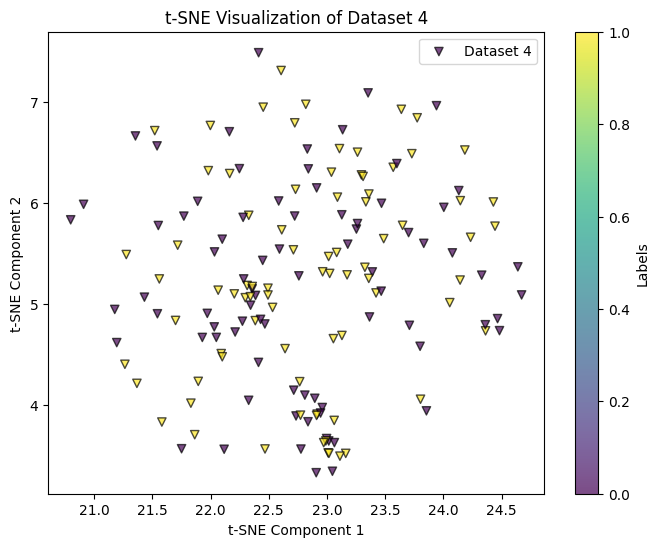

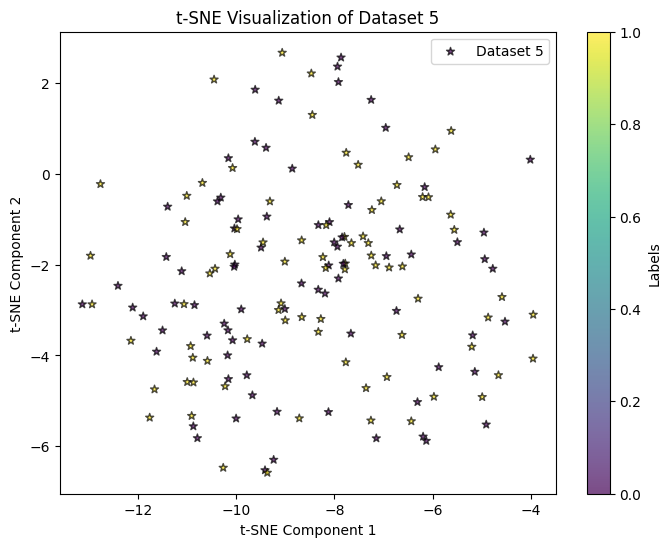

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# 预处理函数：展平 EEG 数据
def preprocess_dataset(dataset):
    eeg_data = []
    labels = []
    for i in range(len(dataset)):
        eeg_sample, label = dataset[i]
        eeg_data.append(eeg_sample.numpy().flatten())  # 展平为 1D
        labels.append(label)
    return np.array(eeg_data), np.array(labels)

# 预处理六个数据集
eeg_data_40mat, labels_40mat = preprocess_dataset(dataset_40mat)
eeg_data_40edf, labels_40edf = preprocess_dataset(dataset_40edf)
eeg_data_45mat, labels_45mat = preprocess_dataset(dataset_45mat)
eeg_data_45edf, labels_45edf = preprocess_dataset(dataset_45edf)
eeg_data_50mat, labels_50mat = preprocess_dataset(dataset_50mat)
eeg_data_50edf, labels_50edf = preprocess_dataset(dataset_50edf)

# 合并数据
eeg_data = np.vstack([eeg_data_40mat, eeg_data_40edf, eeg_data_45mat, 
                       eeg_data_45edf, eeg_data_50mat, eeg_data_50edf])
labels = np.concatenate([labels_40mat, labels_40edf, labels_45mat, 
                         labels_45edf, labels_50mat, labels_50edf])

# 生成数据集标签 (0~5 分别表示六个数据集)
dataset_labels = np.concatenate([
    np.full(len(eeg_data_40mat), 0),  # 40mat
    np.full(len(eeg_data_40edf), 1),  # 40edf
    np.full(len(eeg_data_45mat), 2),  # 45mat
    np.full(len(eeg_data_45edf), 3),  # 45edf
    np.full(len(eeg_data_50mat), 4),  # 50mat
    np.full(len(eeg_data_50edf), 5)   # 50edf
])

# 标准化数据
scaler = StandardScaler()
eeg_data_scaled = scaler.fit_transform(eeg_data)

# t-SNE 降维
tsne = TSNE(n_components=2, random_state=42)
eeg_tsne = tsne.fit_transform(eeg_data_scaled)

# 定义不同数据集的 marker 形状
markers = {0: 'o', 1: 's', 2: 'D', 3: '^', 4: 'v', 5: '*'}  # 每个数据集一个形状
colors = labels.astype(float)  # 颜色表示 labels

# 分别绘制六个数据集的 t-SNE 结果
for dataset_type in range(6):  # 0~5 对应不同数据集
    plt.figure(figsize=(8, 6))
    mask = (dataset_labels == dataset_type)
    plt.scatter(eeg_tsne[mask, 0], eeg_tsne[mask, 1], 
                c=colors[mask], cmap='viridis', alpha=0.7,
                marker=markers[dataset_type], edgecolors='k', label=f'Dataset {dataset_type}')
    
    # 添加图例和颜色条
    plt.colorbar(label="Labels")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title(f"t-SNE Visualization of Dataset {dataset_type}")
    plt.legend()
    plt.show()


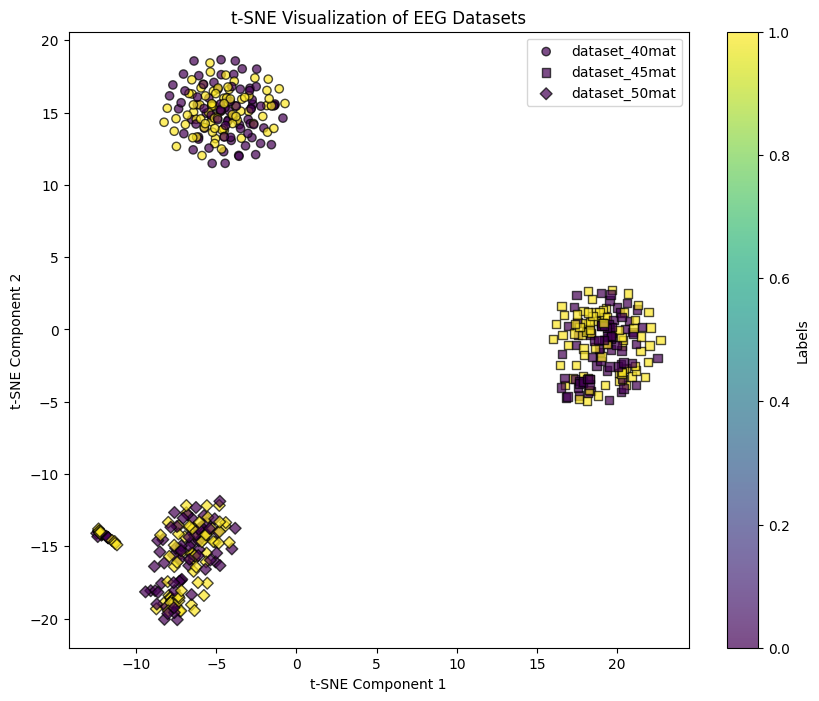

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# 预处理函数：展平 EEG 数据
def preprocess_dataset(dataset):
    eeg_data = []
    labels = []
    for i in range(len(dataset)):
        eeg_sample, label = dataset[i]
        eeg_data.append(eeg_sample.numpy().flatten())  # 展平为 1D 向量
        labels.append(label)
    return np.array(eeg_data), np.array(labels)

# 假定以下数据集已经正确初始化
# dataset_40mat, dataset_40edf, dataset_45mat, dataset_45edf, dataset_50mat, dataset_50edf

# 预处理各个数据集
datasets = {
    "dataset_40mat": preprocess_dataset(dataset_40mat),
    # "dataset_40edf": preprocess_dataset(dataset_40edf),
    "dataset_45mat": preprocess_dataset(dataset_45mat),
    # "dataset_45edf": preprocess_dataset(dataset_45edf),
    "dataset_50mat": preprocess_dataset(dataset_50mat),
    # "dataset_50edf": preprocess_dataset(dataset_50edf),
}

# 合并所有数据
eeg_data = np.vstack([data[0] for data in datasets.values()])
labels = np.concatenate([data[1] for data in datasets.values()])
dataset_labels = np.concatenate([np.full(len(data[0]), i) for i, data in enumerate(datasets.values())])

# 标准化数据
scaler = StandardScaler()
eeg_data_scaled = scaler.fit_transform(eeg_data)

# t-SNE 降维
tsne = TSNE(n_components=2, random_state=42)
eeg_tsne = tsne.fit_transform(eeg_data_scaled)

# 定义不同数据集的 marker
markers = ['o', 's', 'D', '^', 'v', '*']

plt.figure(figsize=(10, 8))
# colors 用于颜色映射，这里我们将 labels 转换为浮点数
colors = labels.astype(float)

# 遍历每个数据集，将其数据绘制在同一张图上
for i, (dataset_name, _) in enumerate(datasets.items()):
    mask = (dataset_labels == i)
    plt.scatter(eeg_tsne[mask, 0], eeg_tsne[mask, 1],
                c=colors[mask],
                cmap='viridis', alpha=0.7,
                marker=markers[i],
                edgecolors='k',
                label=dataset_name)

plt.colorbar(label="Labels")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of EEG Datasets")
plt.legend()
plt.show()



Dataset shapes: (160, 41472) (160, 41472)


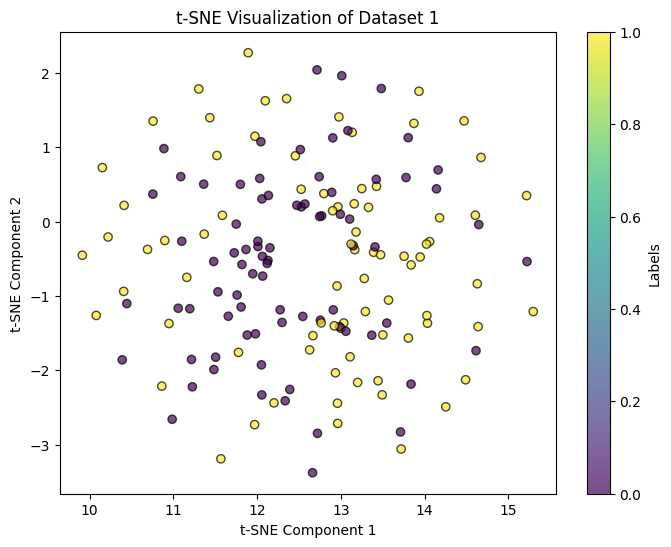

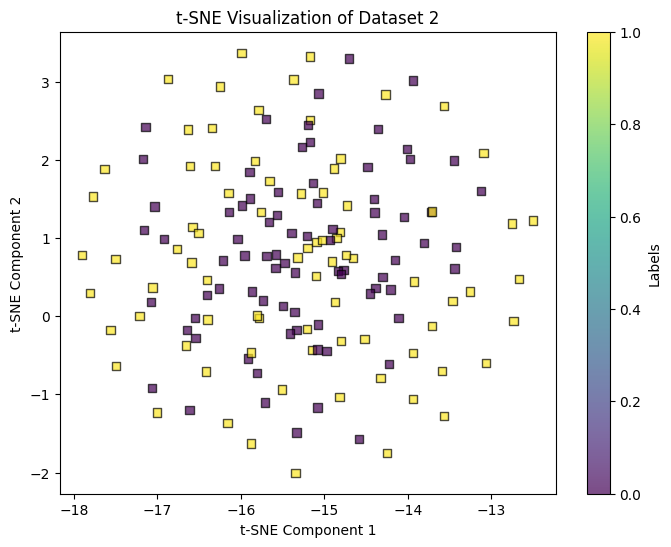

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# 确保 `dataset1` 和 `dataset2` 已经正确初始化
# dataset1 = StrokePatientsMIDataset(root_path='path_to_dataset1', ...)  # 数据集1
# dataset2 = StrokePatientsMIDataset(root_path='path_to_dataset2', ...)  # 数据集2

# 预处理函数：展平 EEG 数据
def preprocess_dataset(dataset):
    eeg_data = []
    labels = []
    for i in range(len(dataset)):
        eeg_sample, label = dataset[i]
        eeg_data.append(eeg_sample.numpy().flatten())  # 展平为 1D
        labels.append(label)
    return np.array(eeg_data), np.array(labels)

# 预处理两个数据集
eeg_data1, labels1 = preprocess_dataset(dataset1)
eeg_data2, labels2 = preprocess_dataset(dataset2)

print("Dataset shapes:", eeg_data1.shape, eeg_data2.shape)

# 合并数据
eeg_data = np.vstack([eeg_data1, eeg_data2])
labels = np.concatenate([labels1, labels2])  # 真实的 labels
dataset_labels = np.concatenate([np.zeros(len(eeg_data1)), np.ones(len(eeg_data2))])  # 数据集来源 (0: dataset1, 1: dataset2)

# 标准化数据
scaler = StandardScaler()
eeg_data_scaled = scaler.fit_transform(eeg_data)

# t-SNE 降维
tsne = TSNE(n_components=2, random_state=42)
eeg_tsne = tsne.fit_transform(eeg_data_scaled)

# 可视化 dataset1
plt.figure(figsize=(8, 6))
plt.scatter(eeg_tsne[:len(eeg_data1), 0], eeg_tsne[:len(eeg_data1), 1], c=labels1, cmap='viridis', alpha=0.7, marker='o', edgecolors='k')
plt.colorbar(label="Labels")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Dataset 1")
plt.show()

# 可视化 dataset2
plt.figure(figsize=(8, 6))
plt.scatter(eeg_tsne[len(eeg_data1):, 0], eeg_tsne[len(eeg_data1):, 1], c=labels2, cmap='viridis', alpha=0.7, marker='s', edgecolors='k')
plt.colorbar(label="Labels")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Dataset 2")
plt.show()


Dataset shape: (160, 41472)


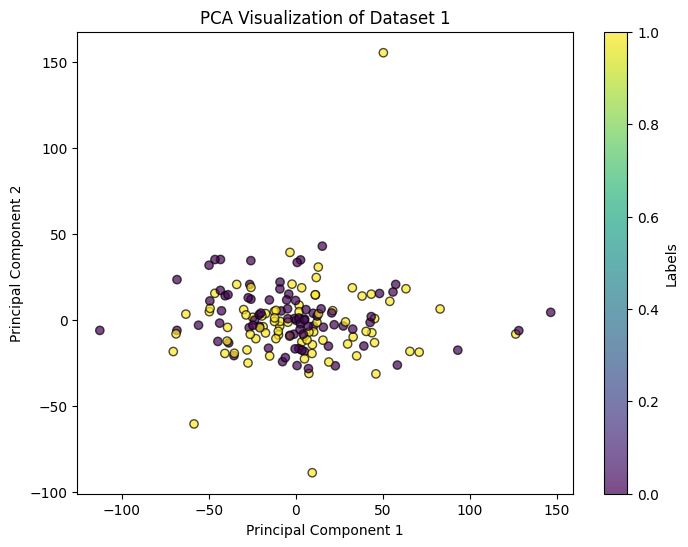

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 确保 `dataset1` 已经正确初始化
# dataset1 = StrokePatientsMIDataset(root_path='path_to_dataset1', ...)  # 数据集1

# 预处理函数：展平 EEG 数据
def preprocess_dataset(dataset):
    eeg_data = []
    labels = []
    for i in range(len(dataset)):
        eeg_sample, label = dataset[i]
        eeg_data.append(eeg_sample.numpy().flatten())  # 展平为 1D
        labels.append(label)
    return np.array(eeg_data), np.array(labels)

# 预处理 dataset1
eeg_data1, labels1 = preprocess_dataset(dataset2)

print("Dataset shape:", eeg_data1.shape)

# 合并数据集标签 (0 表示 dataset1)
dataset_labels1 = np.zeros(len(eeg_data1))  # 标记 dataset1

# 标准化数据
scaler = StandardScaler()
eeg_data_scaled = scaler.fit_transform(eeg_data1)

# PCA 降维
pca = PCA(n_components=2)
eeg_pca = pca.fit_transform(eeg_data_scaled)

# 可视化
plt.figure(figsize=(8, 6))

# 颜色由 labels 决定
colors = labels1.astype(float)  # 确保 labels 是浮点数

# 绘制 dataset1 的数据点
plt.scatter(eeg_pca[:, 0], eeg_pca[:, 1], c=colors, cmap='viridis', alpha=0.7, marker='o', edgecolors='k')

# 添加图例和颜色条
plt.colorbar(label="Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Dataset 1")
plt.show()


In [12]:
from torch.utils.data import DataLoader

# Create DataLoader
loader = DataLoader(
    dataset=dataset,
    batch_size=16,  # Adjust based on your needs
    shuffle=True,   # Shuffle data for training
    num_workers=4   # Parallel data loading; adjust based on CPU cores
)

# Iterate over the DataLoader
for batch in loader:
    signals, labels, subject_ids = batch  # Unpack the 3-tuple
    print(f"Signals shape: {signals.shape}")
    print(f"Labels: {labels}")
    print(f"Subject IDs: {subject_ids}")
    break  # Just print the first batch for testing

Signals shape: torch.Size([32, 128, 9, 9])
Labels: tensor([1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 0])
Subject IDs: ('45', '48', '48', '42', '40', '40', '50', '48', '45', '48', '42', '42', '40', '42', '50', '45', '48', '50', '48', '50', '45', '42', '40', '50', '40', '45', '40', '50', '42', '50', '42', '48')


In [7]:
import os
import shutil

def delete_folder_if_exists(target_folder_name):
    # 获取父文件夹中的所有内容
    parent_folder = os.getcwd()
    for folder_name in os.listdir(parent_folder):
        folder_path = os.path.join(parent_folder, folder_name)

        # 检查是否是文件夹并且名称是否匹配
        if os.path.isdir(folder_path) and folder_name == target_folder_name:
            try:
                # 删除目标文件夹
                shutil.rmtree(folder_path)
                print(f"已删除文件夹: {folder_path}")
            except Exception as e:
                print(f"删除文件夹 {folder_path} 时出错: {e}")

[2025-02-28 12:54:59] INFO (torcheeg/MainThread) 📊 | Create the split of train and test set.
[2025-02-28 12:54:59] INFO (torcheeg/MainThread) 😊 | Please set split_path to .torcheeg/model_selection_1740718499789_nGjqy for the next run, if you want to use the same setting for the experiment.
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarni

Epoch 0: 100%|██████████| 8/8 [00:01<00:00,  6.29it/s, loss=0.795, train_loss=0.657, train_accuracy=0.750]

Metric train_loss improved. New best score: 0.657


Epoch 0: 100%|██████████| 8/8 [00:01<00:00,  6.28it/s, loss=0.795, train_loss=0.657, train_accuracy=0.750]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-02-28 12:55:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.795 train_accuracy: 0.575 



Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 17.90it/s, loss=0.705, train_loss=0.400, train_accuracy=0.750]

Metric train_loss improved by 0.257 >= min_delta = 0.0. New best score: 0.400


Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 17.80it/s, loss=0.705, train_loss=0.400, train_accuracy=0.750]

[2025-02-28 12:55:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.616 train_accuracy: 0.642 



Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 18.53it/s, loss=0.64, train_loss=0.588, train_accuracy=0.625] 

[2025-02-28 12:55:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.604 train_accuracy: 0.658 



Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 18.46it/s, loss=0.563, train_loss=0.309, train_accuracy=0.875]

Metric train_loss improved by 0.091 >= min_delta = 0.0. New best score: 0.309


Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 18.38it/s, loss=0.563, train_loss=0.309, train_accuracy=0.875]

[2025-02-28 12:55:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.494 train_accuracy: 0.750 



Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 18.03it/s, loss=0.49, train_loss=0.391, train_accuracy=0.750] 

[2025-02-28 12:55:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.421 train_accuracy: 0.808 



Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 18.24it/s, loss=0.413, train_loss=0.341, train_accuracy=0.875]

[2025-02-28 12:55:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.355 train_accuracy: 0.883 



Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 18.23it/s, loss=0.335, train_loss=0.241, train_accuracy=0.875]

Metric train_loss improved by 0.068 >= min_delta = 0.0. New best score: 0.241


Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 18.14it/s, loss=0.335, train_loss=0.241, train_accuracy=0.875]

[2025-02-28 12:55:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.269 train_accuracy: 0.950 



Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.46it/s, loss=0.269, train_loss=0.107, train_accuracy=1.000]

Metric train_loss improved by 0.134 >= min_delta = 0.0. New best score: 0.107


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.34it/s, loss=0.269, train_loss=0.107, train_accuracy=1.000]

[2025-02-28 12:55:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.219 train_accuracy: 0.958 



Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 18.69it/s, loss=0.205, train_loss=0.118, train_accuracy=1.000]

[2025-02-28 12:55:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.164 train_accuracy: 0.983 



Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 18.57it/s, loss=0.164, train_loss=0.219, train_accuracy=0.875] 

[2025-02-28 12:55:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.144 train_accuracy: 0.967 



Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 18.56it/s, loss=0.136, train_loss=0.0638, train_accuracy=1.000]

Metric train_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.064


Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 18.49it/s, loss=0.136, train_loss=0.0638, train_accuracy=1.000]

[2025-02-28 12:55:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.123 train_accuracy: 0.958 



Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 18.40it/s, loss=0.105, train_loss=0.0137, train_accuracy=1.000]

Metric train_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.014


Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 18.31it/s, loss=0.105, train_loss=0.0137, train_accuracy=1.000]

[2025-02-28 12:55:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.069 train_accuracy: 0.992 



Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 18.10it/s, loss=0.073, train_loss=0.0221, train_accuracy=1.000] 

[2025-02-28 12:55:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.045 train_accuracy: 0.992 



Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 18.50it/s, loss=0.0382, train_loss=0.0307, train_accuracy=1.000]

[2025-02-28 12:55:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.032 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 18.45it/s, loss=0.0318, train_loss=0.0211, train_accuracy=1.000]

[2025-02-28 12:55:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.032 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 18.56it/s, loss=0.0264, train_loss=0.00443, train_accuracy=1.000]

Metric train_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.004


Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 18.44it/s, loss=0.0264, train_loss=0.00443, train_accuracy=1.000]

[2025-02-28 12:55:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.016 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 18.74it/s, loss=0.0171, train_loss=0.003, train_accuracy=1.000]  

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 18.61it/s, loss=0.0171, train_loss=0.003, train_accuracy=1.000]

[2025-02-28 12:55:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 18.78it/s, loss=0.00957, train_loss=0.0125, train_accuracy=1.000]

[2025-02-28 12:55:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 18.18it/s, loss=0.0103, train_loss=0.0206, train_accuracy=1.000]  

[2025-02-28 12:55:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.012 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 18.48it/s, loss=0.00847, train_loss=0.00264, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 18.41it/s, loss=0.00847, train_loss=0.00264, train_accuracy=1.000]

[2025-02-28 12:55:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 18.34it/s, loss=0.00586, train_loss=0.00109, train_accuracy=1.000] 

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.001


Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 18.24it/s, loss=0.00586, train_loss=0.00109, train_accuracy=1.000]

[2025-02-28 12:55:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 18.22it/s, loss=0.00498, train_loss=0.00059, train_accuracy=1.000] 

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 18.14it/s, loss=0.00498, train_loss=0.00059, train_accuracy=1.000]

[2025-02-28 12:55:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 18.62it/s, loss=0.00611, train_loss=0.00174, train_accuracy=1.000] 

[2025-02-28 12:55:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 18.55it/s, loss=0.00495, train_loss=0.000131, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 18.47it/s, loss=0.00495, train_loss=0.000131, train_accuracy=1.000]

[2025-02-28 12:55:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 18.58it/s, loss=0.00446, train_loss=0.00401, train_accuracy=1.000] 

[2025-02-28 12:55:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 18.42it/s, loss=0.00341, train_loss=0.000438, train_accuracy=1.000]

[2025-02-28 12:55:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 18.84it/s, loss=0.00235, train_loss=0.000223, train_accuracy=1.000]

[2025-02-28 12:55:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 18.48it/s, loss=0.00114, train_loss=0.000158, train_accuracy=1.000]

[2025-02-28 12:55:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 21.83it/s, loss=0.00125, train_loss=0.000215, train_accuracy=1.000]

[2025-02-28 12:55:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 22.20it/s, loss=0.0048, train_loss=0.00115, train_accuracy=1.000]  

[2025-02-28 12:55:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 0.992 



Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 18.39it/s, loss=0.0059, train_loss=0.00128, train_accuracy=1.000]  

[2025-02-28 12:55:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 18.65it/s, loss=0.00668, train_loss=0.00145, train_accuracy=1.000] 

[2025-02-28 12:55:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 18.47it/s, loss=0.00405, train_loss=0.000132, train_accuracy=1.000]

[2025-02-28 12:55:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 18.74it/s, loss=0.00246, train_loss=0.000138, train_accuracy=1.000]

[2025-02-28 12:55:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 18.71it/s, loss=0.00757, train_loss=0.00731, train_accuracy=1.000] 

[2025-02-28 12:55:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.015 train_accuracy: 0.992 



Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 16.50it/s, loss=0.0202, train_loss=0.0891, train_accuracy=1.000]  

[2025-02-28 12:55:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.034 train_accuracy: 0.992 



Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 16.71it/s, loss=0.0209, train_loss=0.000711, train_accuracy=1.000]

[2025-02-28 12:55:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.015 train_accuracy: 0.992 



Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 16.75it/s, loss=0.0251, train_loss=0.0169, train_accuracy=1.000]  

[2025-02-28 12:55:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.034 train_accuracy: 0.975 



Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 18.78it/s, loss=0.0203, train_loss=0.000552, train_accuracy=1.000]

[2025-02-28 12:55:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.015 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 19.06it/s, loss=0.0325, train_loss=0.394, train_accuracy=0.875]   

[2025-02-28 12:55:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.059 train_accuracy: 0.992 



Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 18.55it/s, loss=0.0326, train_loss=0.003, train_accuracy=1.000]   

[2025-02-28 12:55:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.015 train_accuracy: 0.992 



Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 18.67it/s, loss=0.0285, train_loss=0.0043, train_accuracy=1.000]  

[2025-02-28 12:55:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 18.54it/s, loss=0.00621, train_loss=0.00148, train_accuracy=1.000] 

[2025-02-28 12:55:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 18.20it/s, loss=0.00436, train_loss=0.00813, train_accuracy=1.000]

Monitored metric train_loss did not improve in the last 20 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 18.12it/s, loss=0.00436, train_loss=0.00813, train_accuracy=1.000]

[2025-02-28 12:55:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 17.99it/s, loss=0.00436, train_loss=0.00813, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 68.63it/s]

[2025-02-28 12:55:26] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 62.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          0.0004110981826670468
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 81.38it/s] 

[2025-02-28 12:55:27] INFO (torcheeg/MainThread) 
[Test] test_loss: 3.047 test_accuracy: 0.500 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 71.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 0.5
        test_loss           3.0471181869506836
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
已删除文件夹: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.51it/s, loss=0.977, train_loss=0.696, train_accuracy=0.625]

Metric train_loss improved. New best score: 0.696


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.44it/s, loss=0.977, train_loss=0.696, train_accuracy=0.625]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-02-28 12:55:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.977 train_accuracy: 0.517 



Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s, loss=0.813, train_loss=0.595, train_accuracy=0.750]

Metric train_loss improved by 0.101 >= min_delta = 0.0. New best score: 0.595


Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 18.14it/s, loss=0.813, train_loss=0.595, train_accuracy=0.750]

[2025-02-28 12:55:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.650 train_accuracy: 0.600 



Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 18.35it/s, loss=0.666, train_loss=0.632, train_accuracy=0.750]

[2025-02-28 12:55:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.565 train_accuracy: 0.717 



Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 18.29it/s, loss=0.554, train_loss=0.687, train_accuracy=0.625]

[2025-02-28 12:55:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.504 train_accuracy: 0.775 



Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 17.85it/s, loss=0.47, train_loss=0.299, train_accuracy=1.000] 

Metric train_loss improved by 0.296 >= min_delta = 0.0. New best score: 0.299


Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 17.76it/s, loss=0.47, train_loss=0.299, train_accuracy=1.000]

[2025-02-28 12:55:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.390 train_accuracy: 0.875 



Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 18.50it/s, loss=0.406, train_loss=0.276, train_accuracy=1.000]

Metric train_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.276


Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 18.39it/s, loss=0.406, train_loss=0.276, train_accuracy=1.000]

[2025-02-28 12:55:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.358 train_accuracy: 0.908 



Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 17.86it/s, loss=0.346, train_loss=0.309, train_accuracy=0.875]

[2025-02-28 12:55:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.306 train_accuracy: 0.933 



Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.40it/s, loss=0.289, train_loss=0.235, train_accuracy=1.000]

Metric train_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.235


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.28it/s, loss=0.289, train_loss=0.235, train_accuracy=1.000]

[2025-02-28 12:55:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.244 train_accuracy: 0.992 



Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 18.82it/s, loss=0.232, train_loss=0.132, train_accuracy=1.000]

Metric train_loss improved by 0.103 >= min_delta = 0.0. New best score: 0.132


Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 18.70it/s, loss=0.232, train_loss=0.132, train_accuracy=1.000]

[2025-02-28 12:55:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.172 train_accuracy: 0.992 



Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 18.31it/s, loss=0.167, train_loss=0.0661, train_accuracy=1.000]

Metric train_loss improved by 0.066 >= min_delta = 0.0. New best score: 0.066


Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 18.23it/s, loss=0.167, train_loss=0.0661, train_accuracy=1.000]

[2025-02-28 12:55:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.132 train_accuracy: 0.992 



Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 17.63it/s, loss=0.122, train_loss=0.0538, train_accuracy=1.000]

Metric train_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.054


Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 17.54it/s, loss=0.122, train_loss=0.0538, train_accuracy=1.000]

[2025-02-28 12:55:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.088 train_accuracy: 0.992 



Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 18.24it/s, loss=0.076, train_loss=0.0247, train_accuracy=1.000] 

Metric train_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.025


Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s, loss=0.076, train_loss=0.0247, train_accuracy=1.000]

[2025-02-28 12:55:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.052 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 18.09it/s, loss=0.0539, train_loss=0.040, train_accuracy=1.000] 

[2025-02-28 12:55:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.047 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s, loss=0.0398, train_loss=0.0041, train_accuracy=1.000]

Metric train_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.004


Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 18.14it/s, loss=0.0398, train_loss=0.0041, train_accuracy=1.000]

[2025-02-28 12:55:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.024 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 18.22it/s, loss=0.0288, train_loss=0.0525, train_accuracy=1.000]

[2025-02-28 12:55:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.030 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 17.96it/s, loss=0.0195, train_loss=0.0018, train_accuracy=1.000] 

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.002


Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 17.88it/s, loss=0.0195, train_loss=0.0018, train_accuracy=1.000]

[2025-02-28 12:55:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 18.47it/s, loss=0.0166, train_loss=0.0484, train_accuracy=1.000] 

[2025-02-28 12:55:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.017 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 18.68it/s, loss=0.0113, train_loss=0.000479, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 18.55it/s, loss=0.0113, train_loss=0.000479, train_accuracy=1.000]

[2025-02-28 12:55:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 18.62it/s, loss=0.012, train_loss=0.00156, train_accuracy=1.000]  

[2025-02-28 12:55:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 18.28it/s, loss=0.0121, train_loss=0.000546, train_accuracy=1.000]

[2025-02-28 12:55:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.014 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 18.23it/s, loss=0.0104, train_loss=0.00359, train_accuracy=1.000] 

[2025-02-28 12:55:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 18.53it/s, loss=0.00421, train_loss=0.000918, train_accuracy=1.000]

[2025-02-28 12:55:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 18.52it/s, loss=0.00291, train_loss=0.00532, train_accuracy=1.000] 

[2025-02-28 12:55:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 18.62it/s, loss=0.00418, train_loss=0.00048, train_accuracy=1.000] 

[2025-02-28 12:55:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 0.992 



Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 18.47it/s, loss=0.00416, train_loss=0.00123, train_accuracy=1.000] 

[2025-02-28 12:55:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 18.47it/s, loss=0.0078, train_loss=0.0143, train_accuracy=1.000]   

[2025-02-28 12:55:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.011 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 18.11it/s, loss=0.00684, train_loss=2.55e-5, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 18.03it/s, loss=0.00684, train_loss=2.55e-5, train_accuracy=1.000]

[2025-02-28 12:55:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 18.08it/s, loss=0.00427, train_loss=5.84e-5, train_accuracy=1.000] 

[2025-02-28 12:55:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 18.13it/s, loss=0.00223, train_loss=0.00108, train_accuracy=1.000] 

[2025-02-28 12:55:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 18.29it/s, loss=0.00208, train_loss=5.28e-5, train_accuracy=1.000] 

[2025-02-28 12:55:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 18.69it/s, loss=0.00261, train_loss=0.000617, train_accuracy=1.000]

[2025-02-28 12:55:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 18.56it/s, loss=0.00247, train_loss=0.00196, train_accuracy=1.000] 

[2025-02-28 12:55:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 18.70it/s, loss=0.00194, train_loss=0.000919, train_accuracy=1.000]

[2025-02-28 12:55:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 18.45it/s, loss=0.00152, train_loss=7.22e-5, train_accuracy=1.000] 

[2025-02-28 12:55:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 17.96it/s, loss=0.00241, train_loss=0.00179, train_accuracy=1.000] 

[2025-02-28 12:55:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 20.99it/s, loss=0.00209, train_loss=6.47e-5, train_accuracy=1.000] 

[2025-02-28 12:55:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 20.23it/s, loss=0.00161, train_loss=3.76e-5, train_accuracy=1.000] 

[2025-02-28 12:55:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 18.31it/s, loss=0.00184, train_loss=3.9e-6, train_accuracy=1.000]   

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 18.23it/s, loss=0.00184, train_loss=3.9e-6, train_accuracy=1.000]

[2025-02-28 12:55:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 17.94it/s, loss=0.00391, train_loss=0.0243, train_accuracy=1.000]  

[2025-02-28 12:55:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 18.11it/s, loss=0.0048, train_loss=1.78e-5, train_accuracy=1.000]  

[2025-02-28 12:55:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 18.19it/s, loss=0.00556, train_loss=0.00474, train_accuracy=1.000] 

[2025-02-28 12:55:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 0.992 



Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s, loss=0.00469, train_loss=2.91e-5, train_accuracy=1.000] 

[2025-02-28 12:55:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 18.07it/s, loss=0.00205, train_loss=0.000441, train_accuracy=1.000]

[2025-02-28 12:55:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 18.24it/s, loss=0.00294, train_loss=0.000879, train_accuracy=1.000]

[2025-02-28 12:55:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 18.23it/s, loss=0.0128, train_loss=0.125, train_accuracy=0.875]    

[2025-02-28 12:55:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.026 train_accuracy: 0.983 



Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 18.31it/s, loss=0.191, train_loss=2.680, train_accuracy=0.500]    

[2025-02-28 12:55:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.450 train_accuracy: 0.933 



Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 18.06it/s, loss=0.291, train_loss=0.0435, train_accuracy=1.000]

[2025-02-28 12:55:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.251 train_accuracy: 0.900 



Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s, loss=0.307, train_loss=0.0134, train_accuracy=1.000]

[2025-02-28 12:55:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.147 train_accuracy: 0.958 



Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 18.37it/s, loss=0.138, train_loss=0.0609, train_accuracy=1.000]

[2025-02-28 12:55:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.083 train_accuracy: 0.992 



Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 18.29it/s, loss=0.0556, train_loss=0.0608, train_accuracy=1.000] 

[2025-02-28 12:55:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.017 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 18.16it/s, loss=0.0556, train_loss=0.0608, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 59.87it/s]

[2025-02-28 12:55:52] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.020 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 57.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          0.019569963216781616
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 82.62it/s] 

[2025-02-28 12:55:53] INFO (torcheeg/MainThread) 
[Test] test_loss: 1.826 test_accuracy: 0.600 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 72.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.6000000238418579
        test_loss           1.8256348371505737
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
已删除文件夹: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 18.42it/s, loss=0.893, train_loss=0.800, train_accuracy=0.500]

Metric train_loss improved. New best score: 0.800


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 18.31it/s, loss=0.893, train_loss=0.800, train_accuracy=0.500]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-02-28 12:55:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.893 train_accuracy: 0.492 



Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 18.19it/s, loss=0.828, train_loss=0.733, train_accuracy=0.500]

Metric train_loss improved by 0.067 >= min_delta = 0.0. New best score: 0.733


Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 18.10it/s, loss=0.828, train_loss=0.733, train_accuracy=0.500]

[2025-02-28 12:55:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.762 train_accuracy: 0.583 



Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 17.79it/s, loss=0.742, train_loss=0.801, train_accuracy=0.500]

[2025-02-28 12:55:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.639 train_accuracy: 0.658 



Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 18.02it/s, loss=0.596, train_loss=0.530, train_accuracy=0.750]

Metric train_loss improved by 0.203 >= min_delta = 0.0. New best score: 0.530


Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 17.94it/s, loss=0.596, train_loss=0.530, train_accuracy=0.750]

[2025-02-28 12:55:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.537 train_accuracy: 0.708 



Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 18.38it/s, loss=0.527, train_loss=0.391, train_accuracy=0.875]

Metric train_loss improved by 0.140 >= min_delta = 0.0. New best score: 0.391


Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 18.27it/s, loss=0.527, train_loss=0.391, train_accuracy=0.875]

[2025-02-28 12:55:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.458 train_accuracy: 0.783 



Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 18.43it/s, loss=0.44, train_loss=0.283, train_accuracy=1.000] 

Metric train_loss improved by 0.108 >= min_delta = 0.0. New best score: 0.283


Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 18.37it/s, loss=0.44, train_loss=0.283, train_accuracy=1.000]

[2025-02-28 12:55:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.389 train_accuracy: 0.892 



Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 18.23it/s, loss=0.372, train_loss=0.394, train_accuracy=0.875]

[2025-02-28 12:55:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.335 train_accuracy: 0.933 



Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.27it/s, loss=0.331, train_loss=0.290, train_accuracy=1.000]

[2025-02-28 12:55:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.301 train_accuracy: 0.942 



Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 18.69it/s, loss=0.297, train_loss=0.266, train_accuracy=1.000]

Metric train_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.266


Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 18.57it/s, loss=0.297, train_loss=0.266, train_accuracy=1.000]

[2025-02-28 12:55:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.249 train_accuracy: 0.950 



Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 18.31it/s, loss=0.225, train_loss=0.108, train_accuracy=1.000]

Metric train_loss improved by 0.159 >= min_delta = 0.0. New best score: 0.108


Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s, loss=0.225, train_loss=0.108, train_accuracy=1.000]

[2025-02-28 12:55:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.173 train_accuracy: 0.983 



Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 18.12it/s, loss=0.163, train_loss=0.186, train_accuracy=1.000] 

[2025-02-28 12:55:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.131 train_accuracy: 0.992 



Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 17.92it/s, loss=0.122, train_loss=0.0652, train_accuracy=1.000]

Metric train_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.065


Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 17.83it/s, loss=0.122, train_loss=0.0652, train_accuracy=1.000]

[2025-02-28 12:56:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.093 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 18.34it/s, loss=0.097, train_loss=0.0829, train_accuracy=1.000] 

[2025-02-28 12:56:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.071 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 18.10it/s, loss=0.0633, train_loss=0.0818, train_accuracy=1.000]

[2025-02-28 12:56:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.054 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 18.06it/s, loss=0.0565, train_loss=0.103, train_accuracy=1.000] 

[2025-02-28 12:56:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.050 train_accuracy: 0.983 



Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 18.10it/s, loss=0.0362, train_loss=0.0148, train_accuracy=1.000] 

Metric train_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.015


Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 18.02it/s, loss=0.0362, train_loss=0.0148, train_accuracy=1.000]

[2025-02-28 12:56:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.014 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 18.23it/s, loss=0.0261, train_loss=0.0208, train_accuracy=1.000] 

[2025-02-28 12:56:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.016 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 18.41it/s, loss=0.013, train_loss=0.00269, train_accuracy=1.000] 

Metric train_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.003


Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 18.32it/s, loss=0.013, train_loss=0.00269, train_accuracy=1.000]

[2025-02-28 12:56:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 17.93it/s, loss=0.0116, train_loss=0.0405, train_accuracy=1.000] 

[2025-02-28 12:56:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.011 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 18.21it/s, loss=0.0085, train_loss=0.00174, train_accuracy=1.000] 

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 18.10it/s, loss=0.0085, train_loss=0.00174, train_accuracy=1.000]

[2025-02-28 12:56:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 18.57it/s, loss=0.00775, train_loss=0.00309, train_accuracy=1.000] 

[2025-02-28 12:56:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 18.13it/s, loss=0.00613, train_loss=0.00291, train_accuracy=1.000] 

[2025-02-28 12:56:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 18.40it/s, loss=0.0063, train_loss=0.00373, train_accuracy=1.000] 

[2025-02-28 12:56:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 17.93it/s, loss=0.00541, train_loss=0.00198, train_accuracy=1.000]

[2025-02-28 12:56:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 18.33it/s, loss=0.0045, train_loss=0.000693, train_accuracy=1.000] 

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 18.14it/s, loss=0.0045, train_loss=0.000693, train_accuracy=1.000]

[2025-02-28 12:56:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 18.47it/s, loss=0.00325, train_loss=0.00417, train_accuracy=1.000] 

[2025-02-28 12:56:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 18.20it/s, loss=0.00218, train_loss=0.000921, train_accuracy=1.000]

[2025-02-28 12:56:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 18.30it/s, loss=0.0028, train_loss=0.000782, train_accuracy=1.000] 

[2025-02-28 12:56:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 18.07it/s, loss=0.00321, train_loss=0.00768, train_accuracy=1.000] 

[2025-02-28 12:56:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 18.14it/s, loss=0.00219, train_loss=0.00197, train_accuracy=1.000] 

[2025-02-28 12:56:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 18.50it/s, loss=0.0032, train_loss=0.000498, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 18.31it/s, loss=0.0032, train_loss=0.000498, train_accuracy=1.000]

[2025-02-28 12:56:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 18.11it/s, loss=0.00372, train_loss=0.00539, train_accuracy=1.000] 

[2025-02-28 12:56:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 18.13it/s, loss=0.00419, train_loss=0.000197, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 18.04it/s, loss=0.00419, train_loss=0.000197, train_accuracy=1.000]

[2025-02-28 12:56:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 18.47it/s, loss=0.00428, train_loss=0.000809, train_accuracy=1.000]

[2025-02-28 12:56:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 18.17it/s, loss=0.00206, train_loss=0.00779, train_accuracy=1.000] 

[2025-02-28 12:56:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 18.08it/s, loss=0.00317, train_loss=0.0244, train_accuracy=1.000]  

[2025-02-28 12:56:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 18.60it/s, loss=0.00394, train_loss=5.98e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 18.51it/s, loss=0.00394, train_loss=5.98e-5, train_accuracy=1.000]

[2025-02-28 12:56:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 18.43it/s, loss=0.00344, train_loss=1.47e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 18.31it/s, loss=0.00344, train_loss=1.47e-5, train_accuracy=1.000]

[2025-02-28 12:56:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 18.16it/s, loss=0.00231, train_loss=0.000177, train_accuracy=1.000]

[2025-02-28 12:56:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 17.85it/s, loss=0.00221, train_loss=0.00961, train_accuracy=1.000] 

[2025-02-28 12:56:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 18.17it/s, loss=0.00245, train_loss=9.21e-5, train_accuracy=1.000] 

[2025-02-28 12:56:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 18.67it/s, loss=0.00166, train_loss=0.000134, train_accuracy=1.000]

[2025-02-28 12:56:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 19.38it/s, loss=0.000749, train_loss=1.14e-5, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 19.30it/s, loss=0.000749, train_loss=1.14e-5, train_accuracy=1.000]

[2025-02-28 12:56:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 20.57it/s, loss=0.000446, train_loss=0.000106, train_accuracy=1.000]

[2025-02-28 12:56:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 20.01it/s, loss=0.000498, train_loss=9e-6, train_accuracy=1.000]    

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 19.90it/s, loss=0.000498, train_loss=9e-6, train_accuracy=1.000]

[2025-02-28 12:56:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 18.76it/s, loss=0.000472, train_loss=1.12e-6, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 18.64it/s, loss=0.000472, train_loss=1.12e-6, train_accuracy=1.000]

[2025-02-28 12:56:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 18.52it/s, loss=0.000524, train_loss=0.000114, train_accuracy=1.000]

[2025-02-28 12:56:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 18.70it/s, loss=0.000517, train_loss=9.34e-5, train_accuracy=1.000] 

[2025-02-28 12:56:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 18.14it/s, loss=0.000346, train_loss=5.56e-5, train_accuracy=1.000] 

[2025-02-28 12:56:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 18.66it/s, loss=0.000755, train_loss=0.000166, train_accuracy=1.000]

[2025-02-28 12:56:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 18.54it/s, loss=0.000755, train_loss=0.000166, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 65.57it/s]

[2025-02-28 12:56:18] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 62.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          5.383899861044483e-06
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 79.86it/s]

[2025-02-28 12:56:19] INFO (torcheeg/MainThread) 
[Test] test_loss: 3.916 test_accuracy: 0.575 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 70.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.574999988079071
        test_loss           3.9155654907226562
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
已删除文件夹: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.72it/s, loss=0.898, train_loss=0.725, train_accuracy=0.500]

Metric train_loss improved. New best score: 0.725


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.65it/s, loss=0.898, train_loss=0.725, train_accuracy=0.500]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-02-28 12:56:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.898 train_accuracy: 0.492 



Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 18.18it/s, loss=0.815, train_loss=1.100, train_accuracy=0.250]

[2025-02-28 12:56:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.733 train_accuracy: 0.567 



Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 18.45it/s, loss=0.677, train_loss=0.729, train_accuracy=0.500]

[2025-02-28 12:56:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.548 train_accuracy: 0.725 



Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 18.83it/s, loss=0.554, train_loss=0.349, train_accuracy=0.750]

Metric train_loss improved by 0.376 >= min_delta = 0.0. New best score: 0.349


Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 18.71it/s, loss=0.554, train_loss=0.349, train_accuracy=0.750]

[2025-02-28 12:56:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.473 train_accuracy: 0.833 



Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 18.46it/s, loss=0.49, train_loss=0.385, train_accuracy=1.000] 

[2025-02-28 12:56:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.468 train_accuracy: 0.825 



Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 18.20it/s, loss=0.427, train_loss=0.307, train_accuracy=1.000]

Metric train_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.307


Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 18.09it/s, loss=0.427, train_loss=0.307, train_accuracy=1.000]

[2025-02-28 12:56:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.371 train_accuracy: 0.925 



Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 17.91it/s, loss=0.367, train_loss=0.341, train_accuracy=0.875]

[2025-02-28 12:56:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.328 train_accuracy: 0.892 



Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.74it/s, loss=0.295, train_loss=0.134, train_accuracy=1.000]

Metric train_loss improved by 0.173 >= min_delta = 0.0. New best score: 0.134


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.64it/s, loss=0.295, train_loss=0.134, train_accuracy=1.000]

[2025-02-28 12:56:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.247 train_accuracy: 0.958 



Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 18.75it/s, loss=0.237, train_loss=0.163, train_accuracy=1.000]

[2025-02-28 12:56:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.188 train_accuracy: 0.975 



Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 18.48it/s, loss=0.18, train_loss=0.129, train_accuracy=1.000]  

Metric train_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.129


Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 18.38it/s, loss=0.18, train_loss=0.129, train_accuracy=1.000]

[2025-02-28 12:56:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.141 train_accuracy: 0.983 



Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 17.97it/s, loss=0.128, train_loss=0.0277, train_accuracy=1.000]

Metric train_loss improved by 0.101 >= min_delta = 0.0. New best score: 0.028


Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 17.88it/s, loss=0.128, train_loss=0.0277, train_accuracy=1.000]

[2025-02-28 12:56:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.084 train_accuracy: 0.992 



Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 17.80it/s, loss=0.0819, train_loss=0.0282, train_accuracy=1.000]

[2025-02-28 12:56:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.068 train_accuracy: 0.992 



Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 18.09it/s, loss=0.0698, train_loss=0.0789, train_accuracy=1.000]

[2025-02-28 12:56:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.062 train_accuracy: 0.992 



Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 17.98it/s, loss=0.0508, train_loss=0.0175, train_accuracy=1.000]

Metric train_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.017


Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 17.89it/s, loss=0.0508, train_loss=0.0175, train_accuracy=1.000]

[2025-02-28 12:56:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.035 train_accuracy: 0.992 



Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 18.20it/s, loss=0.0333, train_loss=0.00316, train_accuracy=1.000]

Metric train_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.003


Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 18.09it/s, loss=0.0333, train_loss=0.00316, train_accuracy=1.000]

[2025-02-28 12:56:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.026 train_accuracy: 0.992 



Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 18.22it/s, loss=0.0223, train_loss=0.0294, train_accuracy=1.000] 

[2025-02-28 12:56:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.015 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 18.73it/s, loss=0.0105, train_loss=0.00243, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 18.61it/s, loss=0.0105, train_loss=0.00243, train_accuracy=1.000]

[2025-02-28 12:56:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 18.19it/s, loss=0.00817, train_loss=0.00426, train_accuracy=1.000]

[2025-02-28 12:56:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 18.26it/s, loss=0.00914, train_loss=0.00295, train_accuracy=1.000]

[2025-02-28 12:56:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.012 train_accuracy: 0.992 



Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 18.26it/s, loss=0.00926, train_loss=0.00848, train_accuracy=1.000]

[2025-02-28 12:56:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 18.08it/s, loss=0.0193, train_loss=0.268, train_accuracy=0.875]    

[2025-02-28 12:56:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.037 train_accuracy: 0.992 



Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 18.22it/s, loss=0.0264, train_loss=0.0256, train_accuracy=1.000] 

[2025-02-28 12:56:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.027 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 18.13it/s, loss=0.0374, train_loss=0.000589, train_accuracy=1.000]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.001


Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 18.04it/s, loss=0.0374, train_loss=0.000589, train_accuracy=1.000]

[2025-02-28 12:56:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.031 train_accuracy: 0.983 



Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 19.48it/s, loss=0.0188, train_loss=0.00179, train_accuracy=1.000] 

[2025-02-28 12:56:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 17.95it/s, loss=0.0116, train_loss=0.00314, train_accuracy=1.000] 

[2025-02-28 12:56:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 18.16it/s, loss=0.00888, train_loss=0.00177, train_accuracy=1.000] 

[2025-02-28 12:56:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.014 train_accuracy: 0.992 



Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 17.88it/s, loss=0.00747, train_loss=0.00135, train_accuracy=1.000] 

[2025-02-28 12:56:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 18.14it/s, loss=0.0017, train_loss=0.00103, train_accuracy=1.000]  

[2025-02-28 12:56:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 17.82it/s, loss=0.00227, train_loss=0.000706, train_accuracy=1.000]

[2025-02-28 12:56:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 18.20it/s, loss=0.00238, train_loss=0.00332, train_accuracy=1.000] 

[2025-02-28 12:56:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 18.26it/s, loss=0.00263, train_loss=0.000372, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 18.06it/s, loss=0.00263, train_loss=0.000372, train_accuracy=1.000]

[2025-02-28 12:56:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 18.33it/s, loss=0.00208, train_loss=0.000366, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 18.24it/s, loss=0.00208, train_loss=0.000366, train_accuracy=1.000]

[2025-02-28 12:56:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 18.52it/s, loss=0.00234, train_loss=0.00043, train_accuracy=1.000] 

[2025-02-28 12:56:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 18.88it/s, loss=0.00645, train_loss=0.00105, train_accuracy=1.000] 

[2025-02-28 12:56:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.012 train_accuracy: 0.992 



Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 20.86it/s, loss=0.00708, train_loss=0.00127, train_accuracy=1.000] 

[2025-02-28 12:56:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 19.58it/s, loss=0.00789, train_loss=0.00447, train_accuracy=1.000] 

[2025-02-28 12:56:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 18.42it/s, loss=0.00277, train_loss=0.000102, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 18.31it/s, loss=0.00277, train_loss=0.000102, train_accuracy=1.000]

[2025-02-28 12:56:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 18.11it/s, loss=0.00257, train_loss=0.00055, train_accuracy=1.000] 

[2025-02-28 12:56:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 18.17it/s, loss=0.00187, train_loss=0.00424, train_accuracy=1.000] 

[2025-02-28 12:56:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s, loss=0.00128, train_loss=0.00326, train_accuracy=1.000] 

[2025-02-28 12:56:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 18.35it/s, loss=0.00102, train_loss=8.66e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s, loss=0.00102, train_loss=8.66e-5, train_accuracy=1.000]

[2025-02-28 12:56:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 18.19it/s, loss=0.000848, train_loss=4.47e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 18.10it/s, loss=0.000848, train_loss=4.47e-5, train_accuracy=1.000]

[2025-02-28 12:56:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 18.21it/s, loss=0.000869, train_loss=0.000979, train_accuracy=1.000]

[2025-02-28 12:56:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 18.36it/s, loss=0.000749, train_loss=8.33e-6, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s, loss=0.000749, train_loss=8.33e-6, train_accuracy=1.000]

[2025-02-28 12:56:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 18.42it/s, loss=0.000698, train_loss=0.000439, train_accuracy=1.000]

[2025-02-28 12:56:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 18.28it/s, loss=0.00072, train_loss=1.27e-5, train_accuracy=1.000]  

[2025-02-28 12:56:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 18.04it/s, loss=0.000981, train_loss=0.000189, train_accuracy=1.000]

[2025-02-28 12:56:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 18.36it/s, loss=0.000821, train_loss=0.00103, train_accuracy=1.000] 

[2025-02-28 12:56:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 17.94it/s, loss=0.000624, train_loss=0.00253, train_accuracy=1.000] 

[2025-02-28 12:56:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 18.24it/s, loss=0.000616, train_loss=0.000299, train_accuracy=1.000]

[2025-02-28 12:56:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 18.12it/s, loss=0.000616, train_loss=0.000299, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 59.87it/s]

[2025-02-28 12:56:44] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 57.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss         1.6222516933339648e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 76.18it/s]

[2025-02-28 12:56:45] INFO (torcheeg/MainThread) 
[Test] test_loss: 2.925 test_accuracy: 0.550 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 67.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.550000011920929
        test_loss            2.924712896347046
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
已删除文件夹: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.06it/s, loss=0.801, train_loss=0.786, train_accuracy=0.500]

Metric train_loss improved. New best score: 0.786


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 16.99it/s, loss=0.801, train_loss=0.786, train_accuracy=0.500]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-02-28 12:56:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.801 train_accuracy: 0.492 



Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 18.34it/s, loss=0.772, train_loss=0.977, train_accuracy=0.375]

[2025-02-28 12:56:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.743 train_accuracy: 0.558 



Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 18.09it/s, loss=0.703, train_loss=0.616, train_accuracy=0.625]

Metric train_loss improved by 0.170 >= min_delta = 0.0. New best score: 0.616


Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 18.00it/s, loss=0.703, train_loss=0.616, train_accuracy=0.625]

[2025-02-28 12:56:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.665 train_accuracy: 0.592 



Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 18.14it/s, loss=0.629, train_loss=0.515, train_accuracy=0.625]

Metric train_loss improved by 0.101 >= min_delta = 0.0. New best score: 0.515


Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 18.03it/s, loss=0.629, train_loss=0.515, train_accuracy=0.625]

[2025-02-28 12:56:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.541 train_accuracy: 0.700 



Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 18.02it/s, loss=0.579, train_loss=0.479, train_accuracy=0.625]

Metric train_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.479


Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 17.94it/s, loss=0.579, train_loss=0.479, train_accuracy=0.625]

[2025-02-28 12:56:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.590 train_accuracy: 0.633 



Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 18.24it/s, loss=0.533, train_loss=0.504, train_accuracy=0.750]

[2025-02-28 12:56:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.479 train_accuracy: 0.792 



Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 18.37it/s, loss=0.489, train_loss=0.386, train_accuracy=0.875]

Metric train_loss improved by 0.093 >= min_delta = 0.0. New best score: 0.386


Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 18.26it/s, loss=0.489, train_loss=0.386, train_accuracy=0.875]

[2025-02-28 12:56:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.396 train_accuracy: 0.842 



Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.59it/s, loss=0.387, train_loss=0.294, train_accuracy=0.875]

Metric train_loss improved by 0.092 >= min_delta = 0.0. New best score: 0.294


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.47it/s, loss=0.387, train_loss=0.294, train_accuracy=0.875]

[2025-02-28 12:56:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.346 train_accuracy: 0.908 



Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 17.51it/s, loss=0.335, train_loss=0.298, train_accuracy=0.875]

[2025-02-28 12:56:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.291 train_accuracy: 0.892 



Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 18.02it/s, loss=0.277, train_loss=0.101, train_accuracy=1.000]

Metric train_loss improved by 0.193 >= min_delta = 0.0. New best score: 0.101


Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 17.84it/s, loss=0.277, train_loss=0.101, train_accuracy=1.000]

[2025-02-28 12:56:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.235 train_accuracy: 0.950 



Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 18.21it/s, loss=0.233, train_loss=0.217, train_accuracy=1.000]

[2025-02-28 12:56:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.218 train_accuracy: 0.950 



Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 18.13it/s, loss=0.177, train_loss=0.160, train_accuracy=1.000] 

[2025-02-28 12:56:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.125 train_accuracy: 0.992 



Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 18.47it/s, loss=0.126, train_loss=0.049, train_accuracy=1.000] 

Metric train_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.049


Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 18.36it/s, loss=0.126, train_loss=0.049, train_accuracy=1.000]

[2025-02-28 12:56:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.086 train_accuracy: 0.992 



Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 17.90it/s, loss=0.0921, train_loss=0.0954, train_accuracy=1.000]

[2025-02-28 12:56:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.085 train_accuracy: 0.983 



Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 16.98it/s, loss=0.0742, train_loss=0.065, train_accuracy=1.000] 

[2025-02-28 12:56:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.066 train_accuracy: 0.975 



Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 17.11it/s, loss=0.0639, train_loss=0.0188, train_accuracy=1.000] 

Metric train_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.019


Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 17.01it/s, loss=0.0639, train_loss=0.0188, train_accuracy=1.000]

[2025-02-28 12:56:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.046 train_accuracy: 0.975 



Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 18.21it/s, loss=0.0542, train_loss=0.238, train_accuracy=0.875] 

[2025-02-28 12:56:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.062 train_accuracy: 0.992 



Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 18.38it/s, loss=0.0469, train_loss=0.0635, train_accuracy=1.000]

[2025-02-28 12:56:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.036 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 17.59it/s, loss=0.0485, train_loss=0.224, train_accuracy=0.875]  

[2025-02-28 12:56:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.041 train_accuracy: 0.992 



Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 15.71it/s, loss=0.044, train_loss=0.0354, train_accuracy=1.000]  

[2025-02-28 12:56:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.052 train_accuracy: 0.975 



Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 15.61it/s, loss=0.0502, train_loss=0.0689, train_accuracy=1.000] 

[2025-02-28 12:56:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.041 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 18.07it/s, loss=0.0417, train_loss=0.00543, train_accuracy=1.000]

Metric train_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.005


Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 17.98it/s, loss=0.0417, train_loss=0.00543, train_accuracy=1.000]

[2025-02-28 12:56:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.018 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 16.87it/s, loss=0.0202, train_loss=0.000981, train_accuracy=1.000]

Metric train_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.001


Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 16.78it/s, loss=0.0202, train_loss=0.000981, train_accuracy=1.000]

[2025-02-28 12:56:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.022 train_accuracy: 0.992 



Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 17.74it/s, loss=0.0183, train_loss=0.00298, train_accuracy=1.000] 

[2025-02-28 12:56:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.018 train_accuracy: 0.992 



Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 18.58it/s, loss=0.0118, train_loss=0.0231, train_accuracy=1.000] 

[2025-02-28 12:56:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 18.80it/s, loss=0.0124, train_loss=0.0663, train_accuracy=1.000]  

[2025-02-28 12:56:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.011 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 18.49it/s, loss=0.00826, train_loss=0.0105, train_accuracy=1.000]  

[2025-02-28 12:56:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 18.62it/s, loss=0.00791, train_loss=0.0109, train_accuracy=1.000]  

[2025-02-28 12:56:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 18.03it/s, loss=0.0037, train_loss=0.000428, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 17.94it/s, loss=0.0037, train_loss=0.000428, train_accuracy=1.000]

[2025-02-28 12:57:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 18.94it/s, loss=0.00788, train_loss=0.000136, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 18.82it/s, loss=0.00788, train_loss=0.000136, train_accuracy=1.000]

[2025-02-28 12:57:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.015 train_accuracy: 0.992 



Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 18.65it/s, loss=0.0112, train_loss=0.000246, train_accuracy=1.000] 

[2025-02-28 12:57:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.012 train_accuracy: 0.992 



Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 18.60it/s, loss=0.0113, train_loss=0.00447, train_accuracy=1.000] 

[2025-02-28 12:57:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 18.13it/s, loss=0.00791, train_loss=0.0363, train_accuracy=1.000]  

[2025-02-28 12:57:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 18.89it/s, loss=0.00603, train_loss=0.0313, train_accuracy=1.000]  

[2025-02-28 12:57:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 20.17it/s, loss=0.0123, train_loss=0.000674, train_accuracy=1.000]

[2025-02-28 12:57:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.017 train_accuracy: 0.983 



Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 21.00it/s, loss=0.0133, train_loss=0.0126, train_accuracy=1.000]  

[2025-02-28 12:57:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 0.992 



Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 18.29it/s, loss=0.00881, train_loss=0.00751, train_accuracy=1.000]

[2025-02-28 12:57:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 18.06it/s, loss=0.00692, train_loss=0.000397, train_accuracy=1.000]

[2025-02-28 12:57:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 18.61it/s, loss=0.00487, train_loss=0.000181, train_accuracy=1.000]

[2025-02-28 12:57:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 18.40it/s, loss=0.00293, train_loss=0.000365, train_accuracy=1.000]

[2025-02-28 12:57:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 18.37it/s, loss=0.00337, train_loss=5.59e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 18.28it/s, loss=0.00337, train_loss=5.59e-5, train_accuracy=1.000]

[2025-02-28 12:57:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 17.75it/s, loss=0.00282, train_loss=0.000756, train_accuracy=1.000]

[2025-02-28 12:57:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 17.90it/s, loss=0.00538, train_loss=0.000943, train_accuracy=1.000]

[2025-02-28 12:57:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.011 train_accuracy: 0.992 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 17.74it/s, loss=0.0102, train_loss=6.04e-5, train_accuracy=1.000]  

[2025-02-28 12:57:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.014 train_accuracy: 0.992 



Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 17.87it/s, loss=0.00837, train_loss=5.96e-5, train_accuracy=1.000]

[2025-02-28 12:57:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 18.03it/s, loss=0.0108, train_loss=0.0149, train_accuracy=1.000]   

[2025-02-28 12:57:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.016 train_accuracy: 0.992 



Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 18.03it/s, loss=0.0246, train_loss=0.149, train_accuracy=0.875]   

[2025-02-28 12:57:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.045 train_accuracy: 0.983 



Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 18.10it/s, loss=0.0437, train_loss=0.000115, train_accuracy=1.000]

[2025-02-28 12:57:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.051 train_accuracy: 0.983 



Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s, loss=0.0486, train_loss=0.206, train_accuracy=0.875]   

[2025-02-28 12:57:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.046 train_accuracy: 0.983 



Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 17.88it/s, loss=0.0411, train_loss=0.00128, train_accuracy=1.000]

[2025-02-28 12:57:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.026 train_accuracy: 0.992 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 17.77it/s, loss=0.0411, train_loss=0.00128, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 62.86it/s]

[2025-02-28 12:57:11] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.013 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 60.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          0.013493647798895836
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 74.35it/s]

[2025-02-28 12:57:11] INFO (torcheeg/MainThread) 
[Test] test_loss: 2.638 test_accuracy: 0.550 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 66.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.550000011920929
        test_loss           2.6375043392181396
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
已删除文件夹: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.19it/s, loss=0.718, train_loss=0.596, train_accuracy=0.625]

Metric train_loss improved. New best score: 0.596


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.11it/s, loss=0.718, train_loss=0.596, train_accuracy=0.625]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-02-28 12:57:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.718 train_accuracy: 0.567 



Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 17.92it/s, loss=0.75, train_loss=0.932, train_accuracy=0.375] 

[2025-02-28 12:57:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.782 train_accuracy: 0.483 



Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 18.18it/s, loss=0.7, train_loss=0.616, train_accuracy=0.750]  

[2025-02-28 12:57:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.610 train_accuracy: 0.683 



Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 18.04it/s, loss=0.609, train_loss=0.357, train_accuracy=0.875]

Metric train_loss improved by 0.238 >= min_delta = 0.0. New best score: 0.357


Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 17.95it/s, loss=0.609, train_loss=0.357, train_accuracy=0.875]

[2025-02-28 12:57:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.530 train_accuracy: 0.700 



Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 18.26it/s, loss=0.549, train_loss=0.414, train_accuracy=0.750]

[2025-02-28 12:57:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.550 train_accuracy: 0.708 



Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 18.27it/s, loss=0.503, train_loss=0.604, train_accuracy=0.500]

[2025-02-28 12:57:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.464 train_accuracy: 0.800 



Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 18.38it/s, loss=0.452, train_loss=0.386, train_accuracy=0.875]

[2025-02-28 12:57:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.425 train_accuracy: 0.858 



Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.29it/s, loss=0.404, train_loss=0.296, train_accuracy=1.000]

Metric train_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.296


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.20it/s, loss=0.404, train_loss=0.296, train_accuracy=1.000]

[2025-02-28 12:57:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.334 train_accuracy: 0.908 



Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s, loss=0.333, train_loss=0.286, train_accuracy=0.875]

Metric train_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.286


Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 18.05it/s, loss=0.333, train_loss=0.286, train_accuracy=0.875]

[2025-02-28 12:57:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.279 train_accuracy: 0.925 



Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 18.01it/s, loss=0.267, train_loss=0.195, train_accuracy=0.875]

Metric train_loss improved by 0.091 >= min_delta = 0.0. New best score: 0.195


Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 17.88it/s, loss=0.267, train_loss=0.195, train_accuracy=0.875]

[2025-02-28 12:57:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.216 train_accuracy: 0.967 



Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 18.17it/s, loss=0.208, train_loss=0.203, train_accuracy=0.875]

[2025-02-28 12:57:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.167 train_accuracy: 0.967 



Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s, loss=0.15, train_loss=0.127, train_accuracy=1.000]  

Metric train_loss improved by 0.068 >= min_delta = 0.0. New best score: 0.127


Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 18.06it/s, loss=0.15, train_loss=0.127, train_accuracy=1.000]

[2025-02-28 12:57:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.102 train_accuracy: 0.975 



Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 18.20it/s, loss=0.102, train_loss=0.0541, train_accuracy=1.000]

Metric train_loss improved by 0.072 >= min_delta = 0.0. New best score: 0.054


Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 18.12it/s, loss=0.102, train_loss=0.0541, train_accuracy=1.000]

[2025-02-28 12:57:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.077 train_accuracy: 0.992 



Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 18.39it/s, loss=0.0697, train_loss=0.00801, train_accuracy=1.000]

Metric train_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.008


Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 18.27it/s, loss=0.0697, train_loss=0.00801, train_accuracy=1.000]

[2025-02-28 12:57:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.039 train_accuracy: 0.983 



Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 18.08it/s, loss=0.0397, train_loss=0.00105, train_accuracy=1.000]

Metric train_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.001


Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 18.02it/s, loss=0.0397, train_loss=0.00105, train_accuracy=1.000]

[2025-02-28 12:57:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.028 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 18.73it/s, loss=0.0286, train_loss=0.0345, train_accuracy=1.000] 

[2025-02-28 12:57:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.029 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 18.59it/s, loss=0.0296, train_loss=0.0067, train_accuracy=1.000] 

[2025-02-28 12:57:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.028 train_accuracy: 0.992 



Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 18.60it/s, loss=0.0184, train_loss=0.00143, train_accuracy=1.000]

[2025-02-28 12:57:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 18.03it/s, loss=0.0141, train_loss=0.00188, train_accuracy=1.000]

[2025-02-28 12:57:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 18.32it/s, loss=0.00892, train_loss=0.000781, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 18.23it/s, loss=0.00892, train_loss=0.000781, train_accuracy=1.000]

[2025-02-28 12:57:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 18.20it/s, loss=0.012, train_loss=0.0161, train_accuracy=1.000]    

[2025-02-28 12:57:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.020 train_accuracy: 0.992 



Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 18.46it/s, loss=0.0161, train_loss=0.000684, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 18.37it/s, loss=0.0161, train_loss=0.000684, train_accuracy=1.000]

[2025-02-28 12:57:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.016 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 18.13it/s, loss=0.0193, train_loss=0.00227, train_accuracy=1.000] 

[2025-02-28 12:57:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.019 train_accuracy: 0.992 



Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 18.27it/s, loss=0.0134, train_loss=0.0351, train_accuracy=1.000]  

[2025-02-28 12:57:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 17.93it/s, loss=0.0132, train_loss=2.24e-5, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 17.84it/s, loss=0.0132, train_loss=2.24e-5, train_accuracy=1.000]

[2025-02-28 12:57:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 18.27it/s, loss=0.0178, train_loss=0.000538, train_accuracy=1.000]

[2025-02-28 12:57:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.031 train_accuracy: 0.983 



Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 18.57it/s, loss=0.0327, train_loss=0.0434, train_accuracy=1.000]  

[2025-02-28 12:57:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.046 train_accuracy: 0.983 



Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 18.27it/s, loss=0.059, train_loss=0.0153, train_accuracy=1.000]   

[2025-02-28 12:57:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.072 train_accuracy: 0.958 



Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 18.14it/s, loss=0.0526, train_loss=0.0172, train_accuracy=1.000] 

[2025-02-28 12:57:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.050 train_accuracy: 0.967 



Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 18.37it/s, loss=0.0495, train_loss=0.0161, train_accuracy=1.000] 

[2025-02-28 12:57:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.036 train_accuracy: 0.992 



Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 18.26it/s, loss=0.0418, train_loss=0.103, train_accuracy=0.875]  

[2025-02-28 12:57:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.030 train_accuracy: 0.983 



Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 18.80it/s, loss=0.0289, train_loss=0.000941, train_accuracy=1.000]

[2025-02-28 12:57:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.019 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 18.99it/s, loss=0.0214, train_loss=0.000434, train_accuracy=1.000]

[2025-02-28 12:57:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 19.62it/s, loss=0.00765, train_loss=0.00395, train_accuracy=1.000]

[2025-02-28 12:57:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 20.62it/s, loss=0.00617, train_loss=0.0171, train_accuracy=1.000]  

[2025-02-28 12:57:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 16.81it/s, loss=0.006, train_loss=0.00352, train_accuracy=1.000]   

[2025-02-28 12:57:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 17.66it/s, loss=0.00559, train_loss=0.000845, train_accuracy=1.000]

[2025-02-28 12:57:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 17.91it/s, loss=0.00372, train_loss=0.0112, train_accuracy=1.000]  

[2025-02-28 12:57:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 16.31it/s, loss=0.00248, train_loss=0.000238, train_accuracy=1.000]

[2025-02-28 12:57:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 18.16it/s, loss=0.00229, train_loss=4.31e-5, train_accuracy=1.000] 

[2025-02-28 12:57:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 18.30it/s, loss=0.00161, train_loss=0.000139, train_accuracy=1.000]

[2025-02-28 12:57:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 18.35it/s, loss=0.00102, train_loss=0.000576, train_accuracy=1.000] 

[2025-02-28 12:57:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 18.02it/s, loss=0.0025, train_loss=0.00117, train_accuracy=1.000]   

[2025-02-28 12:57:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 17.93it/s, loss=0.00254, train_loss=0.000456, train_accuracy=1.000]

[2025-02-28 12:57:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 18.50it/s, loss=0.00138, train_loss=0.0053, train_accuracy=1.000]  

Monitored metric train_loss did not improve in the last 20 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 18.33it/s, loss=0.00138, train_loss=0.0053, train_accuracy=1.000]

[2025-02-28 12:57:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 18.23it/s, loss=0.00138, train_loss=0.0053, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 71.37it/s]

[2025-02-28 12:57:34] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 68.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          5.039802999817766e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 78.46it/s]

[2025-02-28 12:57:34] INFO (torcheeg/MainThread) 
[Test] test_loss: 3.996 test_accuracy: 0.500 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 68.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 0.5
        test_loss            3.995784044265747
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
已删除文件夹: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.71it/s, loss=0.901, train_loss=1.130, train_accuracy=0.250]

Metric train_loss improved. New best score: 1.126


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.60it/s, loss=0.901, train_loss=1.130, train_accuracy=0.250]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-02-28 12:57:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.901 train_accuracy: 0.542 



Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 17.87it/s, loss=0.815, train_loss=0.686, train_accuracy=0.750]

Metric train_loss improved by 0.440 >= min_delta = 0.0. New best score: 0.686


Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 17.77it/s, loss=0.815, train_loss=0.686, train_accuracy=0.750]

[2025-02-28 12:57:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.730 train_accuracy: 0.533 



Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 17.71it/s, loss=0.727, train_loss=0.627, train_accuracy=0.625]

Metric train_loss improved by 0.059 >= min_delta = 0.0. New best score: 0.627


Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 17.60it/s, loss=0.727, train_loss=0.627, train_accuracy=0.625]

[2025-02-28 12:57:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.694 train_accuracy: 0.600 



Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 17.69it/s, loss=0.703, train_loss=0.469, train_accuracy=0.750]

Metric train_loss improved by 0.158 >= min_delta = 0.0. New best score: 0.469


Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 17.60it/s, loss=0.703, train_loss=0.469, train_accuracy=0.750]

[2025-02-28 12:57:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.709 train_accuracy: 0.542 



Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 17.41it/s, loss=0.679, train_loss=0.556, train_accuracy=0.750]

[2025-02-28 12:57:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.668 train_accuracy: 0.558 



Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 17.98it/s, loss=0.576, train_loss=0.426, train_accuracy=0.875]

Metric train_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.426


Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 17.86it/s, loss=0.576, train_loss=0.426, train_accuracy=0.875]

[2025-02-28 12:57:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.478 train_accuracy: 0.808 



Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 18.36it/s, loss=0.479, train_loss=0.380, train_accuracy=0.875]

Metric train_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.380


Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 18.27it/s, loss=0.479, train_loss=0.380, train_accuracy=0.875]

[2025-02-28 12:57:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.408 train_accuracy: 0.950 



Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 17.98it/s, loss=0.409, train_loss=0.378, train_accuracy=1.000]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.378


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 17.81it/s, loss=0.409, train_loss=0.378, train_accuracy=1.000]

[2025-02-28 12:57:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.370 train_accuracy: 0.942 



Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 17.72it/s, loss=0.363, train_loss=0.241, train_accuracy=1.000]

Metric train_loss improved by 0.136 >= min_delta = 0.0. New best score: 0.241


Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 17.64it/s, loss=0.363, train_loss=0.241, train_accuracy=1.000]

[2025-02-28 12:57:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.333 train_accuracy: 0.925 



Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 17.89it/s, loss=0.317, train_loss=0.200, train_accuracy=1.000]

Metric train_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.200


Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 17.81it/s, loss=0.317, train_loss=0.200, train_accuracy=1.000]

[2025-02-28 12:57:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.276 train_accuracy: 0.967 



Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 18.28it/s, loss=0.256, train_loss=0.212, train_accuracy=1.000]

[2025-02-28 12:57:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.208 train_accuracy: 0.975 



Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 18.61it/s, loss=0.214, train_loss=0.210, train_accuracy=0.875]

[2025-02-28 12:57:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.195 train_accuracy: 0.967 



Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 17.97it/s, loss=0.158, train_loss=0.152, train_accuracy=0.875] 

Metric train_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.152


Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 17.87it/s, loss=0.158, train_loss=0.152, train_accuracy=0.875]

[2025-02-28 12:57:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.107 train_accuracy: 0.983 



Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s, loss=0.0975, train_loss=0.0332, train_accuracy=1.000]

Metric train_loss improved by 0.119 >= min_delta = 0.0. New best score: 0.033


Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 18.16it/s, loss=0.0975, train_loss=0.0332, train_accuracy=1.000]

[2025-02-28 12:57:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.054 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 18.35it/s, loss=0.0503, train_loss=0.0165, train_accuracy=1.000]

Metric train_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.017


Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 18.24it/s, loss=0.0503, train_loss=0.0165, train_accuracy=1.000]

[2025-02-28 12:57:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.025 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 18.41it/s, loss=0.0309, train_loss=0.0281, train_accuracy=1.000] 

[2025-02-28 12:57:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.028 train_accuracy: 0.992 



Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 18.02it/s, loss=0.0215, train_loss=0.00782, train_accuracy=1.000]

Metric train_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.008


Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 17.93it/s, loss=0.0215, train_loss=0.00782, train_accuracy=1.000]

[2025-02-28 12:57:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.016 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 17.26it/s, loss=0.013, train_loss=0.00206, train_accuracy=1.000] 

Metric train_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.002


Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 17.17it/s, loss=0.013, train_loss=0.00206, train_accuracy=1.000]

[2025-02-28 12:57:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 17.23it/s, loss=0.0124, train_loss=0.0134, train_accuracy=1.000] 

[2025-02-28 12:57:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.015 train_accuracy: 0.992 



Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 17.42it/s, loss=0.012, train_loss=0.0323, train_accuracy=1.000]  

[2025-02-28 12:57:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.011 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 17.35it/s, loss=0.0173, train_loss=0.107, train_accuracy=0.875]  

[2025-02-28 12:57:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.022 train_accuracy: 0.992 



Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 17.58it/s, loss=0.0245, train_loss=0.00358, train_accuracy=1.000]

[2025-02-28 12:57:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.033 train_accuracy: 0.992 



Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s, loss=0.0326, train_loss=0.00196, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 17.96it/s, loss=0.0326, train_loss=0.00196, train_accuracy=1.000]

[2025-02-28 12:57:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.032 train_accuracy: 0.983 



Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 18.17it/s, loss=0.0266, train_loss=0.00836, train_accuracy=1.000]

[2025-02-28 12:57:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.012 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 18.22it/s, loss=0.00749, train_loss=0.00223, train_accuracy=1.000]

[2025-02-28 12:57:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 18.22it/s, loss=0.00733, train_loss=0.000366, train_accuracy=1.000]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 18.12it/s, loss=0.00733, train_loss=0.000366, train_accuracy=1.000]

[2025-02-28 12:57:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 17.76it/s, loss=0.00815, train_loss=0.0582, train_accuracy=1.000]  

[2025-02-28 12:57:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.011 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 18.04it/s, loss=0.00953, train_loss=0.0061, train_accuracy=1.000]  

[2025-02-28 12:57:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 17.08it/s, loss=0.0113, train_loss=0.00255, train_accuracy=1.000] 

[2025-02-28 12:57:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 17.77it/s, loss=0.0133, train_loss=0.0207, train_accuracy=1.000]  

[2025-02-28 12:57:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.018 train_accuracy: 0.992 



Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 17.31it/s, loss=0.0156, train_loss=0.0104, train_accuracy=1.000]  

[2025-02-28 12:57:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.015 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 16.77it/s, loss=0.0375, train_loss=0.0192, train_accuracy=1.000]  

[2025-02-28 12:57:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.071 train_accuracy: 0.967 



Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 16.64it/s, loss=0.068, train_loss=0.042, train_accuracy=1.000]  

[2025-02-28 12:57:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.091 train_accuracy: 0.967 



Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 16.47it/s, loss=0.0782, train_loss=0.165, train_accuracy=0.875]  

[2025-02-28 12:57:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.074 train_accuracy: 0.967 



Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 15.40it/s, loss=0.0791, train_loss=0.00217, train_accuracy=1.000] 

[2025-02-28 12:57:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.089 train_accuracy: 0.975 



Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 16.03it/s, loss=0.0596, train_loss=0.0497, train_accuracy=1.000] 

[2025-02-28 12:57:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.037 train_accuracy: 0.983 



Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 17.70it/s, loss=0.0435, train_loss=0.0104, train_accuracy=1.000] 

[2025-02-28 12:57:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 17.36it/s, loss=0.0178, train_loss=0.0077, train_accuracy=1.000] 

[2025-02-28 12:57:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 17.09it/s, loss=0.0094, train_loss=0.00233, train_accuracy=1.000] 

[2025-02-28 12:57:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 17.39it/s, loss=0.00455, train_loss=0.00123, train_accuracy=1.000]

[2025-02-28 12:57:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 17.30it/s, loss=0.00341, train_loss=0.0057, train_accuracy=1.000] 

[2025-02-28 12:57:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 17.48it/s, loss=0.00348, train_loss=0.0099, train_accuracy=1.000]  

[2025-02-28 12:57:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 17.86it/s, loss=0.00327, train_loss=0.000126, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 17.75it/s, loss=0.00327, train_loss=0.000126, train_accuracy=1.000]

[2025-02-28 12:57:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 17.29it/s, loss=0.00296, train_loss=0.00462, train_accuracy=1.000] 

[2025-02-28 12:57:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 18.21it/s, loss=0.0033, train_loss=0.00108, train_accuracy=1.000]  

[2025-02-28 12:57:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 18.87it/s, loss=0.00373, train_loss=7.43e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 18.75it/s, loss=0.00373, train_loss=7.43e-5, train_accuracy=1.000]

[2025-02-28 12:57:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 17.76it/s, loss=0.00468, train_loss=0.0177, train_accuracy=1.000]  

[2025-02-28 12:57:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 17.84it/s, loss=0.00349, train_loss=5.58e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 17.74it/s, loss=0.00349, train_loss=5.58e-5, train_accuracy=1.000]

[2025-02-28 12:57:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 18.10it/s, loss=0.00325, train_loss=0.000397, train_accuracy=1.000]

[2025-02-28 12:57:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 17.79it/s, loss=0.00227, train_loss=0.000218, train_accuracy=1.000]

[2025-02-28 12:57:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 17.67it/s, loss=0.00227, train_loss=0.000218, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 74.02it/s]

[2025-02-28 12:58:00] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 70.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss         0.00011773520236602053
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 85.16it/s] 

[2025-02-28 12:58:00] INFO (torcheeg/MainThread) 
[Test] test_loss: 4.292 test_accuracy: 0.400 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 74.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.4000000059604645
        test_loss            4.292111396789551
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
已删除文件夹: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.94it/s, loss=0.809, train_loss=0.498, train_accuracy=1.000]

Metric train_loss improved. New best score: 0.498


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.86it/s, loss=0.809, train_loss=0.498, train_accuracy=1.000]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-02-28 12:58:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.809 train_accuracy: 0.533 



Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 18.05it/s, loss=0.761, train_loss=0.729, train_accuracy=0.625]

[2025-02-28 12:58:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.713 train_accuracy: 0.533 



Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 17.84it/s, loss=0.7, train_loss=0.667, train_accuracy=0.625]  

[2025-02-28 12:58:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.643 train_accuracy: 0.700 



Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s, loss=0.645, train_loss=0.437, train_accuracy=0.875]

Metric train_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.437


Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 18.07it/s, loss=0.645, train_loss=0.437, train_accuracy=0.875]

[2025-02-28 12:58:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.593 train_accuracy: 0.650 



Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 18.36it/s, loss=0.559, train_loss=0.691, train_accuracy=0.500]

[2025-02-28 12:58:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.515 train_accuracy: 0.817 



Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 18.34it/s, loss=0.517, train_loss=0.484, train_accuracy=0.875]

[2025-02-28 12:58:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.505 train_accuracy: 0.767 



Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 18.50it/s, loss=0.474, train_loss=0.526, train_accuracy=0.750]

[2025-02-28 12:58:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.402 train_accuracy: 0.917 



Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.38it/s, loss=0.426, train_loss=0.348, train_accuracy=0.750]

Metric train_loss improved by 0.089 >= min_delta = 0.0. New best score: 0.348


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.30it/s, loss=0.426, train_loss=0.348, train_accuracy=0.750]

[2025-02-28 12:58:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.407 train_accuracy: 0.817 



Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 17.92it/s, loss=0.39, train_loss=0.288, train_accuracy=0.875] 

Metric train_loss improved by 0.060 >= min_delta = 0.0. New best score: 0.288


Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 17.83it/s, loss=0.39, train_loss=0.288, train_accuracy=0.875]

[2025-02-28 12:58:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.353 train_accuracy: 0.858 



Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 17.99it/s, loss=0.322, train_loss=0.235, train_accuracy=1.000]

Metric train_loss improved by 0.054 >= min_delta = 0.0. New best score: 0.235


Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 17.90it/s, loss=0.322, train_loss=0.235, train_accuracy=1.000]

[2025-02-28 12:58:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.256 train_accuracy: 0.950 



Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 18.26it/s, loss=0.257, train_loss=0.205, train_accuracy=1.000]

Metric train_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.205


Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 18.18it/s, loss=0.257, train_loss=0.205, train_accuracy=1.000]

[2025-02-28 12:58:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.225 train_accuracy: 0.983 



Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 18.36it/s, loss=0.19, train_loss=0.073, train_accuracy=1.000]  

Metric train_loss improved by 0.132 >= min_delta = 0.0. New best score: 0.073


Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 18.24it/s, loss=0.19, train_loss=0.073, train_accuracy=1.000]

[2025-02-28 12:58:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.136 train_accuracy: 0.983 



Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 17.95it/s, loss=0.146, train_loss=0.0977, train_accuracy=1.000]

[2025-02-28 12:58:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.117 train_accuracy: 0.975 



Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 18.41it/s, loss=0.092, train_loss=0.105, train_accuracy=1.000]  

[2025-02-28 12:58:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.061 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 18.35it/s, loss=0.0701, train_loss=0.0959, train_accuracy=1.000]

[2025-02-28 12:58:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.065 train_accuracy: 0.992 



Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 18.37it/s, loss=0.0543, train_loss=0.0132, train_accuracy=1.000]

Metric train_loss improved by 0.060 >= min_delta = 0.0. New best score: 0.013


Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 18.28it/s, loss=0.0543, train_loss=0.0132, train_accuracy=1.000]

[2025-02-28 12:58:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.043 train_accuracy: 0.992 



Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 18.26it/s, loss=0.0428, train_loss=0.0186, train_accuracy=1.000]

[2025-02-28 12:58:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.028 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 18.11it/s, loss=0.0287, train_loss=0.00497, train_accuracy=1.000]

Metric train_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.005


Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 18.05it/s, loss=0.0287, train_loss=0.00497, train_accuracy=1.000]

[2025-02-28 12:58:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.033 train_accuracy: 0.992 



Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 18.04it/s, loss=0.0247, train_loss=0.00473, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 17.96it/s, loss=0.0247, train_loss=0.00473, train_accuracy=1.000]

[2025-02-28 12:58:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.017 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s, loss=0.0146, train_loss=0.00695, train_accuracy=1.000]

[2025-02-28 12:58:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.014 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 18.59it/s, loss=0.0149, train_loss=0.00227, train_accuracy=1.000]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.002


Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 18.47it/s, loss=0.0149, train_loss=0.00227, train_accuracy=1.000]

[2025-02-28 12:58:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.011 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 18.54it/s, loss=0.011, train_loss=0.0293, train_accuracy=1.000]   

[2025-02-28 12:58:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 18.45it/s, loss=0.00931, train_loss=0.001, train_accuracy=1.000]  

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 18.37it/s, loss=0.00931, train_loss=0.001, train_accuracy=1.000]

[2025-02-28 12:58:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 18.04it/s, loss=0.00821, train_loss=0.00195, train_accuracy=1.000] 

[2025-02-28 12:58:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 0.992 



Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 18.18it/s, loss=0.00643, train_loss=0.00285, train_accuracy=1.000] 

[2025-02-28 12:58:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 18.10it/s, loss=0.00845, train_loss=0.00463, train_accuracy=1.000] 

[2025-02-28 12:58:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 18.32it/s, loss=0.00736, train_loss=0.0123, train_accuracy=1.000] 

[2025-02-28 12:58:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 18.45it/s, loss=0.00539, train_loss=0.00426, train_accuracy=1.000]

[2025-02-28 12:58:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 18.57it/s, loss=0.0091, train_loss=0.00014, train_accuracy=1.000]  

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 18.45it/s, loss=0.0091, train_loss=0.00014, train_accuracy=1.000]

[2025-02-28 12:58:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.015 train_accuracy: 0.992 



Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 18.47it/s, loss=0.0156, train_loss=0.110, train_accuracy=0.875]   

[2025-02-28 12:58:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.021 train_accuracy: 0.992 



Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 18.22it/s, loss=0.0145, train_loss=0.0286, train_accuracy=1.000] 

[2025-02-28 12:58:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 0.992 



Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 18.22it/s, loss=0.0428, train_loss=9.72e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 18.16it/s, loss=0.0428, train_loss=9.72e-5, train_accuracy=1.000]

[2025-02-28 12:58:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.075 train_accuracy: 0.967 



Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 18.16it/s, loss=0.103, train_loss=0.319, train_accuracy=0.875]    

[2025-02-28 12:58:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.176 train_accuracy: 0.958 



Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 18.27it/s, loss=0.127, train_loss=0.0428, train_accuracy=1.000]

[2025-02-28 12:58:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.067 train_accuracy: 0.975 



Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 18.61it/s, loss=0.0937, train_loss=0.131, train_accuracy=0.875] 

[2025-02-28 12:58:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.076 train_accuracy: 0.967 



Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 18.59it/s, loss=0.0568, train_loss=0.0414, train_accuracy=1.000] 

[2025-02-28 12:58:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.026 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 18.39it/s, loss=0.0442, train_loss=0.0505, train_accuracy=1.000] 

[2025-02-28 12:58:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.032 train_accuracy: 0.992 



Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 18.43it/s, loss=0.0225, train_loss=0.015, train_accuracy=1.000]  

[2025-02-28 12:58:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 17.91it/s, loss=0.0166, train_loss=0.00174, train_accuracy=1.000]

[2025-02-28 12:58:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 0.992 



Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 17.49it/s, loss=0.0104, train_loss=0.00456, train_accuracy=1.000] 

[2025-02-28 12:58:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 18.45it/s, loss=0.0155, train_loss=0.00151, train_accuracy=1.000] 

[2025-02-28 12:58:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.027 train_accuracy: 0.992 



Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 18.26it/s, loss=0.0149, train_loss=0.00502, train_accuracy=1.000]

[2025-02-28 12:58:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 18.64it/s, loss=0.00739, train_loss=0.00515, train_accuracy=1.000]

[2025-02-28 12:58:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.012 train_accuracy: 0.992 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 18.30it/s, loss=0.00689, train_loss=0.000829, train_accuracy=1.000]

[2025-02-28 12:58:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 18.41it/s, loss=0.00612, train_loss=0.00189, train_accuracy=1.000] 

[2025-02-28 12:58:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 1.000 



Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 18.14it/s, loss=0.00547, train_loss=0.000115, train_accuracy=1.000]

[2025-02-28 12:58:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 18.06it/s, loss=0.00442, train_loss=0.000266, train_accuracy=1.000]

[2025-02-28 12:58:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 18.12it/s, loss=0.00302, train_loss=0.000987, train_accuracy=1.000]

[2025-02-28 12:58:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 18.09it/s, loss=0.00286, train_loss=0.0039, train_accuracy=1.000]  

[2025-02-28 12:58:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 18.16it/s, loss=0.00404, train_loss=0.0239, train_accuracy=1.000]  

[2025-02-28 12:58:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 18.05it/s, loss=0.00404, train_loss=0.0239, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 66.18it/s]

[2025-02-28 12:58:24] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 62.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss         0.00014455022756010294
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 81.10it/s]

[2025-02-28 12:58:24] INFO (torcheeg/MainThread) 
[Test] test_loss: 3.379 test_accuracy: 0.400 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 71.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.4000000059604645
        test_loss           3.3792006969451904
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
已删除文件夹: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 18.00it/s, loss=0.805, train_loss=0.891, train_accuracy=0.500]

Metric train_loss improved. New best score: 0.891


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.88it/s, loss=0.805, train_loss=0.891, train_accuracy=0.500]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-02-28 12:58:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.805 train_accuracy: 0.542 



Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 18.68it/s, loss=0.735, train_loss=0.586, train_accuracy=0.625]

Metric train_loss improved by 0.305 >= min_delta = 0.0. New best score: 0.586


Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 18.58it/s, loss=0.735, train_loss=0.586, train_accuracy=0.625]

[2025-02-28 12:58:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.666 train_accuracy: 0.600 



Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 18.36it/s, loss=0.651, train_loss=0.518, train_accuracy=0.750]

Metric train_loss improved by 0.068 >= min_delta = 0.0. New best score: 0.518


Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 18.27it/s, loss=0.651, train_loss=0.518, train_accuracy=0.750]

[2025-02-28 12:58:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.528 train_accuracy: 0.767 



Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 18.24it/s, loss=0.553, train_loss=0.456, train_accuracy=0.875]

Metric train_loss improved by 0.062 >= min_delta = 0.0. New best score: 0.456


Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s, loss=0.553, train_loss=0.456, train_accuracy=0.875]

[2025-02-28 12:58:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.530 train_accuracy: 0.742 



Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 18.43it/s, loss=0.521, train_loss=0.393, train_accuracy=0.750]

Metric train_loss improved by 0.062 >= min_delta = 0.0. New best score: 0.393


Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 18.31it/s, loss=0.521, train_loss=0.393, train_accuracy=0.750]

[2025-02-28 12:58:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.472 train_accuracy: 0.725 



Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 18.72it/s, loss=0.452, train_loss=0.619, train_accuracy=0.500]

[2025-02-28 12:58:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.409 train_accuracy: 0.808 



Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 18.40it/s, loss=0.379, train_loss=0.320, train_accuracy=0.875]

Metric train_loss improved by 0.073 >= min_delta = 0.0. New best score: 0.320


Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 18.21it/s, loss=0.379, train_loss=0.320, train_accuracy=0.875]

[2025-02-28 12:58:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.317 train_accuracy: 0.900 



Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.07it/s, loss=0.317, train_loss=0.216, train_accuracy=1.000]

Metric train_loss improved by 0.104 >= min_delta = 0.0. New best score: 0.216


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 17.97it/s, loss=0.317, train_loss=0.216, train_accuracy=1.000]

[2025-02-28 12:58:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.264 train_accuracy: 0.933 



Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 18.14it/s, loss=0.251, train_loss=0.271, train_accuracy=1.000]

[2025-02-28 12:58:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.199 train_accuracy: 0.975 



Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 18.12it/s, loss=0.186, train_loss=0.0622, train_accuracy=1.000]

Metric train_loss improved by 0.154 >= min_delta = 0.0. New best score: 0.062


Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 18.03it/s, loss=0.186, train_loss=0.0622, train_accuracy=1.000]

[2025-02-28 12:58:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.136 train_accuracy: 0.975 



Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 18.31it/s, loss=0.133, train_loss=0.0774, train_accuracy=1.000]

[2025-02-28 12:58:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.100 train_accuracy: 0.992 



Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 18.02it/s, loss=0.0963, train_loss=0.0902, train_accuracy=1.000]

[2025-02-28 12:58:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.079 train_accuracy: 0.992 



Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 18.00it/s, loss=0.0678, train_loss=0.0366, train_accuracy=1.000]

Metric train_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.037


Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 17.91it/s, loss=0.0678, train_loss=0.0366, train_accuracy=1.000]

[2025-02-28 12:58:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.048 train_accuracy: 0.992 



Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 18.13it/s, loss=0.0511, train_loss=0.0172, train_accuracy=1.000]

Metric train_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.017


Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 18.04it/s, loss=0.0511, train_loss=0.0172, train_accuracy=1.000]

[2025-02-28 12:58:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.038 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 18.50it/s, loss=0.0338, train_loss=0.0494, train_accuracy=1.000] 

[2025-02-28 12:58:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.027 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 18.26it/s, loss=0.0273, train_loss=0.0124, train_accuracy=1.000] 

Metric train_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.012


Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 18.17it/s, loss=0.0273, train_loss=0.0124, train_accuracy=1.000]

[2025-02-28 12:58:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.022 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 18.32it/s, loss=0.0201, train_loss=0.00569, train_accuracy=1.000]

Metric train_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.006


Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 18.22it/s, loss=0.0201, train_loss=0.00569, train_accuracy=1.000]

[2025-02-28 12:58:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 18.05it/s, loss=0.00995, train_loss=0.0133, train_accuracy=1.000] 

[2025-02-28 12:58:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 18.45it/s, loss=0.00923, train_loss=0.00365, train_accuracy=1.000]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.004


Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 18.33it/s, loss=0.00923, train_loss=0.00365, train_accuracy=1.000]

[2025-02-28 12:58:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 18.44it/s, loss=0.00763, train_loss=0.00306, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 18.32it/s, loss=0.00763, train_loss=0.00306, train_accuracy=1.000]

[2025-02-28 12:58:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 18.17it/s, loss=0.00634, train_loss=0.00485, train_accuracy=1.000]

[2025-02-28 12:58:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 18.27it/s, loss=0.00624, train_loss=0.00107, train_accuracy=1.000]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.001


Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 18.18it/s, loss=0.00624, train_loss=0.00107, train_accuracy=1.000]

[2025-02-28 12:58:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 17.80it/s, loss=0.00579, train_loss=0.0016, train_accuracy=1.000]  

[2025-02-28 12:58:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 18.09it/s, loss=0.005, train_loss=0.00279, train_accuracy=1.000]  

[2025-02-28 12:58:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 18.39it/s, loss=0.00517, train_loss=0.000929, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 18.30it/s, loss=0.00517, train_loss=0.000929, train_accuracy=1.000]

[2025-02-28 12:58:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 18.34it/s, loss=0.00446, train_loss=0.000565, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 18.22it/s, loss=0.00446, train_loss=0.000565, train_accuracy=1.000]

[2025-02-28 12:58:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 18.53it/s, loss=0.00243, train_loss=0.0033, train_accuracy=1.000]  

[2025-02-28 12:58:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 18.39it/s, loss=0.0026, train_loss=0.00129, train_accuracy=1.000] 

[2025-02-28 12:58:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 18.12it/s, loss=0.00256, train_loss=0.00268, train_accuracy=1.000] 

[2025-02-28 12:58:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 17.85it/s, loss=0.00251, train_loss=0.00264, train_accuracy=1.000] 

[2025-02-28 12:58:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 18.14it/s, loss=0.00212, train_loss=0.000134, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 18.04it/s, loss=0.00212, train_loss=0.000134, train_accuracy=1.000]

[2025-02-28 12:58:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 17.74it/s, loss=0.00238, train_loss=0.00706, train_accuracy=1.000] 

[2025-02-28 12:58:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 17.65it/s, loss=0.0022, train_loss=0.00135, train_accuracy=1.000]  

[2025-02-28 12:58:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 18.24it/s, loss=0.0012, train_loss=1.96e-5, train_accuracy=1.000]  

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 18.13it/s, loss=0.0012, train_loss=1.96e-5, train_accuracy=1.000]

[2025-02-28 12:58:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 17.61it/s, loss=0.00112, train_loss=0.00498, train_accuracy=1.000]  

[2025-02-28 12:58:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 17.95it/s, loss=0.00138, train_loss=0.000612, train_accuracy=1.000]

[2025-02-28 12:58:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 18.05it/s, loss=0.00119, train_loss=0.000239, train_accuracy=1.000]

[2025-02-28 12:58:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 17.95it/s, loss=0.00036, train_loss=4.69e-5, train_accuracy=1.000]  

[2025-02-28 12:58:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 18.02it/s, loss=0.000489, train_loss=0.000286, train_accuracy=1.000]

[2025-02-28 12:58:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 17.60it/s, loss=0.000548, train_loss=6.99e-6, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 17.51it/s, loss=0.000548, train_loss=6.99e-6, train_accuracy=1.000]

[2025-02-28 12:58:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 17.81it/s, loss=0.000577, train_loss=0.000199, train_accuracy=1.000]

[2025-02-28 12:58:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 17.68it/s, loss=0.000635, train_loss=6.01e-5, train_accuracy=1.000] 

[2025-02-28 12:58:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 17.35it/s, loss=0.00121, train_loss=0.000194, train_accuracy=1.000] 

[2025-02-28 12:58:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 17.27it/s, loss=0.00167, train_loss=2.24e-5, train_accuracy=1.000] 

[2025-02-28 12:58:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 17.14it/s, loss=0.000959, train_loss=0.00051, train_accuracy=1.000] 

[2025-02-28 12:58:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 18.03it/s, loss=0.000985, train_loss=0.000956, train_accuracy=1.000]

[2025-02-28 12:58:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 18.08it/s, loss=0.000602, train_loss=9.72e-5, train_accuracy=1.000] 

[2025-02-28 12:58:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 17.96it/s, loss=0.000735, train_loss=5.42e-5, train_accuracy=1.000] 

[2025-02-28 12:58:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 17.81it/s, loss=0.000665, train_loss=0.00253, train_accuracy=1.000] 

[2025-02-28 12:58:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 18.14it/s, loss=0.000558, train_loss=6.07e-5, train_accuracy=1.000] 

[2025-02-28 12:58:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 18.01it/s, loss=0.000558, train_loss=6.07e-5, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 68.41it/s]

[2025-02-28 12:58:50] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 65.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          5.727592906623613e-06
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 76.70it/s]

[2025-02-28 12:58:50] INFO (torcheeg/MainThread) 
[Test] test_loss: 3.023 test_accuracy: 0.525 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 67.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.5249999761581421
        test_loss           3.0228919982910156
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
已删除文件夹: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.73it/s, loss=0.901, train_loss=1.230, train_accuracy=0.250]

Metric train_loss improved. New best score: 1.226


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.66it/s, loss=0.901, train_loss=1.230, train_accuracy=0.250]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-02-28 12:58:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.901 train_accuracy: 0.517 



Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 18.20it/s, loss=0.79, train_loss=0.495, train_accuracy=0.750] 

Metric train_loss improved by 0.730 >= min_delta = 0.0. New best score: 0.495


Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 18.08it/s, loss=0.79, train_loss=0.495, train_accuracy=0.750]

[2025-02-28 12:58:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.679 train_accuracy: 0.558 



Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 18.07it/s, loss=0.658, train_loss=0.560, train_accuracy=0.625]

[2025-02-28 12:58:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.533 train_accuracy: 0.750 



Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 18.16it/s, loss=0.531, train_loss=0.526, train_accuracy=0.875]

[2025-02-28 12:58:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.481 train_accuracy: 0.783 



Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 18.33it/s, loss=0.455, train_loss=0.323, train_accuracy=1.000]

Metric train_loss improved by 0.172 >= min_delta = 0.0. New best score: 0.323


Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 18.24it/s, loss=0.455, train_loss=0.323, train_accuracy=1.000]

[2025-02-28 12:58:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.393 train_accuracy: 0.917 



Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 18.24it/s, loss=0.402, train_loss=0.437, train_accuracy=0.875]

[2025-02-28 12:58:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.378 train_accuracy: 0.883 



Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 18.31it/s, loss=0.34, train_loss=0.243, train_accuracy=1.000] 

Metric train_loss improved by 0.080 >= min_delta = 0.0. New best score: 0.243


Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s, loss=0.34, train_loss=0.243, train_accuracy=1.000]

[2025-02-28 12:58:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.269 train_accuracy: 0.950 



Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.27it/s, loss=0.268, train_loss=0.269, train_accuracy=1.000]

[2025-02-28 12:58:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.208 train_accuracy: 0.983 



Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 17.82it/s, loss=0.207, train_loss=0.262, train_accuracy=0.875]

[2025-02-28 12:58:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.174 train_accuracy: 0.967 



Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 17.76it/s, loss=0.165, train_loss=0.108, train_accuracy=1.000] 

Metric train_loss improved by 0.135 >= min_delta = 0.0. New best score: 0.108


Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 17.65it/s, loss=0.165, train_loss=0.108, train_accuracy=1.000]

[2025-02-28 12:58:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.135 train_accuracy: 0.983 



Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s, loss=0.117, train_loss=0.0199, train_accuracy=1.000]

Metric train_loss improved by 0.088 >= min_delta = 0.0. New best score: 0.020


Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 18.06it/s, loss=0.117, train_loss=0.0199, train_accuracy=1.000]

[2025-02-28 12:58:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.072 train_accuracy: 0.992 



Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 17.55it/s, loss=0.0774, train_loss=0.0617, train_accuracy=1.000]

[2025-02-28 12:58:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.050 train_accuracy: 0.992 



Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 17.81it/s, loss=0.0509, train_loss=0.0189, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.019


Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 17.72it/s, loss=0.0509, train_loss=0.0189, train_accuracy=1.000]

[2025-02-28 12:58:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.053 train_accuracy: 0.983 



Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 17.70it/s, loss=0.0397, train_loss=0.0442, train_accuracy=1.000] 

[2025-02-28 12:58:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.023 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 17.84it/s, loss=0.0297, train_loss=0.0326, train_accuracy=1.000] 

[2025-02-28 12:58:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.022 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 18.09it/s, loss=0.0187, train_loss=0.000717, train_accuracy=1.000]

Metric train_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.001


Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 17.98it/s, loss=0.0187, train_loss=0.000717, train_accuracy=1.000]

[2025-02-28 12:58:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.011 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 17.32it/s, loss=0.0149, train_loss=0.00841, train_accuracy=1.000] 

[2025-02-28 12:59:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.019 train_accuracy: 0.983 



Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 17.98it/s, loss=0.0127, train_loss=0.00294, train_accuracy=1.000]

[2025-02-28 12:59:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 17.99it/s, loss=0.0123, train_loss=0.0395, train_accuracy=1.000] 

[2025-02-28 12:59:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.016 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 18.12it/s, loss=0.0111, train_loss=0.000479, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 18.03it/s, loss=0.0111, train_loss=0.000479, train_accuracy=1.000]

[2025-02-28 12:59:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 0.992 



Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 18.27it/s, loss=0.00998, train_loss=0.000437, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s, loss=0.00998, train_loss=0.000437, train_accuracy=1.000]

[2025-02-28 12:59:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 18.24it/s, loss=0.00631, train_loss=0.000827, train_accuracy=1.000]

[2025-02-28 12:59:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 18.56it/s, loss=0.00626, train_loss=0.0138, train_accuracy=1.000]  

[2025-02-28 12:59:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.011 train_accuracy: 0.992 



Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 18.29it/s, loss=0.00557, train_loss=0.000731, train_accuracy=1.000]

[2025-02-28 12:59:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 18.27it/s, loss=0.00505, train_loss=0.00022, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 18.18it/s, loss=0.00505, train_loss=0.00022, train_accuracy=1.000]

[2025-02-28 12:59:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 17.97it/s, loss=0.00359, train_loss=0.00304, train_accuracy=1.000] 

[2025-02-28 12:59:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 18.09it/s, loss=0.00123, train_loss=0.000212, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 17.98it/s, loss=0.00123, train_loss=0.000212, train_accuracy=1.000]

[2025-02-28 12:59:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 18.03it/s, loss=0.00497, train_loss=0.000206, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 17.94it/s, loss=0.00497, train_loss=0.000206, train_accuracy=1.000]

[2025-02-28 12:59:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 0.992 



Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 18.24it/s, loss=0.00542, train_loss=0.00198, train_accuracy=1.000] 

[2025-02-28 12:59:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 18.22it/s, loss=0.00441, train_loss=0.000165, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 18.13it/s, loss=0.00441, train_loss=0.000165, train_accuracy=1.000]

[2025-02-28 12:59:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 18.08it/s, loss=0.00093, train_loss=0.00113, train_accuracy=1.000] 

[2025-02-28 12:59:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 18.17it/s, loss=0.000928, train_loss=0.000566, train_accuracy=1.000]

[2025-02-28 12:59:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 18.53it/s, loss=0.000905, train_loss=0.00153, train_accuracy=1.000] 

[2025-02-28 12:59:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 18.10it/s, loss=0.00111, train_loss=0.00462, train_accuracy=1.000]  

[2025-02-28 12:59:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 18.03it/s, loss=0.0024, train_loss=0.000147, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 17.93it/s, loss=0.0024, train_loss=0.000147, train_accuracy=1.000]

[2025-02-28 12:59:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 18.26it/s, loss=0.00202, train_loss=0.00011, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s, loss=0.00202, train_loss=0.00011, train_accuracy=1.000]

[2025-02-28 12:59:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 18.63it/s, loss=0.00136, train_loss=1.15e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 18.51it/s, loss=0.00136, train_loss=1.15e-5, train_accuracy=1.000]

[2025-02-28 12:59:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 18.08it/s, loss=0.000411, train_loss=5.66e-5, train_accuracy=1.000] 

[2025-02-28 12:59:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 18.35it/s, loss=0.00107, train_loss=3.38e-5, train_accuracy=1.000]  

[2025-02-28 12:59:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 18.36it/s, loss=0.00126, train_loss=0.00194, train_accuracy=1.000]  

[2025-02-28 12:59:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 18.27it/s, loss=0.00144, train_loss=2.27e-5, train_accuracy=1.000] 

[2025-02-28 12:59:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 17.49it/s, loss=0.001, train_loss=0.000279, train_accuracy=1.000]   

[2025-02-28 12:59:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 17.66it/s, loss=0.000685, train_loss=0.000252, train_accuracy=1.000]

[2025-02-28 12:59:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 17.85it/s, loss=0.000616, train_loss=4.83e-5, train_accuracy=1.000] 

[2025-02-28 12:59:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 17.46it/s, loss=0.000723, train_loss=0.00204, train_accuracy=1.000] 

[2025-02-28 12:59:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 17.66it/s, loss=0.000731, train_loss=7.28e-5, train_accuracy=1.000] 

[2025-02-28 12:59:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 17.90it/s, loss=0.000474, train_loss=1.08e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 17.79it/s, loss=0.000474, train_loss=1.08e-5, train_accuracy=1.000]

[2025-02-28 12:59:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 16.79it/s, loss=0.00044, train_loss=0.000179, train_accuracy=1.000] 

[2025-02-28 12:59:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 17.44it/s, loss=0.000434, train_loss=5.35e-5, train_accuracy=1.000] 

[2025-02-28 12:59:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 17.89it/s, loss=0.000282, train_loss=0.000258, train_accuracy=1.000]

[2025-02-28 12:59:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 17.76it/s, loss=0.000282, train_loss=0.000258, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 68.63it/s]

[2025-02-28 12:59:16] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 65.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss         2.4763678538874956e-06
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 90.55it/s] 

[2025-02-28 12:59:16] INFO (torcheeg/MainThread) 
[Test] test_loss: 2.413 test_accuracy: 0.625 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 78.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                0.625
        test_loss            2.412830352783203
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
已删除文件夹: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.51it/s, loss=0.9, train_loss=1.180, train_accuracy=0.250]  

Metric train_loss improved. New best score: 1.182


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.44it/s, loss=0.9, train_loss=1.180, train_accuracy=0.250]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-02-28 12:59:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.900 train_accuracy: 0.458 



Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 17.91it/s, loss=0.761, train_loss=0.531, train_accuracy=0.750]

Metric train_loss improved by 0.651 >= min_delta = 0.0. New best score: 0.531


Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 17.83it/s, loss=0.761, train_loss=0.531, train_accuracy=0.750]

[2025-02-28 12:59:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.622 train_accuracy: 0.650 



Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 17.90it/s, loss=0.64, train_loss=0.608, train_accuracy=0.625] 

[2025-02-28 12:59:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.514 train_accuracy: 0.825 



Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 18.02it/s, loss=0.504, train_loss=0.476, train_accuracy=0.875]

Metric train_loss improved by 0.054 >= min_delta = 0.0. New best score: 0.476


Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 17.92it/s, loss=0.504, train_loss=0.476, train_accuracy=0.875]

[2025-02-28 12:59:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.456 train_accuracy: 0.842 



Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 18.12it/s, loss=0.434, train_loss=0.293, train_accuracy=1.000]

Metric train_loss improved by 0.184 >= min_delta = 0.0. New best score: 0.293


Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 18.01it/s, loss=0.434, train_loss=0.293, train_accuracy=1.000]

[2025-02-28 12:59:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.361 train_accuracy: 0.908 



Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 18.09it/s, loss=0.386, train_loss=0.427, train_accuracy=0.750]

[2025-02-28 12:59:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.373 train_accuracy: 0.867 



Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 18.21it/s, loss=0.336, train_loss=0.362, train_accuracy=0.875]

[2025-02-28 12:59:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.297 train_accuracy: 0.908 



Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.37it/s, loss=0.271, train_loss=0.188, train_accuracy=1.000]

Metric train_loss improved by 0.105 >= min_delta = 0.0. New best score: 0.188


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s, loss=0.271, train_loss=0.188, train_accuracy=1.000]

[2025-02-28 12:59:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.202 train_accuracy: 0.967 



Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 18.21it/s, loss=0.199, train_loss=0.105, train_accuracy=1.000] 

Metric train_loss improved by 0.082 >= min_delta = 0.0. New best score: 0.105


Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 18.12it/s, loss=0.199, train_loss=0.105, train_accuracy=1.000]

[2025-02-28 12:59:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.135 train_accuracy: 0.992 



Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 18.01it/s, loss=0.141, train_loss=0.210, train_accuracy=0.875] 

[2025-02-28 12:59:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.109 train_accuracy: 0.992 



Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 18.27it/s, loss=0.0987, train_loss=0.085, train_accuracy=1.000]

Metric train_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.085


Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s, loss=0.0987, train_loss=0.085, train_accuracy=1.000]

[2025-02-28 12:59:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.077 train_accuracy: 0.992 



Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 18.50it/s, loss=0.0748, train_loss=0.0832, train_accuracy=1.000]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.083


Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 18.38it/s, loss=0.0748, train_loss=0.0832, train_accuracy=1.000]

[2025-02-28 12:59:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.050 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 18.33it/s, loss=0.0517, train_loss=0.0304, train_accuracy=1.000]

Metric train_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.030


Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 18.21it/s, loss=0.0517, train_loss=0.0304, train_accuracy=1.000]

[2025-02-28 12:59:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.036 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 16.20it/s, loss=0.0321, train_loss=0.00574, train_accuracy=1.000]

Metric train_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.006


Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 16.10it/s, loss=0.0321, train_loss=0.00574, train_accuracy=1.000]

[2025-02-28 12:59:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.020 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 15.94it/s, loss=0.0184, train_loss=0.00517, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 15.87it/s, loss=0.0184, train_loss=0.00517, train_accuracy=1.000]

[2025-02-28 12:59:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 18.13it/s, loss=0.0109, train_loss=0.00214, train_accuracy=1.000]

Metric train_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.002


Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 18.01it/s, loss=0.0109, train_loss=0.00214, train_accuracy=1.000]

[2025-02-28 12:59:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 18.56it/s, loss=0.0069, train_loss=0.00251, train_accuracy=1.000] 

[2025-02-28 12:59:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 18.16it/s, loss=0.00513, train_loss=0.00911, train_accuracy=1.000] 

[2025-02-28 12:59:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 18.09it/s, loss=0.00485, train_loss=0.000498, train_accuracy=1.000]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 18.01it/s, loss=0.00485, train_loss=0.000498, train_accuracy=1.000]

[2025-02-28 12:59:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 18.16it/s, loss=0.00482, train_loss=9.26e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 18.05it/s, loss=0.00482, train_loss=9.26e-5, train_accuracy=1.000]

[2025-02-28 12:59:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 18.40it/s, loss=0.0037, train_loss=0.00113, train_accuracy=1.000]  

[2025-02-28 12:59:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 17.94it/s, loss=0.00216, train_loss=0.00179, train_accuracy=1.000] 

[2025-02-28 12:59:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 17.86it/s, loss=0.00272, train_loss=0.00302, train_accuracy=1.000] 

[2025-02-28 12:59:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 17.92it/s, loss=0.00417, train_loss=0.00563, train_accuracy=1.000]

[2025-02-28 12:59:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 17.60it/s, loss=0.00399, train_loss=0.00327, train_accuracy=1.000] 

[2025-02-28 12:59:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 17.62it/s, loss=0.00242, train_loss=0.000278, train_accuracy=1.000]

[2025-02-28 12:59:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 17.81it/s, loss=0.00148, train_loss=0.000218, train_accuracy=1.000]

[2025-02-28 12:59:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 18.07it/s, loss=0.00142, train_loss=0.000372, train_accuracy=1.000]

[2025-02-28 12:59:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 18.11it/s, loss=0.00133, train_loss=0.00319, train_accuracy=1.000] 

[2025-02-28 12:59:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 18.12it/s, loss=0.00117, train_loss=4.31e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 18.04it/s, loss=0.00117, train_loss=4.31e-5, train_accuracy=1.000]

[2025-02-28 12:59:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 17.58it/s, loss=0.00195, train_loss=0.000296, train_accuracy=1.000]

[2025-02-28 12:59:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 17.62it/s, loss=0.00174, train_loss=0.00102, train_accuracy=1.000] 

[2025-02-28 12:59:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 18.02it/s, loss=0.00362, train_loss=0.000104, train_accuracy=1.000]

[2025-02-28 12:59:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 17.96it/s, loss=0.00521, train_loss=0.000201, train_accuracy=1.000]

[2025-02-28 12:59:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 18.14it/s, loss=0.0296, train_loss=0.401, train_accuracy=0.625]    

[2025-02-28 12:59:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.066 train_accuracy: 0.967 



Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 17.97it/s, loss=0.0412, train_loss=0.0138, train_accuracy=1.000] 

[2025-02-28 12:59:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.034 train_accuracy: 0.992 



Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 17.68it/s, loss=0.0458, train_loss=0.0144, train_accuracy=1.000]  

[2025-02-28 12:59:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.030 train_accuracy: 0.983 



Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 18.19it/s, loss=0.0215, train_loss=0.0184, train_accuracy=1.000]  

[2025-02-28 12:59:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.019 train_accuracy: 0.992 



Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 18.31it/s, loss=0.0208, train_loss=0.00064, train_accuracy=1.000]

[2025-02-28 12:59:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 17.58it/s, loss=0.00914, train_loss=0.0392, train_accuracy=1.000] 

[2025-02-28 12:59:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 18.36it/s, loss=0.00832, train_loss=0.00217, train_accuracy=1.000] 

[2025-02-28 12:59:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 18.53it/s, loss=0.0121, train_loss=5.52e-5, train_accuracy=1.000]  

[2025-02-28 12:59:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.018 train_accuracy: 0.992 



Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 18.38it/s, loss=0.00815, train_loss=0.00178, train_accuracy=1.000] 

[2025-02-28 12:59:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 18.08it/s, loss=0.00644, train_loss=0.000362, train_accuracy=1.000]

[2025-02-28 12:59:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 18.22it/s, loss=0.00216, train_loss=0.000442, train_accuracy=1.000]

[2025-02-28 12:59:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 18.30it/s, loss=0.00291, train_loss=0.000482, train_accuracy=1.000]

[2025-02-28 12:59:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s, loss=0.00239, train_loss=0.000513, train_accuracy=1.000]

[2025-02-28 12:59:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 18.43it/s, loss=0.00182, train_loss=0.00454, train_accuracy=1.000] 

[2025-02-28 12:59:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 18.17it/s, loss=0.0021, train_loss=4.22e-5, train_accuracy=1.000]  

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 18.01it/s, loss=0.0021, train_loss=4.22e-5, train_accuracy=1.000]

[2025-02-28 12:59:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 18.18it/s, loss=0.00187, train_loss=7.49e-5, train_accuracy=1.000] 

[2025-02-28 12:59:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 18.06it/s, loss=0.00187, train_loss=7.49e-5, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 69.18it/s]

[2025-02-28 12:59:42] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 65.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          4.657482713810168e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 80.88it/s]

[2025-02-28 12:59:42] INFO (torcheeg/MainThread) 
[Test] test_loss: 2.481 test_accuracy: 0.475 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 71.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.4749999940395355
        test_loss            2.481459379196167
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
已删除文件夹: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.31it/s, loss=0.826, train_loss=0.748, train_accuracy=0.625]

Metric train_loss improved. New best score: 0.748


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.22it/s, loss=0.826, train_loss=0.748, train_accuracy=0.625]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-02-28 12:59:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.826 train_accuracy: 0.500 



Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 20.07it/s, loss=0.743, train_loss=0.558, train_accuracy=0.750]

Metric train_loss improved by 0.190 >= min_delta = 0.0. New best score: 0.558


Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 19.99it/s, loss=0.743, train_loss=0.558, train_accuracy=0.750]

[2025-02-28 12:59:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.660 train_accuracy: 0.600 



Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 21.47it/s, loss=0.636, train_loss=0.568, train_accuracy=0.750]

[2025-02-28 12:59:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.527 train_accuracy: 0.767 



Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 17.89it/s, loss=0.518, train_loss=0.621, train_accuracy=0.625]

[2025-02-28 12:59:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.446 train_accuracy: 0.817 



Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 18.17it/s, loss=0.43, train_loss=0.319, train_accuracy=1.000] 

Metric train_loss improved by 0.239 >= min_delta = 0.0. New best score: 0.319


Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 17.98it/s, loss=0.43, train_loss=0.319, train_accuracy=1.000]

[2025-02-28 12:59:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.351 train_accuracy: 0.917 



Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 18.18it/s, loss=0.363, train_loss=0.293, train_accuracy=0.875]

Metric train_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.293


Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 18.09it/s, loss=0.363, train_loss=0.293, train_accuracy=0.875]

[2025-02-28 12:59:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.314 train_accuracy: 0.900 



Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 18.27it/s, loss=0.292, train_loss=0.164, train_accuracy=1.000]

Metric train_loss improved by 0.130 >= min_delta = 0.0. New best score: 0.164


Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 18.16it/s, loss=0.292, train_loss=0.164, train_accuracy=1.000]

[2025-02-28 12:59:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.248 train_accuracy: 0.925 



Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.45it/s, loss=0.234, train_loss=0.155, train_accuracy=1.000]

Metric train_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.155


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.34it/s, loss=0.234, train_loss=0.155, train_accuracy=1.000]

[2025-02-28 12:59:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.191 train_accuracy: 0.958 



Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 17.63it/s, loss=0.19, train_loss=0.168, train_accuracy=1.000] 

[2025-02-28 12:59:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.162 train_accuracy: 0.967 



Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 18.35it/s, loss=0.146, train_loss=0.0856, train_accuracy=1.000]

Metric train_loss improved by 0.070 >= min_delta = 0.0. New best score: 0.086


Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s, loss=0.146, train_loss=0.0856, train_accuracy=1.000]

[2025-02-28 12:59:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.128 train_accuracy: 0.992 



Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 18.28it/s, loss=0.115, train_loss=0.0709, train_accuracy=1.000]

Metric train_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.071


Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 18.19it/s, loss=0.115, train_loss=0.0709, train_accuracy=1.000]

[2025-02-28 12:59:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.087 train_accuracy: 0.975 



Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 18.08it/s, loss=0.0866, train_loss=0.0315, train_accuracy=1.000]

Metric train_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.032


Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 17.99it/s, loss=0.0866, train_loss=0.0315, train_accuracy=1.000]

[2025-02-28 12:59:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.055 train_accuracy: 0.992 



Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 17.98it/s, loss=0.0441, train_loss=0.0233, train_accuracy=1.000] 

Metric train_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.023


Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 17.80it/s, loss=0.0441, train_loss=0.0233, train_accuracy=1.000]

[2025-02-28 12:59:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.027 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 17.79it/s, loss=0.0294, train_loss=0.0345, train_accuracy=1.000] 

[2025-02-28 12:59:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.023 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 17.58it/s, loss=0.0195, train_loss=0.0264, train_accuracy=1.000] 

[2025-02-28 12:59:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.017 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 17.99it/s, loss=0.0165, train_loss=0.00202, train_accuracy=1.000]

Metric train_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.002


Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 17.89it/s, loss=0.0165, train_loss=0.00202, train_accuracy=1.000]

[2025-02-28 12:59:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 17.43it/s, loss=0.0117, train_loss=0.0174, train_accuracy=1.000] 

[2025-02-28 12:59:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 17.72it/s, loss=0.00692, train_loss=0.00391, train_accuracy=1.000]

[2025-02-28 12:59:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 17.80it/s, loss=0.00631, train_loss=0.0115, train_accuracy=1.000] 

[2025-02-28 12:59:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 17.93it/s, loss=0.00528, train_loss=0.00372, train_accuracy=1.000] 

[2025-02-28 12:59:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 17.67it/s, loss=0.00532, train_loss=0.00299, train_accuracy=1.000]

[2025-02-28 12:59:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 17.52it/s, loss=0.00754, train_loss=0.000599, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 17.43it/s, loss=0.00754, train_loss=0.000599, train_accuracy=1.000]

[2025-02-28 12:59:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 17.15it/s, loss=0.00639, train_loss=0.000435, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 17.05it/s, loss=0.00639, train_loss=0.000435, train_accuracy=1.000]

[2025-02-28 12:59:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 17.52it/s, loss=0.00371, train_loss=0.00783, train_accuracy=1.000] 

[2025-02-28 12:59:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 17.67it/s, loss=0.00562, train_loss=0.0125, train_accuracy=1.000]  

[2025-02-28 12:59:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 18.05it/s, loss=0.00556, train_loss=0.000536, train_accuracy=1.000]

[2025-02-28 12:59:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 17.94it/s, loss=0.00506, train_loss=0.0103, train_accuracy=1.000]  

[2025-02-28 12:59:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 17.95it/s, loss=0.00323, train_loss=0.000534, train_accuracy=1.000]

[2025-02-28 12:59:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 15.32it/s, loss=0.0015, train_loss=0.00398, train_accuracy=1.000]  

[2025-02-28 12:59:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 18.08it/s, loss=0.000748, train_loss=0.000107, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 18.01it/s, loss=0.000748, train_loss=0.000107, train_accuracy=1.000]

[2025-02-28 12:59:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 17.92it/s, loss=0.00123, train_loss=0.000542, train_accuracy=1.000] 

[2025-02-28 12:59:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 18.04it/s, loss=0.00109, train_loss=0.000922, train_accuracy=1.000]

[2025-02-28 12:59:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 18.43it/s, loss=0.00263, train_loss=2.94e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 18.31it/s, loss=0.00263, train_loss=2.94e-5, train_accuracy=1.000]

[2025-02-28 12:59:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 18.31it/s, loss=0.00233, train_loss=0.000645, train_accuracy=1.000]

[2025-02-28 12:59:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 18.10it/s, loss=0.000771, train_loss=0.000266, train_accuracy=1.000]

[2025-02-28 13:00:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 18.11it/s, loss=0.00114, train_loss=2.04e-5, train_accuracy=1.000]  

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 18.02it/s, loss=0.00114, train_loss=2.04e-5, train_accuracy=1.000]

[2025-02-28 13:00:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 17.33it/s, loss=0.00111, train_loss=0.00349, train_accuracy=1.000]  

[2025-02-28 13:00:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 18.42it/s, loss=0.000814, train_loss=4.79e-5, train_accuracy=1.000] 

[2025-02-28 13:00:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 17.90it/s, loss=0.000762, train_loss=5.8e-5, train_accuracy=1.000]  

[2025-02-28 13:00:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 17.24it/s, loss=0.000483, train_loss=5.71e-5, train_accuracy=1.000] 

[2025-02-28 13:00:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 17.81it/s, loss=0.00068, train_loss=0.000136, train_accuracy=1.000] 

[2025-02-28 13:00:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s, loss=0.000919, train_loss=5.41e-5, train_accuracy=1.000] 

[2025-02-28 13:00:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 18.12it/s, loss=0.00153, train_loss=2.68e-5, train_accuracy=1.000]  

[2025-02-28 13:00:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 17.61it/s, loss=0.00415, train_loss=0.059, train_accuracy=1.000]   

[2025-02-28 13:00:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 17.80it/s, loss=0.00809, train_loss=0.000951, train_accuracy=1.000]

[2025-02-28 13:00:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.012 train_accuracy: 0.992 



Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 18.00it/s, loss=0.0283, train_loss=0.101, train_accuracy=0.875]    

[2025-02-28 13:00:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.052 train_accuracy: 0.975 



Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 18.03it/s, loss=0.036, train_loss=0.0302, train_accuracy=1.000]   

[2025-02-28 13:00:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.027 train_accuracy: 0.992 



Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 17.99it/s, loss=0.0222, train_loss=0.000842, train_accuracy=1.000]

[2025-02-28 13:00:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 17.74it/s, loss=0.0138, train_loss=0.000221, train_accuracy=1.000]

[2025-02-28 13:00:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 17.90it/s, loss=0.00929, train_loss=0.00711, train_accuracy=1.000] 

[2025-02-28 13:00:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.015 train_accuracy: 0.992 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 17.79it/s, loss=0.00929, train_loss=0.00711, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 68.25it/s]

[2025-02-28 13:00:08] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.002 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 65.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          0.001576144597493112
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 80.49it/s]

[2025-02-28 13:00:08] INFO (torcheeg/MainThread) 
[Test] test_loss: 2.294 test_accuracy: 0.575 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 70.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.574999988079071
        test_loss           2.2936599254608154
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
已删除文件夹: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 18.46it/s, loss=0.847, train_loss=1.230, train_accuracy=0.375]

Metric train_loss improved. New best score: 1.231


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 18.39it/s, loss=0.847, train_loss=1.230, train_accuracy=0.375]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-02-28 13:00:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.847 train_accuracy: 0.533 



Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s, loss=0.78, train_loss=0.622, train_accuracy=0.625] 

Metric train_loss improved by 0.610 >= min_delta = 0.0. New best score: 0.622


Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 21.51it/s, loss=0.78, train_loss=0.622, train_accuracy=0.625]

[2025-02-28 13:00:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.713 train_accuracy: 0.558 



Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 18.24it/s, loss=0.694, train_loss=0.421, train_accuracy=0.875]

Metric train_loss improved by 0.201 >= min_delta = 0.0. New best score: 0.421


Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 18.13it/s, loss=0.694, train_loss=0.421, train_accuracy=0.875]

[2025-02-28 13:00:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.559 train_accuracy: 0.667 



Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 18.24it/s, loss=0.58, train_loss=0.461, train_accuracy=0.750] 

[2025-02-28 13:00:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.556 train_accuracy: 0.658 



Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 18.33it/s, loss=0.51, train_loss=0.536, train_accuracy=0.750] 

[2025-02-28 13:00:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.429 train_accuracy: 0.850 



Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 18.68it/s, loss=0.427, train_loss=0.379, train_accuracy=1.000]

Metric train_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.379


Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 18.56it/s, loss=0.427, train_loss=0.379, train_accuracy=1.000]

[2025-02-28 13:00:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.398 train_accuracy: 0.867 



Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 18.65it/s, loss=0.395, train_loss=0.445, train_accuracy=0.750]

[2025-02-28 13:00:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.368 train_accuracy: 0.900 



Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.19it/s, loss=0.342, train_loss=0.252, train_accuracy=1.000]

Metric train_loss improved by 0.127 >= min_delta = 0.0. New best score: 0.252


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 18.08it/s, loss=0.342, train_loss=0.252, train_accuracy=1.000]

[2025-02-28 13:00:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.284 train_accuracy: 0.917 



Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 17.96it/s, loss=0.284, train_loss=0.159, train_accuracy=1.000]

Metric train_loss improved by 0.093 >= min_delta = 0.0. New best score: 0.159


Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 17.88it/s, loss=0.284, train_loss=0.159, train_accuracy=1.000]

[2025-02-28 13:00:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.233 train_accuracy: 0.958 



Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 18.10it/s, loss=0.237, train_loss=0.234, train_accuracy=1.000]

[2025-02-28 13:00:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.212 train_accuracy: 0.950 



Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 17.98it/s, loss=0.191, train_loss=0.134, train_accuracy=1.000] 

Metric train_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.134


Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 17.88it/s, loss=0.191, train_loss=0.134, train_accuracy=1.000]

[2025-02-28 13:00:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.141 train_accuracy: 0.975 



Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 18.19it/s, loss=0.136, train_loss=0.170, train_accuracy=1.000] 

[2025-02-28 13:00:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.097 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 18.68it/s, loss=0.0879, train_loss=0.0898, train_accuracy=1.000]

Metric train_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.090


Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 18.58it/s, loss=0.0879, train_loss=0.0898, train_accuracy=1.000]

[2025-02-28 13:00:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.075 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s, loss=0.0698, train_loss=0.0164, train_accuracy=1.000]

Metric train_loss improved by 0.073 >= min_delta = 0.0. New best score: 0.016


Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 18.16it/s, loss=0.0698, train_loss=0.0164, train_accuracy=1.000]

[2025-02-28 13:00:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.046 train_accuracy: 0.992 



Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 18.10it/s, loss=0.0459, train_loss=0.00908, train_accuracy=1.000]

Metric train_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.009


Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 18.02it/s, loss=0.0459, train_loss=0.00908, train_accuracy=1.000]

[2025-02-28 13:00:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.024 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 18.20it/s, loss=0.025, train_loss=0.00693, train_accuracy=1.000] 

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.007


Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 18.09it/s, loss=0.025, train_loss=0.00693, train_accuracy=1.000]

[2025-02-28 13:00:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.016 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 18.07it/s, loss=0.0152, train_loss=0.00963, train_accuracy=1.000]

[2025-02-28 13:00:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.011 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 18.16it/s, loss=0.0106, train_loss=0.00221, train_accuracy=1.000]

Metric train_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.002


Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 18.08it/s, loss=0.0106, train_loss=0.00221, train_accuracy=1.000]

[2025-02-28 13:00:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 18.21it/s, loss=0.00837, train_loss=0.00141, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 18.09it/s, loss=0.00837, train_loss=0.00141, train_accuracy=1.000]

[2025-02-28 13:00:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 18.33it/s, loss=0.00815, train_loss=0.00512, train_accuracy=1.000]

[2025-02-28 13:00:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 18.20it/s, loss=0.00816, train_loss=0.00761, train_accuracy=1.000] 

[2025-02-28 13:00:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 18.34it/s, loss=0.00734, train_loss=0.00103, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 18.26it/s, loss=0.00734, train_loss=0.00103, train_accuracy=1.000]

[2025-02-28 13:00:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 17.60it/s, loss=0.00634, train_loss=0.0169, train_accuracy=1.000]  

[2025-02-28 13:00:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 18.10it/s, loss=0.00539, train_loss=0.000623, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 18.00it/s, loss=0.00539, train_loss=0.000623, train_accuracy=1.000]

[2025-02-28 13:00:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 17.94it/s, loss=0.00498, train_loss=0.000461, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 17.85it/s, loss=0.00498, train_loss=0.000461, train_accuracy=1.000]

[2025-02-28 13:00:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s, loss=0.00271, train_loss=0.00115, train_accuracy=1.000] 

[2025-02-28 13:00:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 18.40it/s, loss=0.003, train_loss=0.000733, train_accuracy=1.000]  

[2025-02-28 13:00:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 18.20it/s, loss=0.00324, train_loss=0.00114, train_accuracy=1.000] 

[2025-02-28 13:00:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 18.05it/s, loss=0.00354, train_loss=0.000237, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 17.96it/s, loss=0.00354, train_loss=0.000237, train_accuracy=1.000]

[2025-02-28 13:00:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 18.29it/s, loss=0.00405, train_loss=6.74e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 18.17it/s, loss=0.00405, train_loss=6.74e-5, train_accuracy=1.000]

[2025-02-28 13:00:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 17.95it/s, loss=0.00634, train_loss=0.0424, train_accuracy=1.000]  

[2025-02-28 13:00:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 17.77it/s, loss=0.00761, train_loss=0.0081, train_accuracy=1.000]  

[2025-02-28 13:00:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 18.02it/s, loss=0.00888, train_loss=0.00122, train_accuracy=1.000] 

[2025-02-28 13:00:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.011 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 17.91it/s, loss=0.0296, train_loss=0.362, train_accuracy=0.875]    

[2025-02-28 13:00:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.060 train_accuracy: 0.983 



Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 18.17it/s, loss=0.0326, train_loss=0.00877, train_accuracy=1.000]

[2025-02-28 13:00:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.020 train_accuracy: 0.992 



Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 18.00it/s, loss=0.0582, train_loss=0.0424, train_accuracy=1.000] 

[2025-02-28 13:00:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.078 train_accuracy: 0.975 



Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s, loss=0.0447, train_loss=0.00124, train_accuracy=1.000]

[2025-02-28 13:00:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.016 train_accuracy: 0.992 



Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 18.19it/s, loss=0.0336, train_loss=0.00656, train_accuracy=1.000] 

[2025-02-28 13:00:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.017 train_accuracy: 0.992 



Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 17.41it/s, loss=0.0203, train_loss=0.00115, train_accuracy=1.000]

[2025-02-28 13:00:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.027 train_accuracy: 0.992 



Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 17.90it/s, loss=0.0181, train_loss=0.000189, train_accuracy=1.000]

[2025-02-28 13:00:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 17.81it/s, loss=0.0134, train_loss=0.109, train_accuracy=0.875]   

[2025-02-28 13:00:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.016 train_accuracy: 0.992 



Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 18.31it/s, loss=0.00841, train_loss=0.000873, train_accuracy=1.000]

[2025-02-28 13:00:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 18.02it/s, loss=0.00902, train_loss=2.84e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 17.92it/s, loss=0.00902, train_loss=2.84e-5, train_accuracy=1.000]

[2025-02-28 13:00:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 17.33it/s, loss=0.00409, train_loss=0.00015, train_accuracy=1.000] 

[2025-02-28 13:00:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 17.28it/s, loss=0.00401, train_loss=0.000581, train_accuracy=1.000]

[2025-02-28 13:00:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 17.97it/s, loss=0.00341, train_loss=3.33e-5, train_accuracy=1.000] 

[2025-02-28 13:00:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 17.89it/s, loss=0.00272, train_loss=0.000338, train_accuracy=1.000]

[2025-02-28 13:00:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 18.21it/s, loss=0.00201, train_loss=0.000136, train_accuracy=1.000]

[2025-02-28 13:00:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s, loss=0.00273, train_loss=3.76e-5, train_accuracy=1.000] 

[2025-02-28 13:00:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 18.03it/s, loss=0.00271, train_loss=7.05e-5, train_accuracy=1.000] 

[2025-02-28 13:00:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 17.91it/s, loss=0.00271, train_loss=7.05e-5, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 71.32it/s]

[2025-02-28 13:00:33] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 68.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss         2.9572118364740163e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 81.46it/s]

[2025-02-28 13:00:34] INFO (torcheeg/MainThread) 
[Test] test_loss: 4.003 test_accuracy: 0.425 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 71.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.42500001192092896
        test_loss            4.003391265869141
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
已删除文件夹: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.88it/s, loss=0.866, train_loss=0.921, train_accuracy=0.375]

Metric train_loss improved. New best score: 0.921


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.81it/s, loss=0.866, train_loss=0.921, train_accuracy=0.375]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-02-28 13:00:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.866 train_accuracy: 0.492 



Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 20.40it/s, loss=0.753, train_loss=0.724, train_accuracy=0.500]

Metric train_loss improved by 0.197 >= min_delta = 0.0. New best score: 0.724


Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 20.31it/s, loss=0.753, train_loss=0.724, train_accuracy=0.500]

[2025-02-28 13:00:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.640 train_accuracy: 0.617 



Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 19.32it/s, loss=0.651, train_loss=0.455, train_accuracy=0.875]

Metric train_loss improved by 0.268 >= min_delta = 0.0. New best score: 0.455


Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 19.12it/s, loss=0.651, train_loss=0.455, train_accuracy=0.875]

[2025-02-28 13:00:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.597 train_accuracy: 0.700 



Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 18.00it/s, loss=0.584, train_loss=0.462, train_accuracy=0.750]

[2025-02-28 13:00:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.538 train_accuracy: 0.717 



Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 18.50it/s, loss=0.488, train_loss=0.357, train_accuracy=0.875]

Metric train_loss improved by 0.098 >= min_delta = 0.0. New best score: 0.357


Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 18.41it/s, loss=0.488, train_loss=0.357, train_accuracy=0.875]

[2025-02-28 13:00:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.431 train_accuracy: 0.850 



Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 17.80it/s, loss=0.446, train_loss=0.369, train_accuracy=1.000]

[2025-02-28 13:00:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.394 train_accuracy: 0.883 



Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 17.71it/s, loss=0.368, train_loss=0.283, train_accuracy=1.000]

Metric train_loss improved by 0.074 >= min_delta = 0.0. New best score: 0.283


Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 17.61it/s, loss=0.368, train_loss=0.283, train_accuracy=1.000]

[2025-02-28 13:00:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.322 train_accuracy: 0.900 



Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 17.87it/s, loss=0.287, train_loss=0.246, train_accuracy=0.875]

Metric train_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.246


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 17.76it/s, loss=0.287, train_loss=0.246, train_accuracy=0.875]

[2025-02-28 13:00:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.227 train_accuracy: 0.950 



Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 17.92it/s, loss=0.236, train_loss=0.298, train_accuracy=0.875]

[2025-02-28 13:00:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.209 train_accuracy: 0.967 



Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 18.26it/s, loss=0.21, train_loss=0.111, train_accuracy=1.000] 

Metric train_loss improved by 0.135 >= min_delta = 0.0. New best score: 0.111


Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s, loss=0.21, train_loss=0.111, train_accuracy=1.000]

[2025-02-28 13:00:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.214 train_accuracy: 0.942 



Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 17.16it/s, loss=0.168, train_loss=0.0651, train_accuracy=1.000]

Metric train_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.065


Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 17.09it/s, loss=0.168, train_loss=0.0651, train_accuracy=1.000]

[2025-02-28 13:00:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.100 train_accuracy: 1.000 



Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 18.04it/s, loss=0.0981, train_loss=0.0462, train_accuracy=1.000]

Metric train_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.046


Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 17.95it/s, loss=0.0981, train_loss=0.0462, train_accuracy=1.000]

[2025-02-28 13:00:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.055 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 18.22it/s, loss=0.0556, train_loss=0.0205, train_accuracy=1.000]

Metric train_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.020


Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 18.12it/s, loss=0.0556, train_loss=0.0205, train_accuracy=1.000]

[2025-02-28 13:00:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.038 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 17.61it/s, loss=0.0374, train_loss=0.0197, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 17.51it/s, loss=0.0374, train_loss=0.0197, train_accuracy=1.000]

[2025-02-28 13:00:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.036 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 17.20it/s, loss=0.032, train_loss=0.0491, train_accuracy=1.000]  

[2025-02-28 13:00:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.028 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 17.72it/s, loss=0.0274, train_loss=0.0132, train_accuracy=1.000] 

Metric train_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.013


Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 17.59it/s, loss=0.0274, train_loss=0.0132, train_accuracy=1.000]

[2025-02-28 13:00:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.021 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 17.51it/s, loss=0.0236, train_loss=0.0029, train_accuracy=1.000] 

Metric train_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.003


Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 17.42it/s, loss=0.0236, train_loss=0.0029, train_accuracy=1.000]

[2025-02-28 13:00:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.016 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 17.45it/s, loss=0.0144, train_loss=0.00224, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 17.36it/s, loss=0.0144, train_loss=0.00224, train_accuracy=1.000]

[2025-02-28 13:00:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 17.52it/s, loss=0.00961, train_loss=0.00064, train_accuracy=1.000]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.001


Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 17.45it/s, loss=0.00961, train_loss=0.00064, train_accuracy=1.000]

[2025-02-28 13:00:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 17.75it/s, loss=0.0103, train_loss=0.00392, train_accuracy=1.000] 

[2025-02-28 13:00:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 0.992 



Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 17.85it/s, loss=0.00942, train_loss=0.00889, train_accuracy=1.000]

[2025-02-28 13:00:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 17.87it/s, loss=0.00494, train_loss=0.000542, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 17.78it/s, loss=0.00494, train_loss=0.000542, train_accuracy=1.000]

[2025-02-28 13:00:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 17.67it/s, loss=0.00521, train_loss=0.00969, train_accuracy=1.000] 

[2025-02-28 13:00:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 17.51it/s, loss=0.00452, train_loss=0.00314, train_accuracy=1.000] 

[2025-02-28 13:00:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 17.70it/s, loss=0.00434, train_loss=0.000836, train_accuracy=1.000]

[2025-02-28 13:00:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 17.93it/s, loss=0.00685, train_loss=0.00744, train_accuracy=1.000] 

[2025-02-28 13:00:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.012 train_accuracy: 0.992 



Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 18.17it/s, loss=0.0108, train_loss=0.000586, train_accuracy=1.000] 

[2025-02-28 13:00:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 0.992 



Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 17.93it/s, loss=0.00739, train_loss=0.000293, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 17.75it/s, loss=0.00739, train_loss=0.000293, train_accuracy=1.000]

[2025-02-28 13:00:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 18.27it/s, loss=0.00676, train_loss=0.000311, train_accuracy=1.000]

[2025-02-28 13:00:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 18.35it/s, loss=0.00671, train_loss=0.00143, train_accuracy=1.000] 

[2025-02-28 13:00:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 18.40it/s, loss=0.00567, train_loss=0.000884, train_accuracy=1.000]

[2025-02-28 13:00:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 17.88it/s, loss=0.00477, train_loss=0.000654, train_accuracy=1.000]

[2025-02-28 13:00:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 18.01it/s, loss=0.00316, train_loss=0.00401, train_accuracy=1.000] 

[2025-02-28 13:00:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 18.32it/s, loss=0.00389, train_loss=0.00446, train_accuracy=1.000] 

[2025-02-28 13:00:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 17.75it/s, loss=0.00225, train_loss=0.000787, train_accuracy=1.000]

[2025-02-28 13:00:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 18.51it/s, loss=0.00362, train_loss=0.000137, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 18.32it/s, loss=0.00362, train_loss=0.000137, train_accuracy=1.000]

[2025-02-28 13:00:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 18.28it/s, loss=0.00419, train_loss=0.0033, train_accuracy=1.000]  

[2025-02-28 13:00:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 17.88it/s, loss=0.00197, train_loss=0.000109, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 17.79it/s, loss=0.00197, train_loss=0.000109, train_accuracy=1.000]

[2025-02-28 13:00:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 18.22it/s, loss=0.0014, train_loss=0.00204, train_accuracy=1.000]  

[2025-02-28 13:00:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 18.08it/s, loss=0.00158, train_loss=0.00909, train_accuracy=1.000] 

[2025-02-28 13:00:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 18.13it/s, loss=0.00153, train_loss=0.00183, train_accuracy=1.000] 

[2025-02-28 13:00:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 18.16it/s, loss=0.00135, train_loss=0.000454, train_accuracy=1.000]

[2025-02-28 13:00:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 18.57it/s, loss=0.000662, train_loss=1.72e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 18.38it/s, loss=0.000662, train_loss=1.72e-5, train_accuracy=1.000]

[2025-02-28 13:00:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s, loss=0.000617, train_loss=0.000214, train_accuracy=1.000]

[2025-02-28 13:00:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 18.16it/s, loss=0.00128, train_loss=0.00165, train_accuracy=1.000]  

[2025-02-28 13:00:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s, loss=0.00168, train_loss=4.51e-5, train_accuracy=1.000] 

[2025-02-28 13:00:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 17.85it/s, loss=0.00611, train_loss=5.27e-5, train_accuracy=1.000] 

[2025-02-28 13:00:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.014 train_accuracy: 0.992 



Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 18.26it/s, loss=0.00759, train_loss=0.000116, train_accuracy=1.000]

[2025-02-28 13:00:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 17.92it/s, loss=0.0463, train_loss=4.28e-5, train_accuracy=1.000]  

[2025-02-28 13:00:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.097 train_accuracy: 0.975 



Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 17.96it/s, loss=0.0538, train_loss=0.00548, train_accuracy=1.000] 

[2025-02-28 13:00:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.036 train_accuracy: 0.992 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 17.83it/s, loss=0.0538, train_loss=0.00548, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 71.51it/s]

[2025-02-28 13:00:59] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.001 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 68.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          0.0007492601289413869
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 79.18it/s] 

[2025-02-28 13:01:00] INFO (torcheeg/MainThread) 
[Test] test_loss: 3.347 test_accuracy: 0.425 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 69.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.42500001192092896
        test_loss           3.3474159240722656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
已删除文件夹: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 20.02it/s, loss=0.792, train_loss=0.661, train_accuracy=0.625]

Metric train_loss improved. New best score: 0.661


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 19.94it/s, loss=0.792, train_loss=0.661, train_accuracy=0.625]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-02-28 13:01:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.792 train_accuracy: 0.467 



Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 15.99it/s, loss=0.713, train_loss=0.504, train_accuracy=0.750]

Metric train_loss improved by 0.157 >= min_delta = 0.0. New best score: 0.504


Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 15.89it/s, loss=0.713, train_loss=0.504, train_accuracy=0.750]

[2025-02-28 13:01:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.634 train_accuracy: 0.617 



Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 17.41it/s, loss=0.586, train_loss=0.324, train_accuracy=0.875]

Metric train_loss improved by 0.180 >= min_delta = 0.0. New best score: 0.324


Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 17.31it/s, loss=0.586, train_loss=0.324, train_accuracy=0.875]

[2025-02-28 13:01:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.495 train_accuracy: 0.750 



Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 18.43it/s, loss=0.524, train_loss=0.863, train_accuracy=0.375]

[2025-02-28 13:01:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.542 train_accuracy: 0.767 



Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 18.14it/s, loss=0.517, train_loss=0.407, train_accuracy=0.875]

[2025-02-28 13:01:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.498 train_accuracy: 0.825 



Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 18.49it/s, loss=0.461, train_loss=0.220, train_accuracy=1.000]

Metric train_loss improved by 0.104 >= min_delta = 0.0. New best score: 0.220


Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 18.30it/s, loss=0.461, train_loss=0.220, train_accuracy=1.000]

[2025-02-28 13:01:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.367 train_accuracy: 0.892 



Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 17.91it/s, loss=0.376, train_loss=0.170, train_accuracy=1.000]

Metric train_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.170


Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 17.73it/s, loss=0.376, train_loss=0.170, train_accuracy=1.000]

[2025-02-28 13:01:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.304 train_accuracy: 0.933 



Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 17.95it/s, loss=0.285, train_loss=0.389, train_accuracy=0.875]

[2025-02-28 13:01:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.258 train_accuracy: 0.967 



Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s, loss=0.241, train_loss=0.229, train_accuracy=1.000]

[2025-02-28 13:01:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.203 train_accuracy: 0.967 



Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 18.31it/s, loss=0.197, train_loss=0.125, train_accuracy=1.000]

Metric train_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.125


Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 18.23it/s, loss=0.197, train_loss=0.125, train_accuracy=1.000]

[2025-02-28 13:01:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.156 train_accuracy: 0.975 



Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 18.45it/s, loss=0.149, train_loss=0.0936, train_accuracy=1.000]

Metric train_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.094


Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 18.33it/s, loss=0.149, train_loss=0.0936, train_accuracy=1.000]

[2025-02-28 13:01:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.115 train_accuracy: 0.975 



Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 17.90it/s, loss=0.108, train_loss=0.0169, train_accuracy=1.000]

Metric train_loss improved by 0.077 >= min_delta = 0.0. New best score: 0.017


Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 17.82it/s, loss=0.108, train_loss=0.0169, train_accuracy=1.000]

[2025-02-28 13:01:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.081 train_accuracy: 0.992 



Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 18.49it/s, loss=0.0726, train_loss=0.0347, train_accuracy=1.000]

[2025-02-28 13:01:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.056 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 17.97it/s, loss=0.0445, train_loss=0.0311, train_accuracy=1.000]

[2025-02-28 13:01:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.031 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 17.96it/s, loss=0.0292, train_loss=0.00891, train_accuracy=1.000]

Metric train_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.009


Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 17.84it/s, loss=0.0292, train_loss=0.00891, train_accuracy=1.000]

[2025-02-28 13:01:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.019 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 17.78it/s, loss=0.0181, train_loss=0.00533, train_accuracy=1.000]

Metric train_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.005


Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 17.69it/s, loss=0.0181, train_loss=0.00533, train_accuracy=1.000]

[2025-02-28 13:01:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.016 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 17.55it/s, loss=0.0133, train_loss=0.0102, train_accuracy=1.000] 

[2025-02-28 13:01:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 17.69it/s, loss=0.00914, train_loss=0.00275, train_accuracy=1.000]

Metric train_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.003


Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 17.60it/s, loss=0.00914, train_loss=0.00275, train_accuracy=1.000]

[2025-02-28 13:01:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 17.47it/s, loss=0.00962, train_loss=0.0169, train_accuracy=1.000] 

[2025-02-28 13:01:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 17.81it/s, loss=0.00967, train_loss=0.0019, train_accuracy=1.000] 

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 17.73it/s, loss=0.00967, train_loss=0.0019, train_accuracy=1.000]

[2025-02-28 13:01:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 18.18it/s, loss=0.0132, train_loss=0.000532, train_accuracy=1.000] 

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 18.07it/s, loss=0.0132, train_loss=0.000532, train_accuracy=1.000]

[2025-02-28 13:01:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.017 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 17.85it/s, loss=0.0124, train_loss=0.000482, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 17.77it/s, loss=0.0124, train_loss=0.000482, train_accuracy=1.000]

[2025-02-28 13:01:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 18.04it/s, loss=0.00893, train_loss=0.000816, train_accuracy=1.000]

[2025-02-28 13:01:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 17.87it/s, loss=0.00519, train_loss=0.000131, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 17.79it/s, loss=0.00519, train_loss=0.000131, train_accuracy=1.000]

[2025-02-28 13:01:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s, loss=0.00456, train_loss=0.000745, train_accuracy=1.000]

[2025-02-28 13:01:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 18.26it/s, loss=0.00379, train_loss=0.000996, train_accuracy=1.000]

[2025-02-28 13:01:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 18.03it/s, loss=0.00299, train_loss=0.00262, train_accuracy=1.000] 

[2025-02-28 13:01:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s, loss=0.00347, train_loss=0.000819, train_accuracy=1.000]

[2025-02-28 13:01:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 16.59it/s, loss=0.00176, train_loss=4.56e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 16.52it/s, loss=0.00176, train_loss=4.56e-5, train_accuracy=1.000]

[2025-02-28 13:01:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 18.38it/s, loss=0.00155, train_loss=0.00106, train_accuracy=1.000] 

[2025-02-28 13:01:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 18.63it/s, loss=0.00291, train_loss=0.00125, train_accuracy=1.000] 

[2025-02-28 13:01:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 17.90it/s, loss=0.00312, train_loss=0.000808, train_accuracy=1.000]

[2025-02-28 13:01:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 18.26it/s, loss=0.00341, train_loss=0.00107, train_accuracy=1.000] 

[2025-02-28 13:01:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s, loss=0.0061, train_loss=0.0546, train_accuracy=1.000]   

[2025-02-28 13:01:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.012 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 18.46it/s, loss=0.00844, train_loss=0.000792, train_accuracy=1.000]

[2025-02-28 13:01:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 0.992 



Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 18.19it/s, loss=0.00753, train_loss=0.00212, train_accuracy=1.000] 

[2025-02-28 13:01:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 18.51it/s, loss=0.00607, train_loss=0.000138, train_accuracy=1.000]

[2025-02-28 13:01:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 18.37it/s, loss=0.012, train_loss=0.0149, train_accuracy=1.000]    

[2025-02-28 13:01:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.025 train_accuracy: 0.983 



Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 18.01it/s, loss=0.0147, train_loss=0.000567, train_accuracy=1.000]

[2025-02-28 13:01:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s, loss=0.016, train_loss=0.0035, train_accuracy=1.000]   

[2025-02-28 13:01:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.015 train_accuracy: 0.992 



Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 18.13it/s, loss=0.0136, train_loss=0.00272, train_accuracy=1.000] 

[2025-02-28 13:01:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.014 train_accuracy: 0.992 



Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 18.05it/s, loss=0.0145, train_loss=0.00283, train_accuracy=1.000] 

[2025-02-28 13:01:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 17.92it/s, loss=0.0062, train_loss=0.00184, train_accuracy=1.000]  

[2025-02-28 13:01:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 16.35it/s, loss=0.00377, train_loss=0.000452, train_accuracy=1.000]

[2025-02-28 13:01:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 18.32it/s, loss=0.00311, train_loss=0.000692, train_accuracy=1.000]

[2025-02-28 13:01:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 18.39it/s, loss=0.00778, train_loss=0.0357, train_accuracy=1.000]  

[2025-02-28 13:01:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.014 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 17.78it/s, loss=0.00785, train_loss=0.00013, train_accuracy=1.000] 

[2025-02-28 13:01:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 18.00it/s, loss=0.00385, train_loss=0.00121, train_accuracy=1.000] 

[2025-02-28 13:01:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 18.48it/s, loss=0.000931, train_loss=0.000304, train_accuracy=1.000]

Monitored metric train_loss did not improve in the last 20 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 18.38it/s, loss=0.000931, train_loss=0.000304, train_accuracy=1.000]

[2025-02-28 13:01:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 18.26it/s, loss=0.000931, train_loss=0.000304, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 67.89it/s]

[2025-02-28 13:01:25] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 64.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          5.248099841992371e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 73.41it/s]

[2025-02-28 13:01:26] INFO (torcheeg/MainThread) 
[Test] test_loss: 3.194 test_accuracy: 0.500 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 63.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 0.5
        test_loss            3.194305181503296
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
已删除文件夹: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.83it/s, loss=0.9, train_loss=0.976, train_accuracy=0.250]  

Metric train_loss improved. New best score: 0.976


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 17.73it/s, loss=0.9, train_loss=0.976, train_accuracy=0.250]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-02-28 13:01:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.900 train_accuracy: 0.508 



Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 18.20it/s, loss=0.779, train_loss=0.690, train_accuracy=0.625]

Metric train_loss improved by 0.286 >= min_delta = 0.0. New best score: 0.690


Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 18.13it/s, loss=0.779, train_loss=0.690, train_accuracy=0.625]

[2025-02-28 13:01:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.658 train_accuracy: 0.575 



Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 17.59it/s, loss=0.698, train_loss=0.476, train_accuracy=1.000]

Metric train_loss improved by 0.214 >= min_delta = 0.0. New best score: 0.476


Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 17.50it/s, loss=0.698, train_loss=0.476, train_accuracy=1.000]

[2025-02-28 13:01:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.617 train_accuracy: 0.650 



Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 17.50it/s, loss=0.586, train_loss=0.322, train_accuracy=0.875]

Metric train_loss improved by 0.154 >= min_delta = 0.0. New best score: 0.322


Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 17.41it/s, loss=0.586, train_loss=0.322, train_accuracy=0.875]

[2025-02-28 13:01:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.533 train_accuracy: 0.658 



Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 17.20it/s, loss=0.567, train_loss=0.866, train_accuracy=0.500]

[2025-02-28 13:01:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.591 train_accuracy: 0.650 



Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 17.72it/s, loss=0.533, train_loss=0.513, train_accuracy=0.750]

[2025-02-28 13:01:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.484 train_accuracy: 0.750 



Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 17.79it/s, loss=0.472, train_loss=0.397, train_accuracy=0.875]

[2025-02-28 13:01:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.378 train_accuracy: 0.883 



Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 17.54it/s, loss=0.378, train_loss=0.284, train_accuracy=1.000]

Metric train_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.284


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 17.46it/s, loss=0.378, train_loss=0.284, train_accuracy=1.000]

[2025-02-28 13:01:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.315 train_accuracy: 0.933 



Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 19.97it/s, loss=0.324, train_loss=0.233, train_accuracy=1.000]

Metric train_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.233


Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 19.88it/s, loss=0.324, train_loss=0.233, train_accuracy=1.000]

[2025-02-28 13:01:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.293 train_accuracy: 0.892 



Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 20.66it/s, loss=0.273, train_loss=0.220, train_accuracy=1.000]

Metric train_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.220


Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 20.57it/s, loss=0.273, train_loss=0.220, train_accuracy=1.000]

[2025-02-28 13:01:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.221 train_accuracy: 0.975 



Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 20.47it/s, loss=0.207, train_loss=0.109, train_accuracy=1.000] 

Metric train_loss improved by 0.111 >= min_delta = 0.0. New best score: 0.109


Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 20.39it/s, loss=0.207, train_loss=0.109, train_accuracy=1.000]

[2025-02-28 13:01:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.172 train_accuracy: 0.958 



Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s, loss=0.159, train_loss=0.141, train_accuracy=1.000] 

[2025-02-28 13:01:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.116 train_accuracy: 0.992 



Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 21.71it/s, loss=0.113, train_loss=0.069, train_accuracy=1.000] 

Metric train_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.069


Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 21.61it/s, loss=0.113, train_loss=0.069, train_accuracy=1.000]

[2025-02-28 13:01:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.092 train_accuracy: 0.983 



Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 21.94it/s, loss=0.0881, train_loss=0.046, train_accuracy=1.000] 

Metric train_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.046


Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 21.85it/s, loss=0.0881, train_loss=0.046, train_accuracy=1.000]

[2025-02-28 13:01:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.067 train_accuracy: 0.992 



Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 22.41it/s, loss=0.0651, train_loss=0.0446, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.045


Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 22.32it/s, loss=0.0651, train_loss=0.0446, train_accuracy=1.000]

[2025-02-28 13:01:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.046 train_accuracy: 0.992 



Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 22.08it/s, loss=0.0444, train_loss=0.0061, train_accuracy=1.000]

Metric train_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.006


Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 21.99it/s, loss=0.0444, train_loss=0.0061, train_accuracy=1.000]

[2025-02-28 13:01:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.029 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 22.57it/s, loss=0.031, train_loss=0.00216, train_accuracy=1.000] 

Metric train_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.002


Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 22.47it/s, loss=0.031, train_loss=0.00216, train_accuracy=1.000]

[2025-02-28 13:01:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.015 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 22.33it/s, loss=0.0148, train_loss=0.0336, train_accuracy=1.000] 

[2025-02-28 13:01:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.014 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 21.80it/s, loss=0.0137, train_loss=0.00308, train_accuracy=1.000]

[2025-02-28 13:01:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.015 train_accuracy: 0.992 



Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 17.75it/s, loss=0.0127, train_loss=0.00931, train_accuracy=1.000]

[2025-02-28 13:01:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 20.19it/s, loss=0.0093, train_loss=0.00151, train_accuracy=1.000] 

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 20.12it/s, loss=0.0093, train_loss=0.00151, train_accuracy=1.000]

[2025-02-28 13:01:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 22.41it/s, loss=0.00746, train_loss=0.000955, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 22.32it/s, loss=0.00746, train_loss=0.000955, train_accuracy=1.000]

[2025-02-28 13:01:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 22.52it/s, loss=0.0105, train_loss=0.0139, train_accuracy=1.000]   

[2025-02-28 13:01:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.016 train_accuracy: 0.992 



Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 22.46it/s, loss=0.0122, train_loss=0.0246, train_accuracy=1.000] 

[2025-02-28 13:01:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.012 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 22.17it/s, loss=0.011, train_loss=0.00408, train_accuracy=1.000] 

[2025-02-28 13:01:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.012 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 22.44it/s, loss=0.0198, train_loss=0.00577, train_accuracy=1.000]

[2025-02-28 13:01:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.029 train_accuracy: 0.983 



Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 22.25it/s, loss=0.0206, train_loss=0.0218, train_accuracy=1.000]  

[2025-02-28 13:01:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.020 train_accuracy: 0.992 



Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 22.13it/s, loss=0.0153, train_loss=0.0485, train_accuracy=1.000]  

[2025-02-28 13:01:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 21.53it/s, loss=0.012, train_loss=0.0139, train_accuracy=1.000]   

[2025-02-28 13:01:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 22.37it/s, loss=0.00566, train_loss=0.0027, train_accuracy=1.000]  

[2025-02-28 13:01:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 22.35it/s, loss=0.00405, train_loss=0.000593, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 22.25it/s, loss=0.00405, train_loss=0.000593, train_accuracy=1.000]

[2025-02-28 13:01:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 22.18it/s, loss=0.00331, train_loss=4.59e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 22.09it/s, loss=0.00331, train_loss=4.59e-5, train_accuracy=1.000]

[2025-02-28 13:01:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 22.30it/s, loss=0.00257, train_loss=0.00034, train_accuracy=1.000] 

[2025-02-28 13:01:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 21.94it/s, loss=0.00352, train_loss=0.0037, train_accuracy=1.000]  

[2025-02-28 13:01:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 22.51it/s, loss=0.0034, train_loss=0.00669, train_accuracy=1.000]  

[2025-02-28 13:01:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 22.45it/s, loss=0.00426, train_loss=0.000877, train_accuracy=1.000]

[2025-02-28 13:01:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 22.37it/s, loss=0.00629, train_loss=3.5e-5, train_accuracy=1.000]  

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 22.26it/s, loss=0.00629, train_loss=3.5e-5, train_accuracy=1.000]

[2025-02-28 13:01:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 22.08it/s, loss=0.00364, train_loss=0.000439, train_accuracy=1.000]

[2025-02-28 13:01:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 22.52it/s, loss=0.00336, train_loss=0.00261, train_accuracy=1.000] 

[2025-02-28 13:01:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 22.19it/s, loss=0.00234, train_loss=5.43e-5, train_accuracy=1.000] 

[2025-02-28 13:01:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 22.11it/s, loss=0.0142, train_loss=0.0944, train_accuracy=1.000]   

[2025-02-28 13:01:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.034 train_accuracy: 0.992 



Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 22.16it/s, loss=0.028, train_loss=0.0237, train_accuracy=1.000]   

[2025-02-28 13:01:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.036 train_accuracy: 0.967 



Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 21.54it/s, loss=0.0426, train_loss=0.003, train_accuracy=1.000]  

[2025-02-28 13:01:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.055 train_accuracy: 0.975 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 22.20it/s, loss=0.116, train_loss=0.813, train_accuracy=0.750]   

[2025-02-28 13:01:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.200 train_accuracy: 0.958 



Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 21.99it/s, loss=0.129, train_loss=0.289, train_accuracy=0.875]  

[2025-02-28 13:01:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.091 train_accuracy: 0.975 



Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 22.46it/s, loss=0.0948, train_loss=0.0638, train_accuracy=1.000]

[2025-02-28 13:01:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.040 train_accuracy: 0.992 



Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 22.53it/s, loss=0.051, train_loss=0.0052, train_accuracy=1.000]  

[2025-02-28 13:01:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.026 train_accuracy: 0.992 



Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 22.46it/s, loss=0.0273, train_loss=0.0363, train_accuracy=1.000]  

[2025-02-28 13:01:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.014 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 22.18it/s, loss=0.0106, train_loss=0.00254, train_accuracy=1.000] 

[2025-02-28 13:01:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 22.34it/s, loss=0.00538, train_loss=0.00323, train_accuracy=1.000]

[2025-02-28 13:01:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 22.17it/s, loss=0.00538, train_loss=0.00323, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 84.67it/s] 

[2025-02-28 13:01:48] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.001 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 79.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          0.0006215512985363603
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 93.16it/s] 

[2025-02-28 13:01:49] INFO (torcheeg/MainThread) 
[Test] test_loss: 2.677 test_accuracy: 0.600 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 80.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.6000000238418579
        test_loss            2.676630735397339
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
已删除文件夹: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 20.25it/s, loss=0.966, train_loss=0.682, train_accuracy=0.500]

Metric train_loss improved. New best score: 0.682


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 20.16it/s, loss=0.966, train_loss=0.682, train_accuracy=0.500]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-02-28 13:01:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.966 train_accuracy: 0.417 



Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 20.96it/s, loss=0.795, train_loss=0.651, train_accuracy=0.750]

Metric train_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.651


Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 20.86it/s, loss=0.795, train_loss=0.651, train_accuracy=0.750]

[2025-02-28 13:01:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.625 train_accuracy: 0.633 



Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 21.08it/s, loss=0.679, train_loss=0.406, train_accuracy=0.750]

Metric train_loss improved by 0.246 >= min_delta = 0.0. New best score: 0.406


Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 20.98it/s, loss=0.679, train_loss=0.406, train_accuracy=0.750]

[2025-02-28 13:01:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.602 train_accuracy: 0.608 



Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 21.81it/s, loss=0.54, train_loss=0.287, train_accuracy=1.000] 

Metric train_loss improved by 0.118 >= min_delta = 0.0. New best score: 0.287


Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 21.72it/s, loss=0.54, train_loss=0.287, train_accuracy=1.000]

[2025-02-28 13:01:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.443 train_accuracy: 0.858 



Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 21.50it/s, loss=0.451, train_loss=0.237, train_accuracy=1.000]

Metric train_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.237


Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 21.40it/s, loss=0.451, train_loss=0.237, train_accuracy=1.000]

[2025-02-28 13:01:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.401 train_accuracy: 0.858 



Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 22.00it/s, loss=0.391, train_loss=0.416, train_accuracy=0.875]

[2025-02-28 13:01:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.368 train_accuracy: 0.858 



Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 22.55it/s, loss=0.345, train_loss=0.332, train_accuracy=1.000]

[2025-02-28 13:01:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.276 train_accuracy: 0.975 



Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 22.42it/s, loss=0.28, train_loss=0.177, train_accuracy=1.000] 

Metric train_loss improved by 0.060 >= min_delta = 0.0. New best score: 0.177


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 22.32it/s, loss=0.28, train_loss=0.177, train_accuracy=1.000]

[2025-02-28 13:01:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.208 train_accuracy: 0.983 



Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 22.11it/s, loss=0.203, train_loss=0.118, train_accuracy=1.000]

Metric train_loss improved by 0.058 >= min_delta = 0.0. New best score: 0.118


Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 22.02it/s, loss=0.203, train_loss=0.118, train_accuracy=1.000]

[2025-02-28 13:01:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.170 train_accuracy: 0.975 



Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 22.59it/s, loss=0.158, train_loss=0.0511, train_accuracy=1.000]

Metric train_loss improved by 0.067 >= min_delta = 0.0. New best score: 0.051


Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 22.49it/s, loss=0.158, train_loss=0.0511, train_accuracy=1.000]

[2025-02-28 13:01:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.132 train_accuracy: 1.000 



Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 21.55it/s, loss=0.115, train_loss=0.0763, train_accuracy=1.000]

[2025-02-28 13:01:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.088 train_accuracy: 1.000 



Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 22.19it/s, loss=0.0735, train_loss=0.0333, train_accuracy=1.000]

Metric train_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.033


Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 22.10it/s, loss=0.0735, train_loss=0.0333, train_accuracy=1.000]

[2025-02-28 13:01:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.043 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 22.42it/s, loss=0.0439, train_loss=0.0217, train_accuracy=1.000]

Metric train_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.022


Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 22.33it/s, loss=0.0439, train_loss=0.0217, train_accuracy=1.000]

[2025-02-28 13:01:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.031 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 22.29it/s, loss=0.0277, train_loss=0.00765, train_accuracy=1.000]

Metric train_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.008


Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 22.19it/s, loss=0.0277, train_loss=0.00765, train_accuracy=1.000]

[2025-02-28 13:01:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.019 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 22.25it/s, loss=0.0181, train_loss=0.00585, train_accuracy=1.000]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.006


Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 22.16it/s, loss=0.0181, train_loss=0.00585, train_accuracy=1.000]

[2025-02-28 13:01:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.012 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 22.45it/s, loss=0.0143, train_loss=0.00388, train_accuracy=1.000]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.004


Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 22.35it/s, loss=0.0143, train_loss=0.00388, train_accuracy=1.000]

[2025-02-28 13:01:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.017 train_accuracy: 0.992 



Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 21.53it/s, loss=0.0142, train_loss=0.0103, train_accuracy=1.000] 

[2025-02-28 13:01:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.014 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 22.53it/s, loss=0.00914, train_loss=0.00346, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 22.43it/s, loss=0.00914, train_loss=0.00346, train_accuracy=1.000]

[2025-02-28 13:01:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 22.56it/s, loss=0.00554, train_loss=0.0091, train_accuracy=1.000] 

[2025-02-28 13:01:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 22.25it/s, loss=0.00978, train_loss=0.00497, train_accuracy=1.000]

[2025-02-28 13:01:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.017 train_accuracy: 0.992 



Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 21.92it/s, loss=0.00886, train_loss=0.00226, train_accuracy=1.000] 

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 21.81it/s, loss=0.00886, train_loss=0.00226, train_accuracy=1.000]

[2025-02-28 13:01:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 22.38it/s, loss=0.00534, train_loss=0.00162, train_accuracy=1.000] 

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 22.29it/s, loss=0.00534, train_loss=0.00162, train_accuracy=1.000]

[2025-02-28 13:01:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 22.40it/s, loss=0.00555, train_loss=0.00303, train_accuracy=1.000] 

[2025-02-28 13:01:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 22.54it/s, loss=0.00545, train_loss=0.0211, train_accuracy=1.000]  

[2025-02-28 13:01:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 22.40it/s, loss=0.00384, train_loss=0.000222, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 22.30it/s, loss=0.00384, train_loss=0.000222, train_accuracy=1.000]

[2025-02-28 13:02:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 21.82it/s, loss=0.00236, train_loss=3.48e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 21.72it/s, loss=0.00236, train_loss=3.48e-5, train_accuracy=1.000]

[2025-02-28 13:02:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 21.67it/s, loss=0.00117, train_loss=7.2e-5, train_accuracy=1.000]  

[2025-02-28 13:02:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 22.33it/s, loss=0.00139, train_loss=0.000314, train_accuracy=1.000]

[2025-02-28 13:02:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 21.65it/s, loss=0.00164, train_loss=0.000144, train_accuracy=1.000]

[2025-02-28 13:02:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 21.94it/s, loss=0.00138, train_loss=9.46e-5, train_accuracy=1.000] 

[2025-02-28 13:02:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 21.74it/s, loss=0.00159, train_loss=0.000322, train_accuracy=1.000]

[2025-02-28 13:02:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 22.01it/s, loss=0.0013, train_loss=0.000263, train_accuracy=1.000] 

[2025-02-28 13:02:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 22.09it/s, loss=0.00124, train_loss=0.00393, train_accuracy=1.000]  

[2025-02-28 13:02:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 22.07it/s, loss=0.0011, train_loss=6.32e-5, train_accuracy=1.000]  

[2025-02-28 13:02:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 22.07it/s, loss=0.00099, train_loss=8.5e-5, train_accuracy=1.000]   

[2025-02-28 13:02:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 22.04it/s, loss=0.000662, train_loss=0.000152, train_accuracy=1.000]

[2025-02-28 13:02:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 21.44it/s, loss=0.00066, train_loss=0.000771, train_accuracy=1.000] 

[2025-02-28 13:02:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 22.31it/s, loss=0.00054, train_loss=0.000159, train_accuracy=1.000] 

[2025-02-28 13:02:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 22.45it/s, loss=0.000596, train_loss=0.000231, train_accuracy=1.000]

[2025-02-28 13:02:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 22.53it/s, loss=0.000619, train_loss=0.000944, train_accuracy=1.000]

[2025-02-28 13:02:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 22.33it/s, loss=0.00111, train_loss=0.00845, train_accuracy=1.000]  

[2025-02-28 13:02:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s, loss=0.00171, train_loss=0.00028, train_accuracy=1.000]  

[2025-02-28 13:02:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 22.51it/s, loss=0.00152, train_loss=0.000299, train_accuracy=1.000]

[2025-02-28 13:02:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 22.59it/s, loss=0.00146, train_loss=0.000212, train_accuracy=1.000]

[2025-02-28 13:02:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 22.65it/s, loss=0.00158, train_loss=1.82e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 22.55it/s, loss=0.00158, train_loss=1.82e-5, train_accuracy=1.000]

[2025-02-28 13:02:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 22.52it/s, loss=0.00126, train_loss=3.29e-5, train_accuracy=1.000] 

[2025-02-28 13:02:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 22.37it/s, loss=0.00147, train_loss=0.000473, train_accuracy=1.000]

[2025-02-28 13:02:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 22.19it/s, loss=0.00283, train_loss=6.24e-5, train_accuracy=1.000] 

[2025-02-28 13:02:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 22.48it/s, loss=0.00213, train_loss=0.000363, train_accuracy=1.000]

[2025-02-28 13:02:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 22.55it/s, loss=0.00179, train_loss=0.000251, train_accuracy=1.000]

[2025-02-28 13:02:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 22.37it/s, loss=0.00179, train_loss=0.000251, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 84.71it/s] 

[2025-02-28 13:02:09] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 80.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          1.987505311262794e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 92.14it/s] 

[2025-02-28 13:02:10] INFO (torcheeg/MainThread) 
[Test] test_loss: 3.843 test_accuracy: 0.450 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 79.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.44999998807907104
        test_loss           3.8426501750946045
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
已删除文件夹: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 21.21it/s, loss=0.811, train_loss=0.658, train_accuracy=0.750]

Metric train_loss improved. New best score: 0.658


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 21.13it/s, loss=0.811, train_loss=0.658, train_accuracy=0.750]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-02-28 13:02:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.811 train_accuracy: 0.517 



Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 21.61it/s, loss=0.739, train_loss=0.783, train_accuracy=0.500]

[2025-02-28 13:02:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.667 train_accuracy: 0.633 



Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 21.69it/s, loss=0.613, train_loss=0.497, train_accuracy=0.875]

Metric train_loss improved by 0.161 >= min_delta = 0.0. New best score: 0.497


Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 21.59it/s, loss=0.613, train_loss=0.497, train_accuracy=0.875]

[2025-02-28 13:02:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.508 train_accuracy: 0.750 



Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 20.15it/s, loss=0.517, train_loss=0.399, train_accuracy=1.000]

Metric train_loss improved by 0.099 >= min_delta = 0.0. New best score: 0.399


Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 20.06it/s, loss=0.517, train_loss=0.399, train_accuracy=1.000]

[2025-02-28 13:02:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.439 train_accuracy: 0.833 



Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 20.93it/s, loss=0.425, train_loss=0.319, train_accuracy=0.875]

Metric train_loss improved by 0.079 >= min_delta = 0.0. New best score: 0.319


Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 20.84it/s, loss=0.425, train_loss=0.319, train_accuracy=0.875]

[2025-02-28 13:02:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.374 train_accuracy: 0.858 



Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 21.94it/s, loss=0.378, train_loss=0.327, train_accuracy=1.000]

[2025-02-28 13:02:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.358 train_accuracy: 0.850 



Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 21.81it/s, loss=0.326, train_loss=0.330, train_accuracy=0.750]

[2025-02-28 13:02:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.303 train_accuracy: 0.892 



Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 19.36it/s, loss=0.269, train_loss=0.301, train_accuracy=0.875]

Metric train_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.301


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 19.27it/s, loss=0.269, train_loss=0.301, train_accuracy=0.875]

[2025-02-28 13:02:14] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.210 train_accuracy: 0.967 



Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 20.66it/s, loss=0.205, train_loss=0.113, train_accuracy=1.000]

Metric train_loss improved by 0.188 >= min_delta = 0.0. New best score: 0.113


Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 20.57it/s, loss=0.205, train_loss=0.113, train_accuracy=1.000]

[2025-02-28 13:02:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.158 train_accuracy: 0.958 



Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 21.16it/s, loss=0.146, train_loss=0.124, train_accuracy=0.875] 

[2025-02-28 13:02:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.105 train_accuracy: 0.983 



Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 20.68it/s, loss=0.0965, train_loss=0.0432, train_accuracy=1.000]

Metric train_loss improved by 0.070 >= min_delta = 0.0. New best score: 0.043


Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 20.59it/s, loss=0.0965, train_loss=0.0432, train_accuracy=1.000]

[2025-02-28 13:02:15] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.066 train_accuracy: 1.000 



Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 20.85it/s, loss=0.068, train_loss=0.0267, train_accuracy=1.000] 

Metric train_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.027


Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 20.76it/s, loss=0.068, train_loss=0.0267, train_accuracy=1.000]

[2025-02-28 13:02:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.050 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 21.42it/s, loss=0.0476, train_loss=0.0316, train_accuracy=1.000]

[2025-02-28 13:02:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.041 train_accuracy: 0.992 



Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 21.39it/s, loss=0.0312, train_loss=0.00649, train_accuracy=1.000]

Metric train_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.006


Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 21.21it/s, loss=0.0312, train_loss=0.00649, train_accuracy=1.000]

[2025-02-28 13:02:16] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 20.84it/s, loss=0.0168, train_loss=0.0075, train_accuracy=1.000] 

[2025-02-28 13:02:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 22.24it/s, loss=0.0117, train_loss=0.0128, train_accuracy=1.000] 

[2025-02-28 13:02:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 21.91it/s, loss=0.00879, train_loss=0.0019, train_accuracy=1.000] 

Metric train_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.002


Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 21.81it/s, loss=0.00879, train_loss=0.0019, train_accuracy=1.000]

[2025-02-28 13:02:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 21.72it/s, loss=0.00808, train_loss=0.00237, train_accuracy=1.000]

[2025-02-28 13:02:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 20.95it/s, loss=0.00638, train_loss=0.00587, train_accuracy=1.000]

[2025-02-28 13:02:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 20.79it/s, loss=0.00505, train_loss=0.0121, train_accuracy=1.000] 

[2025-02-28 13:02:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 21.76it/s, loss=0.00486, train_loss=0.0106, train_accuracy=1.000] 

[2025-02-28 13:02:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 21.67it/s, loss=0.00358, train_loss=0.00314, train_accuracy=1.000] 

[2025-02-28 13:02:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 21.85it/s, loss=0.00253, train_loss=0.00408, train_accuracy=1.000] 

[2025-02-28 13:02:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 21.79it/s, loss=0.00223, train_loss=0.00419, train_accuracy=1.000] 

[2025-02-28 13:02:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 21.84it/s, loss=0.00291, train_loss=0.0025, train_accuracy=1.000]  

[2025-02-28 13:02:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 22.25it/s, loss=0.00272, train_loss=0.00158, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 22.16it/s, loss=0.00272, train_loss=0.00158, train_accuracy=1.000]

[2025-02-28 13:02:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 22.74it/s, loss=0.00175, train_loss=0.000192, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 22.65it/s, loss=0.00175, train_loss=0.000192, train_accuracy=1.000]

[2025-02-28 13:02:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 22.69it/s, loss=0.00278, train_loss=0.000136, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 22.59it/s, loss=0.00278, train_loss=0.000136, train_accuracy=1.000]

[2025-02-28 13:02:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 22.33it/s, loss=0.00241, train_loss=0.000248, train_accuracy=1.000]

[2025-02-28 13:02:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 22.20it/s, loss=0.0015, train_loss=2.62e-5, train_accuracy=1.000]  

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 22.11it/s, loss=0.0015, train_loss=2.62e-5, train_accuracy=1.000]

[2025-02-28 13:02:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 21.86it/s, loss=0.00255, train_loss=0.00058, train_accuracy=1.000] 

[2025-02-28 13:02:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 22.07it/s, loss=0.00231, train_loss=0.000179, train_accuracy=1.000]

[2025-02-28 13:02:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 21.76it/s, loss=0.0021, train_loss=0.000597, train_accuracy=1.000] 

[2025-02-28 13:02:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 22.38it/s, loss=0.00231, train_loss=0.0174, train_accuracy=1.000]  

[2025-02-28 13:02:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 21.56it/s, loss=0.00246, train_loss=0.000199, train_accuracy=1.000]

[2025-02-28 13:02:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 17.65it/s, loss=0.00164, train_loss=9.28e-5, train_accuracy=1.000] 

[2025-02-28 13:02:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 22.37it/s, loss=0.000936, train_loss=6.68e-5, train_accuracy=1.000] 

[2025-02-28 13:02:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 22.37it/s, loss=0.000877, train_loss=0.0015, train_accuracy=1.000]  

[2025-02-28 13:02:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 22.15it/s, loss=0.000679, train_loss=0.000234, train_accuracy=1.000]

[2025-02-28 13:02:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 22.56it/s, loss=0.000684, train_loss=4.92e-5, train_accuracy=1.000] 

[2025-02-28 13:02:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 22.64it/s, loss=0.00075, train_loss=0.00493, train_accuracy=1.000]  

[2025-02-28 13:02:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 22.14it/s, loss=0.000663, train_loss=0.000146, train_accuracy=1.000]

[2025-02-28 13:02:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 22.22it/s, loss=0.000522, train_loss=0.000182, train_accuracy=1.000]

[2025-02-28 13:02:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 22.47it/s, loss=0.00165, train_loss=5.45e-5, train_accuracy=1.000]  

[2025-02-28 13:02:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 22.32it/s, loss=0.00307, train_loss=0.0224, train_accuracy=1.000]  

[2025-02-28 13:02:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 22.67it/s, loss=0.00334, train_loss=2.43e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 22.58it/s, loss=0.00334, train_loss=2.43e-5, train_accuracy=1.000]

[2025-02-28 13:02:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 20.66it/s, loss=0.00551, train_loss=0.000755, train_accuracy=1.000]

[2025-02-28 13:02:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 21.98it/s, loss=0.00753, train_loss=0.0261, train_accuracy=1.000]  

[2025-02-28 13:02:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 22.52it/s, loss=0.00539, train_loss=0.00521, train_accuracy=1.000] 

[2025-02-28 13:02:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 22.30it/s, loss=0.00493, train_loss=0.00293, train_accuracy=1.000] 

[2025-02-28 13:02:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 22.14it/s, loss=0.00493, train_loss=0.00293, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 85.25it/s] 

[2025-02-28 13:02:31] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 80.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          0.0001634035725146532
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 95.14it/s] 

[2025-02-28 13:02:31] INFO (torcheeg/MainThread) 
[Test] test_loss: 3.036 test_accuracy: 0.475 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 82.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.4749999940395355
        test_loss            3.036219835281372
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
已删除文件夹: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 21.73it/s, loss=0.914, train_loss=0.644, train_accuracy=0.500]

Metric train_loss improved. New best score: 0.644


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 21.65it/s, loss=0.914, train_loss=0.644, train_accuracy=0.500]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-02-28 13:02:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.914 train_accuracy: 0.483 



Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 22.65it/s, loss=0.776, train_loss=0.608, train_accuracy=0.625]

Metric train_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.608


Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 22.55it/s, loss=0.776, train_loss=0.608, train_accuracy=0.625]

[2025-02-28 13:02:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.637 train_accuracy: 0.617 



Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 22.21it/s, loss=0.651, train_loss=0.701, train_accuracy=0.750]

[2025-02-28 13:02:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.559 train_accuracy: 0.783 



Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 22.65it/s, loss=0.529, train_loss=0.484, train_accuracy=0.875]

Metric train_loss improved by 0.124 >= min_delta = 0.0. New best score: 0.484


Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 22.55it/s, loss=0.529, train_loss=0.484, train_accuracy=0.875]

[2025-02-28 13:02:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.473 train_accuracy: 0.792 



Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 22.73it/s, loss=0.472, train_loss=0.393, train_accuracy=0.750]

Metric train_loss improved by 0.092 >= min_delta = 0.0. New best score: 0.393


Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 22.64it/s, loss=0.472, train_loss=0.393, train_accuracy=0.750]

[2025-02-28 13:02:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.433 train_accuracy: 0.817 



Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 22.64it/s, loss=0.42, train_loss=0.251, train_accuracy=1.000] 

Metric train_loss improved by 0.142 >= min_delta = 0.0. New best score: 0.251


Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 22.55it/s, loss=0.42, train_loss=0.251, train_accuracy=1.000]

[2025-02-28 13:02:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.367 train_accuracy: 0.867 



Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 22.72it/s, loss=0.342, train_loss=0.250, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.250


Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 22.63it/s, loss=0.342, train_loss=0.250, train_accuracy=1.000]

[2025-02-28 13:02:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.281 train_accuracy: 0.933 



Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 22.60it/s, loss=0.27, train_loss=0.164, train_accuracy=1.000] 

Metric train_loss improved by 0.086 >= min_delta = 0.0. New best score: 0.164


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 22.51it/s, loss=0.27, train_loss=0.164, train_accuracy=1.000]

[2025-02-28 13:02:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.206 train_accuracy: 0.967 



Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 22.46it/s, loss=0.209, train_loss=0.161, train_accuracy=1.000]

Metric train_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.161


Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 22.37it/s, loss=0.209, train_loss=0.161, train_accuracy=1.000]

[2025-02-28 13:02:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.183 train_accuracy: 0.967 



Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 22.65it/s, loss=0.166, train_loss=0.182, train_accuracy=0.875] 

[2025-02-28 13:02:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.132 train_accuracy: 0.975 



Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 22.69it/s, loss=0.115, train_loss=0.0561, train_accuracy=1.000]

Metric train_loss improved by 0.105 >= min_delta = 0.0. New best score: 0.056


Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 22.60it/s, loss=0.115, train_loss=0.0561, train_accuracy=1.000]

[2025-02-28 13:02:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.068 train_accuracy: 1.000 



Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 22.58it/s, loss=0.0738, train_loss=0.0828, train_accuracy=1.000]

[2025-02-28 13:02:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.057 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 22.47it/s, loss=0.0419, train_loss=0.00267, train_accuracy=1.000]

Metric train_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.003


Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 22.38it/s, loss=0.0419, train_loss=0.00267, train_accuracy=1.000]

[2025-02-28 13:02:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.022 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 22.30it/s, loss=0.0269, train_loss=0.0341, train_accuracy=1.000] 

[2025-02-28 13:02:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.019 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 22.33it/s, loss=0.0165, train_loss=0.013, train_accuracy=1.000]  

[2025-02-28 13:02:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.015 train_accuracy: 1.000 



Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 22.51it/s, loss=0.0139, train_loss=0.00138, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 22.41it/s, loss=0.0139, train_loss=0.00138, train_accuracy=1.000]

[2025-02-28 13:02:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 22.69it/s, loss=0.0106, train_loss=0.000467, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 22.60it/s, loss=0.0106, train_loss=0.000467, train_accuracy=1.000]

[2025-02-28 13:02:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.011 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 22.63it/s, loss=0.00804, train_loss=0.00568, train_accuracy=1.000]

[2025-02-28 13:02:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 22.32it/s, loss=0.00979, train_loss=0.000615, train_accuracy=1.000]

[2025-02-28 13:02:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.017 train_accuracy: 0.992 



Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 22.02it/s, loss=0.0126, train_loss=0.000611, train_accuracy=1.000] 

[2025-02-28 13:02:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.012 train_accuracy: 0.992 



Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 22.31it/s, loss=0.0105, train_loss=0.00656, train_accuracy=1.000] 

[2025-02-28 13:02:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 22.64it/s, loss=0.00917, train_loss=0.0113, train_accuracy=1.000] 

[2025-02-28 13:02:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 22.37it/s, loss=0.00869, train_loss=0.0443, train_accuracy=1.000]  

[2025-02-28 13:02:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 22.59it/s, loss=0.00792, train_loss=0.0128, train_accuracy=1.000]  

[2025-02-28 13:02:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 22.02it/s, loss=0.00666, train_loss=0.000301, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 21.93it/s, loss=0.00666, train_loss=0.000301, train_accuracy=1.000]

[2025-02-28 13:02:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 22.40it/s, loss=0.00589, train_loss=0.0167, train_accuracy=1.000]  

[2025-02-28 13:02:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 22.27it/s, loss=0.00476, train_loss=0.00461, train_accuracy=1.000] 

[2025-02-28 13:02:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 21.51it/s, loss=0.00306, train_loss=0.00203, train_accuracy=1.000] 

[2025-02-28 13:02:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 22.09it/s, loss=0.00192, train_loss=0.000516, train_accuracy=1.000]

[2025-02-28 13:02:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 21.81it/s, loss=0.00169, train_loss=0.000417, train_accuracy=1.000]

[2025-02-28 13:02:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 21.87it/s, loss=0.0013, train_loss=0.00213, train_accuracy=1.000]  

[2025-02-28 13:02:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 22.60it/s, loss=0.00103, train_loss=0.00299, train_accuracy=1.000]  

[2025-02-28 13:02:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 22.19it/s, loss=0.00122, train_loss=0.000274, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 22.08it/s, loss=0.00122, train_loss=0.000274, train_accuracy=1.000]

[2025-02-28 13:02:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 21.00it/s, loss=0.00226, train_loss=9.48e-5, train_accuracy=1.000]  

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 20.82it/s, loss=0.00226, train_loss=9.48e-5, train_accuracy=1.000]

[2025-02-28 13:02:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 21.65it/s, loss=0.0034, train_loss=0.000497, train_accuracy=1.000] 

[2025-02-28 13:02:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 21.87it/s, loss=0.00471, train_loss=8.2e-5, train_accuracy=1.000]  

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 21.77it/s, loss=0.00471, train_loss=8.2e-5, train_accuracy=1.000]

[2025-02-28 13:02:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 22.52it/s, loss=0.00267, train_loss=3.05e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 22.42it/s, loss=0.00267, train_loss=3.05e-5, train_accuracy=1.000]

[2025-02-28 13:02:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 21.76it/s, loss=0.00476, train_loss=0.00029, train_accuracy=1.000] 

[2025-02-28 13:02:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 21.72it/s, loss=0.00452, train_loss=0.00301, train_accuracy=1.000] 

[2025-02-28 13:02:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 21.57it/s, loss=0.00479, train_loss=7.83e-5, train_accuracy=1.000] 

[2025-02-28 13:02:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 21.99it/s, loss=0.00267, train_loss=0.00173, train_accuracy=1.000] 

[2025-02-28 13:02:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 21.71it/s, loss=0.0012, train_loss=1.91e-5, train_accuracy=1.000]  

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 21.62it/s, loss=0.0012, train_loss=1.91e-5, train_accuracy=1.000]

[2025-02-28 13:02:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 21.86it/s, loss=0.000678, train_loss=6.77e-5, train_accuracy=1.000] 

[2025-02-28 13:02:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 21.97it/s, loss=0.000601, train_loss=0.000887, train_accuracy=1.000]

[2025-02-28 13:02:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 22.04it/s, loss=0.000525, train_loss=0.00158, train_accuracy=1.000] 

[2025-02-28 13:02:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 22.64it/s, loss=0.000559, train_loss=3.41e-5, train_accuracy=1.000] 

[2025-02-28 13:02:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 22.14it/s, loss=0.00071, train_loss=0.000157, train_accuracy=1.000] 

[2025-02-28 13:02:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 22.32it/s, loss=0.000647, train_loss=5.69e-5, train_accuracy=1.000] 

[2025-02-28 13:02:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 22.64it/s, loss=0.000877, train_loss=2.35e-5, train_accuracy=1.000] 

[2025-02-28 13:02:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 22.68it/s, loss=0.000821, train_loss=0.000346, train_accuracy=1.000]

[2025-02-28 13:02:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 22.50it/s, loss=0.000821, train_loss=0.000346, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 85.78it/s] 

[2025-02-28 13:02:52] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 81.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          4.231898856232874e-06
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 92.82it/s] 

[2025-02-28 13:02:53] INFO (torcheeg/MainThread) 
[Test] test_loss: 2.969 test_accuracy: 0.600 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 80.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.6000000238418579
        test_loss           2.9690463542938232
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
已删除文件夹: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 21.70it/s, loss=0.871, train_loss=1.030, train_accuracy=0.500]

Metric train_loss improved. New best score: 1.035


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 21.61it/s, loss=0.871, train_loss=1.030, train_accuracy=0.500]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-02-28 13:02:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.871 train_accuracy: 0.483 



Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 22.71it/s, loss=0.731, train_loss=0.454, train_accuracy=0.875]

Metric train_loss improved by 0.580 >= min_delta = 0.0. New best score: 0.454


Epoch 1: 100%|██████████| 8/8 [00:00<00:00, 22.61it/s, loss=0.731, train_loss=0.454, train_accuracy=0.875]

[2025-02-28 13:02:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.591 train_accuracy: 0.633 



Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 22.58it/s, loss=0.603, train_loss=0.564, train_accuracy=0.750]

[2025-02-28 13:02:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.518 train_accuracy: 0.733 



Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 22.33it/s, loss=0.499, train_loss=0.375, train_accuracy=1.000]

Metric train_loss improved by 0.079 >= min_delta = 0.0. New best score: 0.375


Epoch 3: 100%|██████████| 8/8 [00:00<00:00, 22.24it/s, loss=0.499, train_loss=0.375, train_accuracy=1.000]

[2025-02-28 13:02:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.444 train_accuracy: 0.825 



Epoch 4: 100%|██████████| 8/8 [00:00<00:00, 22.29it/s, loss=0.44, train_loss=0.500, train_accuracy=0.750] 

[2025-02-28 13:02:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.390 train_accuracy: 0.867 



Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 22.69it/s, loss=0.35, train_loss=0.257, train_accuracy=1.000] 

Metric train_loss improved by 0.119 >= min_delta = 0.0. New best score: 0.257


Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 22.60it/s, loss=0.35, train_loss=0.257, train_accuracy=1.000]

[2025-02-28 13:02:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.292 train_accuracy: 0.958 



Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 21.03it/s, loss=0.288, train_loss=0.201, train_accuracy=1.000]

Metric train_loss improved by 0.055 >= min_delta = 0.0. New best score: 0.201


Epoch 6: 100%|██████████| 8/8 [00:00<00:00, 20.91it/s, loss=0.288, train_loss=0.201, train_accuracy=1.000]

[2025-02-28 13:02:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.235 train_accuracy: 0.958 



Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 20.74it/s, loss=0.229, train_loss=0.126, train_accuracy=1.000]

Metric train_loss improved by 0.075 >= min_delta = 0.0. New best score: 0.126


Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 20.66it/s, loss=0.229, train_loss=0.126, train_accuracy=1.000]

[2025-02-28 13:02:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.192 train_accuracy: 0.983 



Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 22.21it/s, loss=0.179, train_loss=0.164, train_accuracy=1.000] 

[2025-02-28 13:02:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.140 train_accuracy: 0.975 



Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 22.70it/s, loss=0.125, train_loss=0.0307, train_accuracy=1.000]

Metric train_loss improved by 0.096 >= min_delta = 0.0. New best score: 0.031


Epoch 9: 100%|██████████| 8/8 [00:00<00:00, 22.61it/s, loss=0.125, train_loss=0.0307, train_accuracy=1.000]

[2025-02-28 13:02:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.081 train_accuracy: 1.000 



Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 22.52it/s, loss=0.0853, train_loss=0.0212, train_accuracy=1.000]

Metric train_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.021


Epoch 10: 100%|██████████| 8/8 [00:00<00:00, 22.43it/s, loss=0.0853, train_loss=0.0212, train_accuracy=1.000]

[2025-02-28 13:02:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.059 train_accuracy: 1.000 



Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 22.11it/s, loss=0.0512, train_loss=0.012, train_accuracy=1.000] 

Metric train_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.012


Epoch 11: 100%|██████████| 8/8 [00:00<00:00, 22.02it/s, loss=0.0512, train_loss=0.012, train_accuracy=1.000]

[2025-02-28 13:02:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.031 train_accuracy: 1.000 



Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 22.06it/s, loss=0.0318, train_loss=0.00947, train_accuracy=1.000]

Metric train_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.009


Epoch 12: 100%|██████████| 8/8 [00:00<00:00, 21.97it/s, loss=0.0318, train_loss=0.00947, train_accuracy=1.000]

[2025-02-28 13:02:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.020 train_accuracy: 1.000 



Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 22.46it/s, loss=0.0222, train_loss=0.00201, train_accuracy=1.000]

Metric train_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.002


Epoch 13: 100%|██████████| 8/8 [00:00<00:00, 22.35it/s, loss=0.0222, train_loss=0.00201, train_accuracy=1.000]

[2025-02-28 13:03:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.022 train_accuracy: 1.000 



Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 22.06it/s, loss=0.0239, train_loss=0.00164, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 14: 100%|██████████| 8/8 [00:00<00:00, 21.96it/s, loss=0.0239, train_loss=0.00164, train_accuracy=1.000]

[2025-02-28 13:03:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.024 train_accuracy: 0.992 



Epoch 15: 100%|██████████| 8/8 [00:00<00:00, 22.68it/s, loss=0.0177, train_loss=0.0091, train_accuracy=1.000] 

[2025-02-28 13:03:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 1.000 



Epoch 16: 100%|██████████| 8/8 [00:00<00:00, 22.56it/s, loss=0.0152, train_loss=0.0242, train_accuracy=1.000] 

[2025-02-28 13:03:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 17: 100%|██████████| 8/8 [00:00<00:00, 22.02it/s, loss=0.00951, train_loss=0.0133, train_accuracy=1.000]

[2025-02-28 13:03:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 8/8 [00:00<00:00, 22.43it/s, loss=0.00922, train_loss=0.0026, train_accuracy=1.000] 

[2025-02-28 13:03:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 22.20it/s, loss=0.00808, train_loss=0.000902, train_accuracy=1.000]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 19: 100%|██████████| 8/8 [00:00<00:00, 22.11it/s, loss=0.00808, train_loss=0.000902, train_accuracy=1.000]

[2025-02-28 13:03:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 22.66it/s, loss=0.00522, train_loss=0.0014, train_accuracy=1.000]  

[2025-02-28 13:03:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 22.71it/s, loss=0.00841, train_loss=0.00045, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 21: 100%|██████████| 8/8 [00:00<00:00, 22.61it/s, loss=0.00841, train_loss=0.00045, train_accuracy=1.000]

[2025-02-28 13:03:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.014 train_accuracy: 0.992 



Epoch 22: 100%|██████████| 8/8 [00:00<00:00, 22.71it/s, loss=0.00682, train_loss=0.00053, train_accuracy=1.000] 

[2025-02-28 13:03:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 22.61it/s, loss=0.00272, train_loss=0.000267, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 8/8 [00:00<00:00, 22.51it/s, loss=0.00272, train_loss=0.000267, train_accuracy=1.000]

[2025-02-28 13:03:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 22.77it/s, loss=0.00302, train_loss=0.000128, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 24: 100%|██████████| 8/8 [00:00<00:00, 22.68it/s, loss=0.00302, train_loss=0.000128, train_accuracy=1.000]

[2025-02-28 13:03:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 8/8 [00:00<00:00, 22.25it/s, loss=0.00416, train_loss=0.000519, train_accuracy=1.000]

[2025-02-28 13:03:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 8/8 [00:00<00:00, 22.71it/s, loss=0.00304, train_loss=0.000494, train_accuracy=1.000]

[2025-02-28 13:03:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 8/8 [00:00<00:00, 22.44it/s, loss=0.00297, train_loss=0.000866, train_accuracy=1.000]

[2025-02-28 13:03:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 8/8 [00:00<00:00, 22.42it/s, loss=0.00441, train_loss=0.00986, train_accuracy=1.000] 

[2025-02-28 13:03:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.007 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 8/8 [00:00<00:00, 22.69it/s, loss=0.00502, train_loss=0.000555, train_accuracy=1.000]

[2025-02-28 13:03:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 30: 100%|██████████| 8/8 [00:00<00:00, 22.66it/s, loss=0.00359, train_loss=0.00769, train_accuracy=1.000] 

[2025-02-28 13:03:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 31: 100%|██████████| 8/8 [00:00<00:00, 22.49it/s, loss=0.00277, train_loss=0.000881, train_accuracy=1.000]

[2025-02-28 13:03:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 32: 100%|██████████| 8/8 [00:00<00:00, 22.63it/s, loss=0.00817, train_loss=0.0753, train_accuracy=1.000]  

[2025-02-28 13:03:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.017 train_accuracy: 0.992 



Epoch 33: 100%|██████████| 8/8 [00:00<00:00, 22.60it/s, loss=0.00745, train_loss=0.000437, train_accuracy=1.000]

[2025-02-28 13:03:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 22.71it/s, loss=0.00736, train_loss=7.21e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 8/8 [00:00<00:00, 22.61it/s, loss=0.00736, train_loss=7.21e-5, train_accuracy=1.000]

[2025-02-28 13:03:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 35: 100%|██████████| 8/8 [00:00<00:00, 22.72it/s, loss=0.00366, train_loss=0.000618, train_accuracy=1.000]

[2025-02-28 13:03:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 22.65it/s, loss=0.00702, train_loss=1.2e-5, train_accuracy=1.000]  

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 36: 100%|██████████| 8/8 [00:00<00:00, 22.56it/s, loss=0.00702, train_loss=1.2e-5, train_accuracy=1.000]

[2025-02-28 13:03:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.009 train_accuracy: 1.000 



Epoch 37: 100%|██████████| 8/8 [00:00<00:00, 22.72it/s, loss=0.00525, train_loss=0.000118, train_accuracy=1.000]

[2025-02-28 13:03:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 38: 100%|██████████| 8/8 [00:00<00:00, 22.65it/s, loss=0.00586, train_loss=0.000184, train_accuracy=1.000]

[2025-02-28 13:03:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 39: 100%|██████████| 8/8 [00:00<00:00, 22.66it/s, loss=0.00727, train_loss=0.000122, train_accuracy=1.000]

[2025-02-28 13:03:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.008 train_accuracy: 1.000 



Epoch 40: 100%|██████████| 8/8 [00:00<00:00, 22.72it/s, loss=0.00767, train_loss=0.00339, train_accuracy=1.000] 

[2025-02-28 13:03:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.006 train_accuracy: 1.000 



Epoch 41: 100%|██████████| 8/8 [00:00<00:00, 22.73it/s, loss=0.0336, train_loss=0.00029, train_accuracy=1.000] 

[2025-02-28 13:03:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.071 train_accuracy: 0.975 



Epoch 42: 100%|██████████| 8/8 [00:00<00:00, 22.35it/s, loss=0.057, train_loss=0.00283, train_accuracy=1.000] 

[2025-02-28 13:03:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.068 train_accuracy: 0.983 



Epoch 43: 100%|██████████| 8/8 [00:00<00:00, 22.69it/s, loss=0.0844, train_loss=0.0709, train_accuracy=1.000]  

[2025-02-28 13:03:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.091 train_accuracy: 0.967 



Epoch 44: 100%|██████████| 8/8 [00:00<00:00, 22.64it/s, loss=0.0702, train_loss=0.00974, train_accuracy=1.000]

[2025-02-28 13:03:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.023 train_accuracy: 0.992 



Epoch 45: 100%|██████████| 8/8 [00:00<00:00, 22.65it/s, loss=0.0225, train_loss=0.0114, train_accuracy=1.000] 

[2025-02-28 13:03:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.017 train_accuracy: 1.000 



Epoch 46: 100%|██████████| 8/8 [00:00<00:00, 22.71it/s, loss=0.00922, train_loss=0.0042, train_accuracy=1.000] 

[2025-02-28 13:03:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 47: 100%|██████████| 8/8 [00:00<00:00, 22.16it/s, loss=0.00543, train_loss=0.00057, train_accuracy=1.000] 

[2025-02-28 13:03:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 48: 100%|██████████| 8/8 [00:00<00:00, 22.67it/s, loss=0.00377, train_loss=0.00441, train_accuracy=1.000] 

[2025-02-28 13:03:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 22.73it/s, loss=0.00232, train_loss=0.0037, train_accuracy=1.000]  

[2025-02-28 13:03:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 8/8 [00:00<00:00, 22.55it/s, loss=0.00232, train_loss=0.0037, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /root/autodl-tmp/.autodl/kinlaw/GANSER/mycode/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 87.01it/s] 

[2025-02-28 13:03:13] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 82.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          9.163228241959587e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 88.08it/s] 

[2025-02-28 13:03:14] INFO (torcheeg/MainThread) 
[Test] test_loss: 2.632 test_accuracy: 0.450 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 76.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.44999998807907104
        test_loss           2.6319682598114014
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


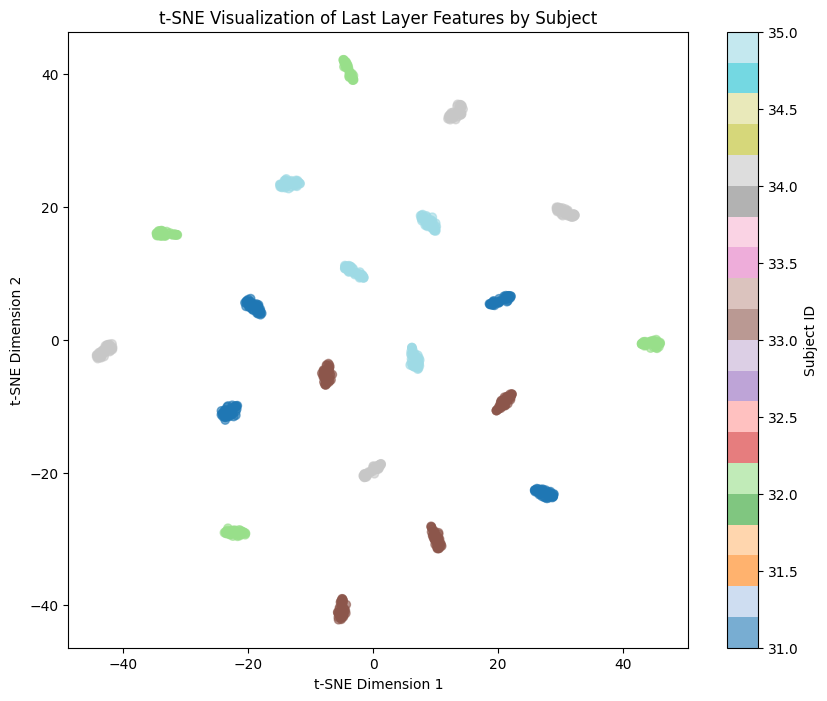

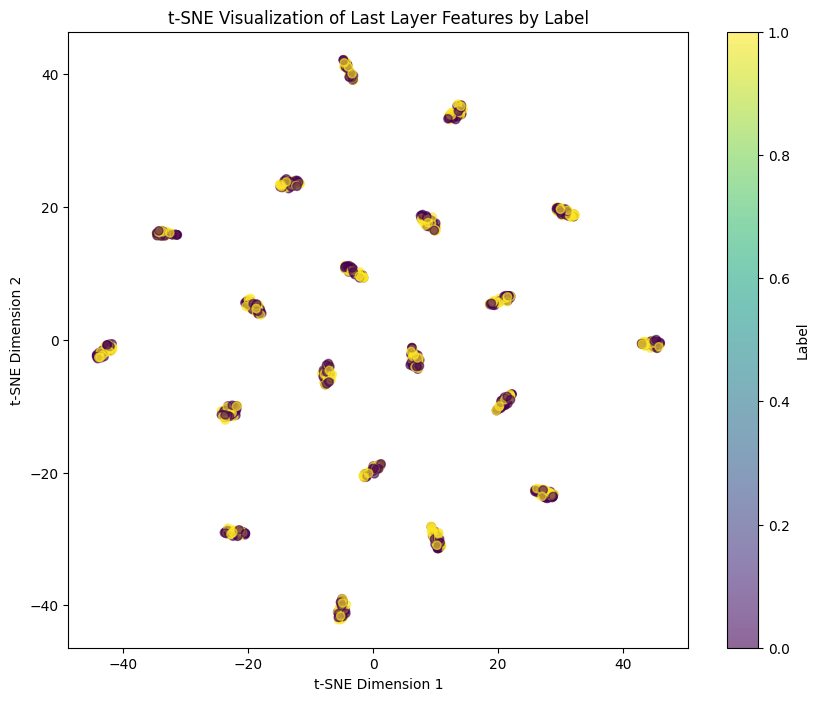

{'training_metric_avg': 1.0, 'training_metric_std': 0.0, 'test_metric_avg': 0.5100000023841857, 'test_metric_std': 0.07000000285250917}


In [8]:
import numpy as np
from eegswintransformer import SwinTransformer
# from model import SwinTransformer_D
from torcheeg.model_selection import KFoldPerSubjectGroupbyTrial
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import DataLoader
from classifier import ClassifierTrainer
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os

HYPERPARAMETERS = {
    "seed": 42,
    "batch_size": 16,
    "lr": 1e-5,
    "weight_decay": 1e-4,
    "num_epochs": 50,
}

k_fold = KFoldPerSubjectGroupbyTrial(
    n_splits=4,
    shuffle=True,
    random_state=12)

training_metrics = []
test_metrics = []

# Lists to store features, labels, and subject IDs for visualization
all_features = []
all_labels = []
all_subject_ids = []

for i, (training_dataset, test_dataset) in enumerate(k_fold.split(dataset)):
    delete_folder_if_exists(target_folder_name='lightning_logs')
    
    # Initialize model
    model = SwinTransformer(patch_size=(8,3,3),
                            depths=(2, 2, 4),
                            num_heads=(2,2,3),
                            window_size=(4,3,3),
                            visual=True
                            ) # T, W, H 同时缩小
    
    trainer = ClassifierTrainer(
        model=model,
        num_classes=2,
        lr=HYPERPARAMETERS['lr'],
        weight_decay=HYPERPARAMETERS['weight_decay'],
        metrics=["accuracy"],
        accelerator="gpu"
    )
    
    # DataLoaders
    training_loader = DataLoader(
        training_dataset,
        batch_size=HYPERPARAMETERS['batch_size'],
        shuffle=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=HYPERPARAMETERS['batch_size'],
        shuffle=False
    )
    
    # Early stopping callback
    early_stopping_callback = EarlyStopping(
        monitor='train_loss',
        patience=20,
        mode='min',
        verbose=True
    )
    
    # Train the model
    trainer.fit(
        training_loader,
        test_loader,
        max_epochs=HYPERPARAMETERS['num_epochs'],
        callbacks=[early_stopping_callback],
        enable_model_summary=False,
        limit_val_batches=0.0
    )
    
    # Extract features from the test set after training
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for batch in test_loader:
            signals, labels, subject_ids = batch
            signals = signals.to(trainer.device)  # Move to GPU if needed
            y_hat, x_feat = model(signals)  # Get predictions and features
            # x_feat is the last layer features
            
            # Store features, labels, and subject_ids
            all_features.append(x_feat.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            subject_ids_int = np.array([int(sid) for sid in subject_ids])
            all_subject_ids.append(subject_ids_int)
    
    # Test and collect metrics
    training_result = trainer.test(
        training_loader,
        enable_progress_bar=True,
        enable_model_summary=True
    )[0]
    test_result = trainer.test(
        test_loader,
        enable_progress_bar=True,
        enable_model_summary=True
    )[0]
    training_metrics.append(training_result["test_accuracy"])
    test_metrics.append(test_result["test_accuracy"])

# Concatenate all collected data
all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_subject_ids = np.concatenate(all_subject_ids, axis=0)

# Dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(all_features)

# Visualization: Scatter plot colored by subject_id
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_subject_ids, cmap='tab20', alpha=0.6)
plt.colorbar(scatter, label='Subject ID')
plt.title('t-SNE Visualization of Last Layer Features by Subject')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.savefig('tsne_by_subject.png')
plt.show()

# Visualization: Scatter plot colored by label
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Label')
plt.title('t-SNE Visualization of Last Layer Features by Label')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.savefig('tsne_by_label.png')
plt.show()

# Print metrics
print({
    "training_metric_avg": np.mean(training_metrics),
    "training_metric_std": np.std(training_metrics),
    "test_metric_avg": np.mean(test_metrics),
    "test_metric_std": np.std(test_metrics)
})

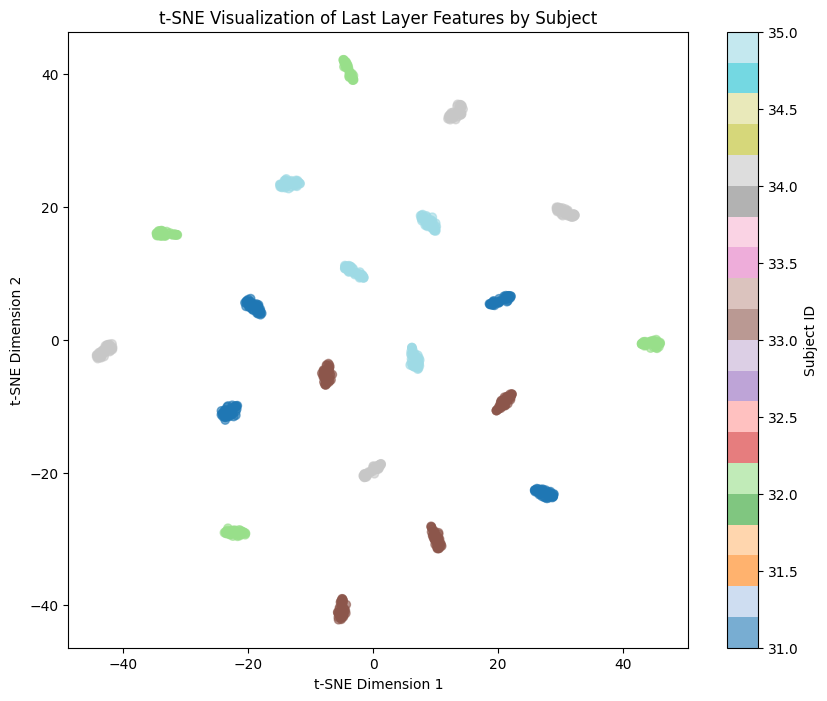

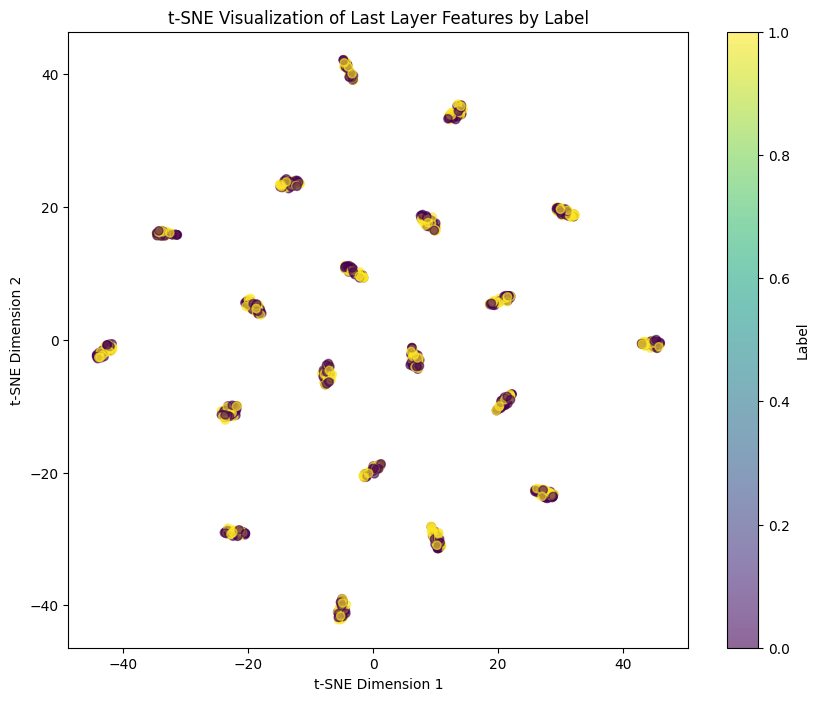

{'training_metric_avg': 1.0, 'training_metric_std': 0.0, 'test_metric_avg': 0.5100000023841857, 'test_metric_std': 0.07000000285250917}


In [9]:

# Dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(all_features)

# Visualization: Scatter plot colored by subject_id
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_subject_ids, cmap='tab20', alpha=0.6)
plt.colorbar(scatter, label='Subject ID')
plt.title('t-SNE Visualization of Last Layer Features by Subject')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.savefig('tsne_by_subject.png')
plt.show()

# Visualization: Scatter plot colored by label
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Label')
plt.title('t-SNE Visualization of Last Layer Features by Label')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.savefig('tsne_by_label.png')
plt.show()

# Print metrics
print({
    "training_metric_avg": np.mean(training_metrics),
    "training_metric_std": np.std(training_metrics),
    "test_metric_avg": np.mean(test_metrics),
    "test_metric_std": np.std(test_metrics)
})